In [1]:
import random
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Sequential, activations, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, SeparableConv2D
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from albumentations import Compose

# Import project utils scripts
import os
import sys

src_path = os.path.join('../src/')

if src_path not in sys.path:
    sys.path.append(src_path)

from visualizationUtils import plot_confusion_matrix
from statisticsUtils import recall_precision_fscore_from_confusion_matrix
from lossesUtils import categorical_focal_loss
from bandUtils import Band 
from labelsUtils import (
    Label,
    LabelCategory,
    category_from_label,
    categories_from_label_set
)

from rasterUtils import make_dataset_from_raster_files
from regionUtils import (
    vietnam_labels_coordinates,
    sumatra_south_labels_coordinates,
    sumatra_center_labels_coordinates,
    sulawesi_labels_coordinates,
    para_north_labels_coordinates,
    para_center_labels_coordinates,
    ocotopeque_labels_coordinates,
    ghana_labels_coordinates,
    borneo_labels_coordinates
)
from convNetUtils import (
    images_from_dataset,
    labels_from_dataset,
    cross_validation_multi_output_model,
    AUGMENTATIONS,
    ImageMultiOutputSequence,
    train_model,
    evaluate_multi_output_model
)
from config import *

/home/simon/miniconda3/envs/tb/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
NB_PIXEL_AROUND = 4
BANDS = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [3]:
# create a dataset per region
datasets = []

labels_coordinates_list = [
    sumatra_south_labels_coordinates(),
    sumatra_center_labels_coordinates(),
    para_north_labels_coordinates(),
    para_center_labels_coordinates(),
    # borneo_labels_coordinates(),
    sulawesi_labels_coordinates(),
    ghana_labels_coordinates(),
    ocotopeque_labels_coordinates()
]

# datasets_name = [
#     'Sumatra_south_2018_whole_year_collection2',
#     'Sumatra_center_2018_whole_year_collection2',
#     'Para_north_2018_whole_year_collection2',
#     'Para_center_2018_whole_year_collection2',
#     # 'Borneo_2018_whole_year_collection2',
#     'Sulawesi_2018_whole_year_collection2',
#     'Ghana_2019_whole_year_collection2',
#     'Ocotopeque_2018_whole_year_collection2'
# ]

datasets_name = [
    'Sumatra_south_2018_january_to_april_collection2',
    'Sumatra_center_2018_january_to_april_collection2',
    'Para_north_2018_january_to_april_collection2',
    'Para_center_2018_january_to_april_collection2',
    # 'Borneo_2018_january_to_april_collection2',
    'Sulawesi_2018_january_to_april_collection2',
    'Ghana_2019_january_to_april_collection2',
    'Ocotopeque_2018_january_to_april_collection2'
]


for i, dataset_name in enumerate(datasets_name):
    labels_coordinates = labels_coordinates_list[i]
    labels = [Label(label) for label in labels_coordinates if len(labels_coordinates[label]) > 5]
    categories = pd.unique([category_from_label(label) for label in labels])
        
    dataset_args = dict(
        labels = labels,
        raster_paths = [os.path.join(DATA_ROOT_PATH, dataset_name, 'merged.tif')],
        labels_coordinates_list = [labels_coordinates],
        nb_pixel_around = NB_PIXEL_AROUND
    )

    dataset = make_dataset_from_raster_files(**dataset_args)
    datasets.append((labels, len(categories), dataset))

KeyboardInterrupt: 

In [118]:
size_min_datasets = min([len(dataset[2]) for dataset in datasets])
print(size_min_datasets)

1082


In [119]:
def task_from_dataset(dataset, labels, labels_names, nb_categories, nb_images=None):
    # Shuffle images order in dataset
    np.random.shuffle(dataset)
    
    if nb_images is not None:
        # Specify a number of images to sample
        dataset = random.choices(dataset, k=nb_images)

    labels_train = labels_from_dataset(dataset, labels_names)
    categories_train = categories_from_label_set(labels, labels_train)
    
    X_train = images_from_dataset(dataset, BANDS)
    y_train = [labels_train, categories_train]
    Y_train = [
        to_categorical(labels_train, num_classes=len(labels_names)), 
        to_categorical(categories_train, num_classes=nb_categories), 
    ]
    
    # Format true label sets for multi output
    Y_train = {
        output_name: Y_train[i] for i, output_name in enumerate(['label', 'category'])
    }
        
    return X_train, Y_train, len(labels_train) / 32


def iteration_tasks(datasets, nb_images=None):
    datasets_order = np.arange(len(datasets))
        
    # Shuffle datasets order
    np.random.shuffle(datasets_order)

    # Loop through every datasets in an iterastion
    for dataset_iter, dataset_idx in enumerate(datasets_order):
        labels, nb_categories, dataset = datasets[dataset_idx]
        labels_names = [label.name for label in labels]
        
        print(f"dataset index: {dataset_idx}, dataset iteration: {dataset_iter + 1}/{len(datasets)}, size: {len(dataset)}")
        
        X_train, Y_train, steps_per_epoch = task_from_dataset(dataset, labels, labels_names, nb_categories, nb_images)
                
        yield X_train, Y_train, steps_per_epoch, dataset_idx, len(labels_names), nb_categories

In [70]:
image_width = 9
image_height = 9
image_depth = len(BANDS)
    
# define model
inputs = Input(shape=(image_width, image_height, image_depth))
layers = Rescaling(0.0000275, offset=0.2)(inputs)
layers = BatchNormalization()(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = SpatialDropout2D(0.25)(layers)
layers = GlobalAveragePooling2D(name='last_pretrained_layer')(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.25, name="last_input_layer")(layers)

label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(LabelCategory), activation='softmax', name="category")(layers)

model = Model(inputs=inputs, outputs=[label_output, category_output])

## v1

In [7]:
# define hyperparameters
meta_step_size = 0.1
nb_iterations = 100
nb_inner_iters = 5
minibatches_size = 32

tasks_output_weights = [None for _ in np.arange(len(datasets))]
datasets_losses = [[] for _ in np.arange(len(datasets))]

for iteration in range(nb_iterations):
    print(f"iteration: {iteration + 1}/{nb_iterations}\n-----------------")
    
    for X_train, Y_train, steps_per_epoch, dataset_idx, nb_labels, nb_categories in iteration_tasks(datasets):
        # Create model with an new output layer for this task
        label_output = Dense(nb_labels, activation='softmax', name="label")(model.get_layer('last_input_layer').output)
        category_output = Dense(nb_categories, activation='softmax', name="category")(model.get_layer('last_input_layer').output)
        
        model = Model(inputs=inputs, outputs=[label_output, category_output])
                
        model.compile(optimizer='adam', loss={
            'label': categorical_focal_loss([[.25] * nb_labels]),
            'category': categorical_focal_loss([[.25] * nb_categories])
        })
        
        # If task as already been trained on, set back the previous weights of the output layer 
        if tasks_output_weights[dataset_idx] is not None :
            model.layers[-1].set_weights(tasks_output_weights[dataset_idx])        

        # Save old weights
        old_weights = model.get_weights()
        
        # Train
        model.fit(
            x=X_train,
            y=Y_train,
            epochs=nb_inner_iters,
            steps_per_epoch=steps_per_epoch,
            verbose=0
        )
        
        # Evaluate model on training data
        score = model.evaluate(X_train, Y_train, verbose=0)
        
        # Get new weights
        new_weights = model.get_weights()
        
        # Store dataset current loss and accuracies
        datasets_losses[dataset_idx].append(float(score[0]))
        
        print(f"- loss: {score[0]}")
        print(datasets_losses)

        # Update weights
        for weight in range(len(new_weights)):
            current_meta_step_size = (1 - iteration / nb_iterations) * meta_step_size
            
            new_weights[weight] = old_weights[weight] + (
                (new_weights[weight] - old_weights[weight]) * current_meta_step_size
            )

        # After the meta-learning step, reload the newly-trained weights into the model.
        model.set_weights(new_weights)

        # Save task's output layer weights
        tasks_output_weights[dataset_idx] = model.layers[-1].get_weights()

iteration: 1/100
-----------------
dataset index: 3, dataset iteration: 1/8, size: 20687
- loss: 0.05874073877930641
dataset index: 1, dataset iteration: 2/8, size: 2155
- loss: 0.46985748410224915
dataset index: 2, dataset iteration: 3/8, size: 2234
- loss: 0.14396362006664276
dataset index: 0, dataset iteration: 4/8, size: 11477
- loss: 0.07297229021787643
dataset index: 4, dataset iteration: 5/8, size: 89
- loss: 0.465379536151886
dataset index: 5, dataset iteration: 6/8, size: 3168
- loss: 0.32658612728118896
dataset index: 6, dataset iteration: 7/8, size: 7356
- loss: 0.35134708881378174
dataset index: 7, dataset iteration: 8/8, size: 59317
- loss: 0.06430808454751968
iteration: 2/100
-----------------
dataset index: 7, dataset iteration: 1/8, size: 59317
- loss: 0.06120006740093231
dataset index: 3, dataset iteration: 2/8, size: 20687
- loss: 0.04855780676007271
dataset index: 5, dataset iteration: 3/8, size: 3168
- loss: 0.27057743072509766
dataset index: 4, dataset iteration: 4

- loss: 0.2082163393497467
dataset index: 3, dataset iteration: 2/8, size: 20687
- loss: 0.022002479061484337
dataset index: 4, dataset iteration: 3/8, size: 89
- loss: 0.2222290188074112
dataset index: 5, dataset iteration: 4/8, size: 3168
- loss: 0.06961492449045181
dataset index: 7, dataset iteration: 5/8, size: 59317
- loss: 0.03367201238870621
dataset index: 0, dataset iteration: 6/8, size: 11477
- loss: 0.02999242953956127
dataset index: 1, dataset iteration: 7/8, size: 2155
- loss: 0.08175142854452133
dataset index: 2, dataset iteration: 8/8, size: 2234
- loss: 0.00706707127392292
iteration: 14/100
-----------------
dataset index: 2, dataset iteration: 1/8, size: 2234
- loss: 0.0142222223803401
dataset index: 5, dataset iteration: 2/8, size: 3168
- loss: 0.07136567682027817
dataset index: 0, dataset iteration: 3/8, size: 11477
- loss: 0.031228486448526382
dataset index: 4, dataset iteration: 4/8, size: 89
- loss: 0.14225828647613525
dataset index: 3, dataset iteration: 5/8, size

- loss: 0.016033008694648743
dataset index: 5, dataset iteration: 2/8, size: 3168
- loss: 0.05186954140663147
dataset index: 7, dataset iteration: 3/8, size: 59317
- loss: 0.026420269161462784
dataset index: 2, dataset iteration: 4/8, size: 2234
- loss: 0.0011027901200577617
dataset index: 4, dataset iteration: 5/8, size: 89
- loss: 0.12335013598203659
dataset index: 6, dataset iteration: 6/8, size: 7356
- loss: 0.1691891849040985
dataset index: 1, dataset iteration: 7/8, size: 2155
- loss: 0.07116086035966873
dataset index: 0, dataset iteration: 8/8, size: 11477
- loss: 0.02018759772181511
iteration: 26/100
-----------------
dataset index: 2, dataset iteration: 1/8, size: 2234
- loss: 0.0023105896543711424
dataset index: 7, dataset iteration: 2/8, size: 59317
- loss: 0.02791651338338852
dataset index: 1, dataset iteration: 3/8, size: 2155
- loss: 0.06250021606683731
dataset index: 3, dataset iteration: 4/8, size: 20687
- loss: 0.021997282281517982
dataset index: 0, dataset iteration: 

- loss: 0.12894323468208313
dataset index: 0, dataset iteration: 2/8, size: 11477
- loss: 0.015890592709183693
dataset index: 1, dataset iteration: 3/8, size: 2155
- loss: 0.053174108266830444
dataset index: 3, dataset iteration: 4/8, size: 20687
- loss: 0.012095370329916477
dataset index: 2, dataset iteration: 5/8, size: 2234
- loss: 0.004262649919837713
dataset index: 6, dataset iteration: 6/8, size: 7356
- loss: 0.1337817758321762
dataset index: 7, dataset iteration: 7/8, size: 59317
- loss: 0.02238648012280464
dataset index: 5, dataset iteration: 8/8, size: 3168
- loss: 0.043892018496990204
iteration: 38/100
-----------------
dataset index: 7, dataset iteration: 1/8, size: 59317
- loss: 0.022438732907176018
dataset index: 5, dataset iteration: 2/8, size: 3168
- loss: 0.04514046013355255
dataset index: 6, dataset iteration: 3/8, size: 7356
- loss: 0.14121542870998383
dataset index: 3, dataset iteration: 4/8, size: 20687
- loss: 0.01293379906564951
dataset index: 2, dataset iteration

- loss: 0.01028909906744957
dataset index: 5, dataset iteration: 2/8, size: 3168
- loss: 0.04063040763139725
dataset index: 6, dataset iteration: 3/8, size: 7356
- loss: 0.11893081665039062
dataset index: 2, dataset iteration: 4/8, size: 2234
- loss: 0.002111084759235382
dataset index: 7, dataset iteration: 5/8, size: 59317
- loss: 0.017898518592119217
dataset index: 1, dataset iteration: 6/8, size: 2155
- loss: 0.04891146346926689
dataset index: 4, dataset iteration: 7/8, size: 89
- loss: 0.11106859892606735
dataset index: 0, dataset iteration: 8/8, size: 11477
- loss: 0.013723799958825111
iteration: 50/100
-----------------
dataset index: 6, dataset iteration: 1/8, size: 7356
- loss: 0.12276331335306168
dataset index: 0, dataset iteration: 2/8, size: 11477
- loss: 0.016380053013563156
dataset index: 1, dataset iteration: 3/8, size: 2155
- loss: 0.04225985333323479
dataset index: 7, dataset iteration: 4/8, size: 59317
- loss: 0.01914667896926403
dataset index: 3, dataset iteration: 5/

- loss: 0.018794236704707146
dataset index: 0, dataset iteration: 2/8, size: 11477
- loss: 0.013808677904307842
dataset index: 6, dataset iteration: 3/8, size: 7356
- loss: 0.11425059288740158
dataset index: 2, dataset iteration: 4/8, size: 2234
- loss: 0.0008717922610230744
dataset index: 5, dataset iteration: 5/8, size: 3168
- loss: 0.03600792586803436
dataset index: 3, dataset iteration: 6/8, size: 20687
- loss: 0.010811951011419296
dataset index: 1, dataset iteration: 7/8, size: 2155
- loss: 0.0389619916677475
dataset index: 4, dataset iteration: 8/8, size: 89
- loss: 0.12471221387386322
iteration: 62/100
-----------------
dataset index: 6, dataset iteration: 1/8, size: 7356
- loss: 0.10856065899133682
dataset index: 3, dataset iteration: 2/8, size: 20687
- loss: 0.008869224227964878
dataset index: 0, dataset iteration: 3/8, size: 11477
- loss: 0.017112741246819496
dataset index: 7, dataset iteration: 4/8, size: 59317
- loss: 0.020448394119739532
dataset index: 2, dataset iteration

- loss: 0.03254096955060959
dataset index: 3, dataset iteration: 2/8, size: 20687
- loss: 0.013668871484696865
dataset index: 0, dataset iteration: 3/8, size: 11477
- loss: 0.01184204313904047
dataset index: 7, dataset iteration: 4/8, size: 59317
- loss: 0.0167051050812006
dataset index: 6, dataset iteration: 5/8, size: 7356
- loss: 0.11214657872915268
dataset index: 2, dataset iteration: 6/8, size: 2234
- loss: 0.0017862959066405892
dataset index: 4, dataset iteration: 7/8, size: 89
- loss: 0.1067841425538063
dataset index: 1, dataset iteration: 8/8, size: 2155
- loss: 0.03540033847093582
iteration: 74/100
-----------------
dataset index: 7, dataset iteration: 1/8, size: 59317
- loss: 0.01889627054333687
dataset index: 4, dataset iteration: 2/8, size: 89
- loss: 0.10121221095323563
dataset index: 0, dataset iteration: 3/8, size: 11477
- loss: 0.012824027799069881
dataset index: 1, dataset iteration: 4/8, size: 2155
- loss: 0.04058394581079483
dataset index: 3, dataset iteration: 5/8, 

- loss: 0.008902141824364662
dataset index: 7, dataset iteration: 2/8, size: 59317
- loss: 0.01761518605053425
dataset index: 1, dataset iteration: 3/8, size: 2155
- loss: 0.04433947801589966
dataset index: 0, dataset iteration: 4/8, size: 11477
- loss: 0.012736620381474495
dataset index: 2, dataset iteration: 5/8, size: 2234
- loss: 0.0007028162362985313
dataset index: 5, dataset iteration: 6/8, size: 3168
- loss: 0.02909163571894169
dataset index: 4, dataset iteration: 7/8, size: 89
- loss: 0.10435602813959122
dataset index: 6, dataset iteration: 8/8, size: 7356
- loss: 0.10982891172170639
iteration: 86/100
-----------------
dataset index: 3, dataset iteration: 1/8, size: 20687
- loss: 0.012202258221805096
dataset index: 5, dataset iteration: 2/8, size: 3168
- loss: 0.027286062017083168
dataset index: 4, dataset iteration: 3/8, size: 89
- loss: 0.09406624734401703
dataset index: 2, dataset iteration: 4/8, size: 2234
- loss: 0.0006127496599219739
dataset index: 0, dataset iteration: 5

- loss: 0.00886926706880331
dataset index: 1, dataset iteration: 2/8, size: 2155
- loss: 0.04531380906701088
dataset index: 5, dataset iteration: 3/8, size: 3168
- loss: 0.02915113791823387
dataset index: 6, dataset iteration: 4/8, size: 7356
- loss: 0.10564421117305756
dataset index: 2, dataset iteration: 5/8, size: 2234
- loss: 0.0016468653921037912
dataset index: 7, dataset iteration: 6/8, size: 59317
- loss: 0.017096631228923798
dataset index: 0, dataset iteration: 7/8, size: 11477
- loss: 0.014657813124358654
dataset index: 4, dataset iteration: 8/8, size: 89
- loss: 0.11893685907125473
iteration: 98/100
-----------------
dataset index: 5, dataset iteration: 1/8, size: 3168
- loss: 0.0322287417948246
dataset index: 1, dataset iteration: 2/8, size: 2155
- loss: 0.03626882657408714
dataset index: 4, dataset iteration: 3/8, size: 89
- loss: 0.09438557922840118
dataset index: 2, dataset iteration: 4/8, size: 2234
- loss: 0.0010346490889787674
dataset index: 3, dataset iteration: 5/8, 

0.014803510159254074
0.037254635244607925
0.0010234233923256397
0.007154997903853655
0.12222884595394135
0.03301871567964554
0.10456104576587677
0.016448354348540306


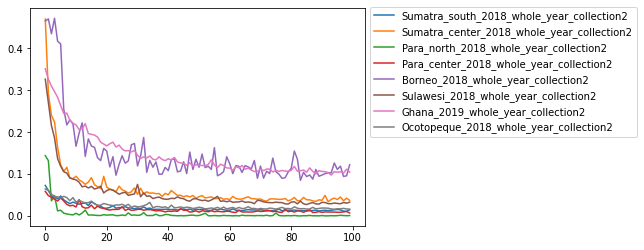

In [8]:
for dataset_idx in np.arange(len(datasets)):
    pl.plot(datasets_losses[dataset_idx], label=datasets_name[dataset_idx])
    
    print(datasets_losses[dataset_idx][-1])

pl.legend(bbox_to_anchor=(1, 1.03))

In [9]:
# remove last layer
model = Model(inputs=model.input, outputs=model.get_layer('last_input_layer').output)

# save model
model.save(os.path.join(MODEL_ROOT_PATH, 'multi_output_pretrained_with_reptile.hdf5'))

## v2 (without borneo, diff hyperparameters)

In [7]:
# define hyperparameters
meta_step_size = 0.35
nb_iterations = 100
nb_inner_iters = 5
minibatches_size = 32

tasks_output_weights = [None for _ in np.arange(len(datasets))]
datasets_losses = [[] for _ in np.arange(len(datasets))]

for iteration in range(nb_iterations):
    print(f"iteration: {iteration + 1}/{nb_iterations}\n-----------------")
    
    for X_train, Y_train, steps_per_epoch, dataset_idx, nb_labels, nb_categories in iteration_tasks(datasets):
        # Create model with an new output layer for this task
        label_output = Dense(nb_labels, activation='softmax', name="label")(model.get_layer('last_input_layer').output)
        category_output = Dense(nb_categories, activation='softmax', name="category")(model.get_layer('last_input_layer').output)
        
        model = Model(inputs=inputs, outputs=[label_output, category_output])

        model.compile(optimizer='adam', loss={
            'label': categorical_focal_loss([[.25] * nb_labels]),
            'category': categorical_focal_loss([[.25] * nb_categories])
        })
        
        # If task as already been trained on, set back the previous weights of the output layer 
        if tasks_output_weights[dataset_idx] is not None :
            model.layers[-1].set_weights(tasks_output_weights[dataset_idx])        

        # Save old weights
        old_weights = model.get_weights()
        
        # Train
        model.fit(
            x=X_train,
            y=Y_train,
            epochs=nb_inner_iters,
            steps_per_epoch=steps_per_epoch,
            verbose=0
        )
        
        # Evaluate model on training data
        score = model.evaluate(X_train, Y_train, verbose=0)
        
        # Get new weights
        new_weights = model.get_weights()
        
        # Store dataset current loss and accuracies
        datasets_losses[dataset_idx].append(float(score[0]))
        
        print(f"- loss: {score[0]}")

        # Update weights
        for weight in range(len(new_weights)):
            current_meta_step_size = (1 - iteration / nb_iterations) * meta_step_size
            
            new_weights[weight] = old_weights[weight] + (
                (new_weights[weight] - old_weights[weight]) * current_meta_step_size
            )

        # After the meta-learning step, reload the newly-trained weights into the model.
        model.set_weights(new_weights)

        # Save task's output layer weights
        tasks_output_weights[dataset_idx] = model.layers[-1].get_weights()

iteration: 1/100
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.22837373614311218
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.05864027142524719
dataset index: 0, dataset iteration: 3/7, size: 11477
- loss: 0.06247253343462944
dataset index: 1, dataset iteration: 4/7, size: 2155
- loss: 0.2386702001094818
dataset index: 4, dataset iteration: 5/7, size: 3168
- loss: 0.1683434695005417
dataset index: 5, dataset iteration: 6/7, size: 7356
- loss: 0.2984572947025299
dataset index: 3, dataset iteration: 7/7, size: 20687
- loss: 0.049004100263118744
iteration: 2/100
-----------------
dataset index: 4, dataset iteration: 1/7, size: 3168
- loss: 0.13808338344097137
dataset index: 3, dataset iteration: 2/7, size: 20687
- loss: 0.037848323583602905
dataset index: 2, dataset iteration: 3/7, size: 2234
- loss: 0.012377305887639523
dataset index: 1, dataset iteration: 4/7, size: 2155
- loss: 0.12109982222318649
dataset index: 0, dataset iteration

- loss: 0.06159753352403641
dataset index: 2, dataset iteration: 5/7, size: 2234
- loss: 0.004233239218592644
dataset index: 5, dataset iteration: 6/7, size: 7356
- loss: 0.1582956165075302
dataset index: 1, dataset iteration: 7/7, size: 2155
- loss: 0.08046333491802216
iteration: 15/100
-----------------
dataset index: 3, dataset iteration: 1/7, size: 20687
- loss: 0.016421297565102577
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 0.14154456555843353
dataset index: 4, dataset iteration: 3/7, size: 3168
- loss: 0.051530733704566956
dataset index: 6, dataset iteration: 4/7, size: 59317
- loss: 0.020726224407553673
dataset index: 0, dataset iteration: 5/7, size: 11477
- loss: 0.026224171742796898
dataset index: 2, dataset iteration: 6/7, size: 2234
- loss: 0.002062334679067135
dataset index: 1, dataset iteration: 7/7, size: 2155
- loss: 0.07418522983789444
iteration: 16/100
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.0014605040196329355

- loss: 0.011445869691669941
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 0.11453811824321747
dataset index: 1, dataset iteration: 3/7, size: 2155
- loss: 0.051065266132354736
dataset index: 4, dataset iteration: 4/7, size: 3168
- loss: 0.04354932904243469
dataset index: 0, dataset iteration: 5/7, size: 11477
- loss: 0.018215317279100418
dataset index: 6, dataset iteration: 6/7, size: 59317
- loss: 0.015247640199959278
dataset index: 2, dataset iteration: 7/7, size: 2234
- loss: 0.0015085303457453847
iteration: 29/100
-----------------
dataset index: 3, dataset iteration: 1/7, size: 20687
- loss: 0.010852454230189323
dataset index: 0, dataset iteration: 2/7, size: 11477
- loss: 0.01629095897078514
dataset index: 6, dataset iteration: 3/7, size: 59317
- loss: 0.015142182819545269
dataset index: 1, dataset iteration: 4/7, size: 2155
- loss: 0.06569081544876099
dataset index: 2, dataset iteration: 5/7, size: 2234
- loss: 0.0015143542550504208
dataset index: 4, dataset iter

- loss: 0.010563039220869541
dataset index: 1, dataset iteration: 6/7, size: 2155
- loss: 0.04535498470067978
dataset index: 0, dataset iteration: 7/7, size: 11477
- loss: 0.014831437729299068
iteration: 42/100
-----------------
dataset index: 3, dataset iteration: 1/7, size: 20687
- loss: 0.01270836777985096
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.014905565418303013
dataset index: 4, dataset iteration: 3/7, size: 3168
- loss: 0.03728567808866501
dataset index: 1, dataset iteration: 4/7, size: 2155
- loss: 0.04571298509836197
dataset index: 5, dataset iteration: 5/7, size: 7356
- loss: 0.09958492964506149
dataset index: 0, dataset iteration: 6/7, size: 11477
- loss: 0.015623146668076515
dataset index: 2, dataset iteration: 7/7, size: 2234
- loss: 0.0029612004291266203
iteration: 43/100
-----------------
dataset index: 3, dataset iteration: 1/7, size: 20687
- loss: 0.010102611035108566
dataset index: 4, dataset iteration: 2/7, size: 3168
- loss: 0.037148013710975

- loss: 0.03780536726117134
dataset index: 0, dataset iteration: 2/7, size: 11477
- loss: 0.012653167359530926
dataset index: 2, dataset iteration: 3/7, size: 2234
- loss: 0.0006488476064987481
dataset index: 6, dataset iteration: 4/7, size: 59317
- loss: 0.011900676414370537
dataset index: 4, dataset iteration: 5/7, size: 3168
- loss: 0.031876929104328156
dataset index: 5, dataset iteration: 6/7, size: 7356
- loss: 0.09523771703243256
dataset index: 3, dataset iteration: 7/7, size: 20687
- loss: 0.00993531383574009
iteration: 56/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 7356
- loss: 0.08554358780384064
dataset index: 3, dataset iteration: 2/7, size: 20687
- loss: 0.008672548457980156
dataset index: 1, dataset iteration: 3/7, size: 2155
- loss: 0.0382230207324028
dataset index: 0, dataset iteration: 4/7, size: 11477
- loss: 0.013590198010206223
dataset index: 6, dataset iteration: 5/7, size: 59317
- loss: 0.011935430578887463
dataset index: 2, dataset iterat

- loss: 0.0007916903705336154
dataset index: 4, dataset iteration: 6/7, size: 3168
- loss: 0.028798433020710945
dataset index: 3, dataset iteration: 7/7, size: 20687
- loss: 0.008925446309149265
iteration: 69/100
-----------------
dataset index: 6, dataset iteration: 1/7, size: 59317
- loss: 0.016082653775811195
dataset index: 0, dataset iteration: 2/7, size: 11477
- loss: 0.013022557832300663
dataset index: 5, dataset iteration: 3/7, size: 7356
- loss: 0.08819007873535156
dataset index: 4, dataset iteration: 4/7, size: 3168
- loss: 0.029817180708050728
dataset index: 2, dataset iteration: 5/7, size: 2234
- loss: 0.0014797840267419815
dataset index: 3, dataset iteration: 6/7, size: 20687
- loss: 0.00809809472411871
dataset index: 1, dataset iteration: 7/7, size: 2155
- loss: 0.034877706319093704
iteration: 70/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 7356
- loss: 0.07706987857818604
dataset index: 1, dataset iteration: 2/7, size: 2155
- loss: 0.0329632423818

- loss: 0.00746016763150692
dataset index: 2, dataset iteration: 2/7, size: 2234
- loss: 0.0003603109216783196
dataset index: 6, dataset iteration: 3/7, size: 59317
- loss: 0.010981017723679543
dataset index: 4, dataset iteration: 4/7, size: 3168
- loss: 0.02766234055161476
dataset index: 1, dataset iteration: 5/7, size: 2155
- loss: 0.03221999853849411
dataset index: 0, dataset iteration: 6/7, size: 11477
- loss: 0.010977975092828274
dataset index: 5, dataset iteration: 7/7, size: 7356
- loss: 0.08028773218393326
iteration: 83/100
-----------------
dataset index: 4, dataset iteration: 1/7, size: 3168
- loss: 0.023803815245628357
dataset index: 1, dataset iteration: 2/7, size: 2155
- loss: 0.03155720978975296
dataset index: 6, dataset iteration: 3/7, size: 59317
- loss: 0.01037798635661602
dataset index: 2, dataset iteration: 4/7, size: 2234
- loss: 0.0009161095949821174
dataset index: 3, dataset iteration: 5/7, size: 20687
- loss: 0.009289964102208614
dataset index: 5, dataset iterati

- loss: 0.010612953454256058
dataset index: 5, dataset iteration: 6/7, size: 7356
- loss: 0.07514750957489014
dataset index: 6, dataset iteration: 7/7, size: 59317
- loss: 0.010026863776147366
iteration: 96/100
-----------------
dataset index: 6, dataset iteration: 1/7, size: 59317
- loss: 0.011241300031542778
dataset index: 1, dataset iteration: 2/7, size: 2155
- loss: 0.032554447650909424
dataset index: 0, dataset iteration: 3/7, size: 11477
- loss: 0.010829519480466843
dataset index: 4, dataset iteration: 4/7, size: 3168
- loss: 0.025691857561469078
dataset index: 3, dataset iteration: 5/7, size: 20687
- loss: 0.00754750519990921
dataset index: 5, dataset iteration: 6/7, size: 7356
- loss: 0.07573681324720383
dataset index: 2, dataset iteration: 7/7, size: 2234
- loss: 0.0008717932505533099
iteration: 97/100
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.0015039496356621385
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 0.0782542824745

0.01112225092947483
0.029041964560747147
0.0005029580788686872
0.0072794160805642605
0.024312175810337067
0.07720689475536346
0.012711836956441402


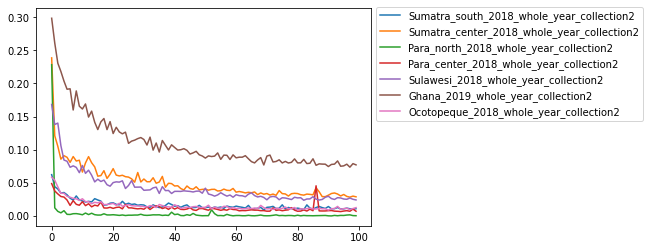

In [8]:
for dataset_idx in np.arange(len(datasets)):
    pl.plot(datasets_losses[dataset_idx], label=datasets_name[dataset_idx])
    
    print(datasets_losses[dataset_idx][-1])

pl.legend(bbox_to_anchor=(1, 1.03))

In [9]:
# remove last layer
model = Model(inputs=model.input, outputs=model.get_layer('last_pretrained_layer').output)

# save model
model.save(os.path.join(MODEL_ROOT_PATH, 'multi_output_pretrained_with_reptile_v2.hdf5'))

## v3 (categorical cross entropy, diff hyperparameters, without borneo)

In [7]:
# define hyperparameters
meta_step_size = 0.25
nb_iterations = 100
nb_inner_iters = 3
minibatches_size = 32

tasks_output_weights = [None for _ in np.arange(len(datasets))]
datasets_losses = [[] for _ in np.arange(len(datasets))]

for iteration in range(nb_iterations):
    print(f"iteration: {iteration + 1}/{nb_iterations}\n-----------------")
    
    for X_train, Y_train, steps_per_epoch, dataset_idx, nb_labels, nb_categories in iteration_tasks(datasets):
        # Create model with an new output layer for this task
        label_output = Dense(nb_labels, activation='softmax', name="label")(model.get_layer('last_input_layer').output)
        category_output = Dense(nb_categories, activation='softmax', name="category")(model.get_layer('last_input_layer').output)
        
        model = Model(inputs=inputs, outputs=[label_output, category_output])

        model.compile(optimizer='adam', loss={
            'label': 'categorical_crossentropy',
            'category': 'categorical_crossentropy'
        })
        
        # If task as already been trained on, set back the previous weights of the output layer 
        if tasks_output_weights[dataset_idx] is not None :
            model.layers[-1].set_weights(tasks_output_weights[dataset_idx])        

        # Save old weights
        old_weights = model.get_weights()
        
        # Train
        model.fit(
            x=X_train,
            y=Y_train,
            epochs=nb_inner_iters,
            steps_per_epoch=steps_per_epoch,
            verbose=0
        )
        
        # Evaluate model on training data
        score = model.evaluate(X_train, Y_train, verbose=0)
        
        # Get new weights
        new_weights = model.get_weights()
        
        # Store dataset current loss and accuracies
        datasets_losses[dataset_idx].append(float(score[0]))
        
        print(f"- loss: {score[0]}")

        # Update weights
        for weight in range(len(new_weights)):
            current_meta_step_size = (1 - iteration / nb_iterations) * meta_step_size
            
            new_weights[weight] = old_weights[weight] + (
                (new_weights[weight] - old_weights[weight]) * current_meta_step_size
            )

        # After the meta-learning step, reload the newly-trained weights into the model.
        model.set_weights(new_weights)

        # Save task's output layer weights
        tasks_output_weights[dataset_idx] = model.layers[-1].get_weights()

iteration: 1/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 7356
- loss: 2.645271062850952
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.6939663290977478
dataset index: 0, dataset iteration: 3/7, size: 11477
- loss: 0.7448346018791199
dataset index: 2, dataset iteration: 4/7, size: 2234
- loss: 0.8922483325004578
dataset index: 4, dataset iteration: 5/7, size: 3168
- loss: 3.235975503921509
dataset index: 3, dataset iteration: 6/7, size: 20687
- loss: 0.4891805350780487
dataset index: 1, dataset iteration: 7/7, size: 2155
- loss: 3.6300487518310547
iteration: 2/100
-----------------
dataset index: 6, dataset iteration: 1/7, size: 59317
- loss: 0.5999603867530823
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 2.2194716930389404
dataset index: 0, dataset iteration: 3/7, size: 11477
- loss: 0.5400900840759277
dataset index: 2, dataset iteration: 4/7, size: 2234
- loss: 0.6121430397033691
dataset index: 4, dataset iteration: 5/7, size:

- loss: 0.3155023157596588
dataset index: 5, dataset iteration: 6/7, size: 7356
- loss: 1.6071799993515015
dataset index: 3, dataset iteration: 7/7, size: 20687
- loss: 0.2723288834095001
iteration: 15/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 7356
- loss: 1.576157569885254
dataset index: 0, dataset iteration: 2/7, size: 11477
- loss: 0.29896172881126404
dataset index: 3, dataset iteration: 3/7, size: 20687
- loss: 0.2277812510728836
dataset index: 6, dataset iteration: 4/7, size: 59317
- loss: 0.2927475869655609
dataset index: 1, dataset iteration: 5/7, size: 2155
- loss: 1.000669002532959
dataset index: 2, dataset iteration: 6/7, size: 2234
- loss: 0.07189231365919113
dataset index: 4, dataset iteration: 7/7, size: 3168
- loss: 0.8330146074295044
iteration: 16/100
-----------------
dataset index: 1, dataset iteration: 1/7, size: 2155
- loss: 0.9283580183982849
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.27939754724502563
dataset index: 

- loss: 0.038415659219026566
dataset index: 1, dataset iteration: 4/7, size: 2155
- loss: 0.7942165732383728
dataset index: 4, dataset iteration: 5/7, size: 3168
- loss: 0.7337788343429565
dataset index: 5, dataset iteration: 6/7, size: 7356
- loss: 1.483350396156311
dataset index: 0, dataset iteration: 7/7, size: 11477
- loss: 0.2724664807319641
iteration: 29/100
-----------------
dataset index: 3, dataset iteration: 1/7, size: 20687
- loss: 0.2029096633195877
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 1.3646581172943115
dataset index: 6, dataset iteration: 3/7, size: 59317
- loss: 0.19675201177597046
dataset index: 0, dataset iteration: 4/7, size: 11477
- loss: 0.24656426906585693
dataset index: 1, dataset iteration: 5/7, size: 2155
- loss: 0.7806363701820374
dataset index: 4, dataset iteration: 6/7, size: 3168
- loss: 0.7311043739318848
dataset index: 2, dataset iteration: 7/7, size: 2234
- loss: 0.05741839110851288
iteration: 30/100
-----------------
dataset index

- loss: 0.5931488871574402
dataset index: 3, dataset iteration: 2/7, size: 20687
- loss: 0.15225794911384583
dataset index: 5, dataset iteration: 3/7, size: 7356
- loss: 1.2038782835006714
dataset index: 6, dataset iteration: 4/7, size: 59317
- loss: 0.1736835092306137
dataset index: 1, dataset iteration: 5/7, size: 2155
- loss: 0.6738225817680359
dataset index: 0, dataset iteration: 6/7, size: 11477
- loss: 0.19504383206367493
dataset index: 2, dataset iteration: 7/7, size: 2234
- loss: 0.05284912884235382
iteration: 43/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 7356
- loss: 1.2295292615890503
dataset index: 0, dataset iteration: 2/7, size: 11477
- loss: 0.21663254499435425
dataset index: 4, dataset iteration: 3/7, size: 3168
- loss: 0.6003043055534363
dataset index: 3, dataset iteration: 4/7, size: 20687
- loss: 0.2316996306180954
dataset index: 6, dataset iteration: 5/7, size: 59317
- loss: 0.17901067435741425
dataset index: 2, dataset iteration: 6/7, size

- loss: 1.1876494884490967
dataset index: 1, dataset iteration: 7/7, size: 2155
- loss: 0.6630228757858276
iteration: 56/100
-----------------
dataset index: 1, dataset iteration: 1/7, size: 2155
- loss: 0.572395384311676
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.16366465389728546
dataset index: 5, dataset iteration: 3/7, size: 7356
- loss: 1.166029453277588
dataset index: 0, dataset iteration: 4/7, size: 11477
- loss: 0.21520201861858368
dataset index: 3, dataset iteration: 5/7, size: 20687
- loss: 0.13603322207927704
dataset index: 4, dataset iteration: 6/7, size: 3168
- loss: 0.6109930872917175
dataset index: 2, dataset iteration: 7/7, size: 2234
- loss: 0.035591334104537964
iteration: 57/100
-----------------
dataset index: 4, dataset iteration: 1/7, size: 3168
- loss: 0.49700281023979187
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 1.1982755661010742
dataset index: 1, dataset iteration: 3/7, size: 2155
- loss: 0.6252008676528931
dataset index:

- loss: 0.17256906628608704
dataset index: 5, dataset iteration: 4/7, size: 7356
- loss: 1.1211334466934204
dataset index: 2, dataset iteration: 5/7, size: 2234
- loss: 0.029067879542708397
dataset index: 4, dataset iteration: 6/7, size: 3168
- loss: 0.48654845356941223
dataset index: 0, dataset iteration: 7/7, size: 11477
- loss: 0.18011029064655304
iteration: 70/100
-----------------
dataset index: 4, dataset iteration: 1/7, size: 3168
- loss: 0.5044258832931519
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 1.1081323623657227
dataset index: 0, dataset iteration: 3/7, size: 11477
- loss: 0.20655007660388947
dataset index: 3, dataset iteration: 4/7, size: 20687
- loss: 0.12691178917884827
dataset index: 6, dataset iteration: 5/7, size: 59317
- loss: 0.1427401751279831
dataset index: 2, dataset iteration: 6/7, size: 2234
- loss: 0.026222053915262222
dataset index: 1, dataset iteration: 7/7, size: 2155
- loss: 0.6649698615074158
iteration: 71/100
-----------------
dataset 

- loss: 0.01706850528717041
dataset index: 3, dataset iteration: 2/7, size: 20687
- loss: 0.16238853335380554
dataset index: 5, dataset iteration: 3/7, size: 7356
- loss: 1.093430995941162
dataset index: 4, dataset iteration: 4/7, size: 3168
- loss: 0.4982076585292816
dataset index: 0, dataset iteration: 5/7, size: 11477
- loss: 0.15266643464565277
dataset index: 1, dataset iteration: 6/7, size: 2155
- loss: 0.5254852175712585
dataset index: 6, dataset iteration: 7/7, size: 59317
- loss: 0.14495490491390228
iteration: 84/100
-----------------
dataset index: 3, dataset iteration: 1/7, size: 20687
- loss: 0.1422063559293747
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.14286503195762634
dataset index: 0, dataset iteration: 3/7, size: 11477
- loss: 0.16970090568065643
dataset index: 1, dataset iteration: 4/7, size: 2155
- loss: 0.6429236531257629
dataset index: 2, dataset iteration: 5/7, size: 2234
- loss: 0.03167140111327171
dataset index: 4, dataset iteration: 6/7, siz

- loss: 0.13634426891803741
dataset index: 0, dataset iteration: 7/7, size: 11477
- loss: 0.1828453242778778
iteration: 97/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 7356
- loss: 1.0284982919692993
dataset index: 3, dataset iteration: 2/7, size: 20687
- loss: 0.11933256685733795
dataset index: 6, dataset iteration: 3/7, size: 59317
- loss: 0.14403802156448364
dataset index: 1, dataset iteration: 4/7, size: 2155
- loss: 0.5945358276367188
dataset index: 4, dataset iteration: 5/7, size: 3168
- loss: 0.5016205310821533
dataset index: 0, dataset iteration: 6/7, size: 11477
- loss: 0.1636107861995697
dataset index: 2, dataset iteration: 7/7, size: 2234
- loss: 0.02276225946843624
iteration: 98/100
-----------------
dataset index: 6, dataset iteration: 1/7, size: 59317
- loss: 0.14127923548221588
dataset index: 0, dataset iteration: 2/7, size: 11477
- loss: 0.15291836857795715
dataset index: 2, dataset iteration: 3/7, size: 2234
- loss: 0.01903621107339859
dataset 

0.18400022387504578
0.4985332787036896
0.024219097569584846
0.11804495751857758
0.4584929347038269
1.0720536708831787
0.13282929360866547


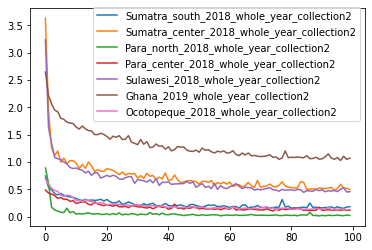

In [8]:
for dataset_idx in np.arange(len(datasets)):
    pl.plot(datasets_losses[dataset_idx], label=datasets_name[dataset_idx])
    
    print(datasets_losses[dataset_idx][-1])

pl.legend(bbox_to_anchor=(1, 1.03))

In [9]:
# remove last layer
model = Model(inputs=model.input, outputs=model.get_layer('last_input_layer').output)

# save model
model.save(os.path.join(MODEL_ROOT_PATH, 'multi_output_pretrained_with_reptile_v3.hdf5'))

### V4 (same as v2 but with different architecture and more iterations)

In [ ]:
image_width = 9
image_height = 9
image_depth = len(BANDS)

inputs = Input(shape=(image_width, image_height, image_depth))
layers = Rescaling(0.0000275, offset=0.2)(inputs)
layers = BatchNormalization()(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Flatten(name="last_pretrained_layer")(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.5, name="last_input_layer")(layers)

label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(LabelCategory), activation='softmax', name="category")(layers)

model = Model(inputs=inputs, outputs=[label_output, category_output])

In [122]:
# define hyperparameters
meta_step_size = 0.3
nb_iterations = 100
nb_inner_iters = 5
minibatches_size = 32

tasks_output_weights = [None for _ in np.arange(len(datasets))]
datasets_losses = [[] for _ in np.arange(len(datasets))]

for iteration in range(nb_iterations):
    print(f"iteration: {iteration + 1}/{nb_iterations}\n-----------------")
    
    for X_train, Y_train, steps_per_epoch, dataset_idx, nb_labels, nb_categories in iteration_tasks(datasets):
        # Create model with an new output layer for this task
        label_output = Dense(nb_labels, activation='softmax', name="label")(model.get_layer('last_input_layer').output)
        category_output = Dense(nb_categories, activation='softmax', name="category")(model.get_layer('last_input_layer').output)
        
        model = Model(inputs=inputs, outputs=[label_output, category_output])

        model.compile(optimizer='adam', loss={
            'label': categorical_focal_loss([[.25] * nb_labels]),
            'category': categorical_focal_loss([[.25] * nb_categories])
        })
        
        # If task as already been trained on, set back the previous weights of the output layer 
        if tasks_output_weights[dataset_idx] is not None :
            model.layers[-1].set_weights(tasks_output_weights[dataset_idx])        

        # Save old weights
        old_weights = model.get_weights()
        
        # Train
        model.fit(
            x=X_train,
            y=Y_train,
            epochs=nb_inner_iters,
            steps_per_epoch=steps_per_epoch,
            verbose=0
        )
        
        # Evaluate model on training data
        score = model.evaluate(X_train, Y_train, verbose=0)
        
        # Get new weights
        new_weights = model.get_weights()
        
        # Store dataset current loss and accuracies
        datasets_losses[dataset_idx].append(float(score[0]))
        
        print(f"- loss: {score[0]}")

        # Update weights
        for weight in range(len(new_weights)):
            current_meta_step_size = (1 - iteration / nb_iterations) * meta_step_size
            
            new_weights[weight] = old_weights[weight] + (
                (new_weights[weight] - old_weights[weight]) * current_meta_step_size
            )

        # After the meta-learning step, reload the newly-trained weights into the model.
        model.set_weights(new_weights)

        # Save task's output layer weights
        tasks_output_weights[dataset_idx] = model.layers[-1].get_weights()

iteration: 1/100
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.1733262538909912
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 0.35450491309165955
dataset index: 6, dataset iteration: 3/7, size: 59317
- loss: 0.08489242941141129
dataset index: 1, dataset iteration: 4/7, size: 2155
- loss: 0.4753372073173523
dataset index: 3, dataset iteration: 5/7, size: 20687
- loss: 0.0564441978931427
dataset index: 4, dataset iteration: 6/7, size: 3168
- loss: 0.1998240351676941
dataset index: 0, dataset iteration: 7/7, size: 11477
- loss: 0.054601386189460754
iteration: 2/100
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.03652673214673996
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.07070842385292053
dataset index: 0, dataset iteration: 3/7, size: 11477
- loss: 0.05737704038619995
dataset index: 1, dataset iteration: 4/7, size: 2155
- loss: 0.13999100029468536
dataset index: 5, dataset iteration: 

- loss: 0.06657908856868744
dataset index: 6, dataset iteration: 5/7, size: 59317
- loss: 0.02626553177833557
dataset index: 0, dataset iteration: 6/7, size: 11477
- loss: 0.022141726687550545
dataset index: 3, dataset iteration: 7/7, size: 20687
- loss: 0.023961704224348068
iteration: 15/100
-----------------
dataset index: 6, dataset iteration: 1/7, size: 59317
- loss: 0.03123648464679718
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 0.16032545268535614
dataset index: 1, dataset iteration: 3/7, size: 2155
- loss: 0.07088486850261688
dataset index: 3, dataset iteration: 4/7, size: 20687
- loss: 0.02106355130672455
dataset index: 2, dataset iteration: 5/7, size: 2234
- loss: 0.003750255098566413
dataset index: 0, dataset iteration: 6/7, size: 11477
- loss: 0.021637309342622757
dataset index: 4, dataset iteration: 7/7, size: 3168
- loss: 0.08043771237134933
iteration: 16/100
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.00375730893574655

- loss: 0.11908870190382004
dataset index: 4, dataset iteration: 2/7, size: 3168
- loss: 0.05358241870999336
dataset index: 3, dataset iteration: 3/7, size: 20687
- loss: 0.01734878122806549
dataset index: 0, dataset iteration: 4/7, size: 11477
- loss: 0.012921172194182873
dataset index: 6, dataset iteration: 5/7, size: 59317
- loss: 0.03065868839621544
dataset index: 2, dataset iteration: 6/7, size: 2234
- loss: 0.002406857442110777
dataset index: 1, dataset iteration: 7/7, size: 2155
- loss: 0.054089874029159546
iteration: 29/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 7356
- loss: 0.118763767182827
dataset index: 3, dataset iteration: 2/7, size: 20687
- loss: 0.014993728138506413
dataset index: 1, dataset iteration: 3/7, size: 2155
- loss: 0.05305251479148865
dataset index: 4, dataset iteration: 4/7, size: 3168
- loss: 0.05567634105682373
dataset index: 6, dataset iteration: 5/7, size: 59317
- loss: 0.019779151305556297
dataset index: 0, dataset iteration: 

- loss: 0.013049100525677204
dataset index: 3, dataset iteration: 6/7, size: 20687
- loss: 0.01649332605302334
dataset index: 1, dataset iteration: 7/7, size: 2155
- loss: 0.051605984568595886
iteration: 42/100
-----------------
dataset index: 0, dataset iteration: 1/7, size: 11477
- loss: 0.011559349484741688
dataset index: 1, dataset iteration: 2/7, size: 2155
- loss: 0.04204817861318588
dataset index: 5, dataset iteration: 3/7, size: 7356
- loss: 0.10389424115419388
dataset index: 6, dataset iteration: 4/7, size: 59317
- loss: 0.015097450464963913
dataset index: 3, dataset iteration: 5/7, size: 20687
- loss: 0.014159532263875008
dataset index: 4, dataset iteration: 6/7, size: 3168
- loss: 0.05199644714593887
dataset index: 2, dataset iteration: 7/7, size: 2234
- loss: 0.0017514099599793553
iteration: 43/100
-----------------
dataset index: 3, dataset iteration: 1/7, size: 20687
- loss: 0.016223035752773285
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 0.10228212177753

- loss: 0.0014614956453442574
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.012430869974195957
dataset index: 1, dataset iteration: 3/7, size: 2155
- loss: 0.04149259626865387
dataset index: 5, dataset iteration: 4/7, size: 7356
- loss: 0.09555163979530334
dataset index: 3, dataset iteration: 5/7, size: 20687
- loss: 0.017637405544519424
dataset index: 0, dataset iteration: 6/7, size: 11477
- loss: 0.012591999024152756
dataset index: 4, dataset iteration: 7/7, size: 3168
- loss: 0.04596911370754242
iteration: 56/100
-----------------
dataset index: 1, dataset iteration: 1/7, size: 2155
- loss: 0.03796115890145302
dataset index: 2, dataset iteration: 2/7, size: 2234
- loss: 0.001484358450397849
dataset index: 6, dataset iteration: 3/7, size: 59317
- loss: 0.011999118141829967
dataset index: 4, dataset iteration: 4/7, size: 3168
- loss: 0.03912641480565071
dataset index: 5, dataset iteration: 5/7, size: 7356
- loss: 0.09232189506292343
dataset index: 3, dataset iteratio

- loss: 0.08283180743455887
dataset index: 1, dataset iteration: 6/7, size: 2155
- loss: 0.04204994812607765
dataset index: 0, dataset iteration: 7/7, size: 11477
- loss: 0.010586964897811413
iteration: 69/100
-----------------
dataset index: 6, dataset iteration: 1/7, size: 59317
- loss: 0.009194089099764824
dataset index: 4, dataset iteration: 2/7, size: 3168
- loss: 0.0396132655441761
dataset index: 5, dataset iteration: 3/7, size: 7356
- loss: 0.08878783881664276
dataset index: 3, dataset iteration: 4/7, size: 20687
- loss: 0.011357954703271389
dataset index: 0, dataset iteration: 5/7, size: 11477
- loss: 0.009931188076734543
dataset index: 2, dataset iteration: 6/7, size: 2234
- loss: 0.0015977268340066075
dataset index: 1, dataset iteration: 7/7, size: 2155
- loss: 0.0401136614382267
iteration: 70/100
-----------------
dataset index: 0, dataset iteration: 1/7, size: 11477
- loss: 0.009654445573687553
dataset index: 3, dataset iteration: 2/7, size: 20687
- loss: 0.0130550255998969

- loss: 0.0016501425998285413
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 0.0863434448838234
dataset index: 4, dataset iteration: 3/7, size: 3168
- loss: 0.03521694988012314
dataset index: 6, dataset iteration: 4/7, size: 59317
- loss: 0.00981890968978405
dataset index: 1, dataset iteration: 5/7, size: 2155
- loss: 0.03733885660767555
dataset index: 3, dataset iteration: 6/7, size: 20687
- loss: 0.01271298248320818
dataset index: 0, dataset iteration: 7/7, size: 11477
- loss: 0.011386501602828503
iteration: 83/100
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.0016141087980940938
dataset index: 0, dataset iteration: 2/7, size: 11477
- loss: 0.007889414206147194
dataset index: 4, dataset iteration: 3/7, size: 3168
- loss: 0.041196491569280624
dataset index: 5, dataset iteration: 4/7, size: 7356
- loss: 0.07534658163785934
dataset index: 1, dataset iteration: 5/7, size: 2155
- loss: 0.03686968982219696
dataset index: 6, dataset iteration

- loss: 0.010566433891654015
dataset index: 0, dataset iteration: 6/7, size: 11477
- loss: 0.00933513231575489
dataset index: 5, dataset iteration: 7/7, size: 7356
- loss: 0.07768388837575912
iteration: 96/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 7356
- loss: 0.07781186699867249
dataset index: 2, dataset iteration: 2/7, size: 2234
- loss: 0.0014318772591650486
dataset index: 1, dataset iteration: 3/7, size: 2155
- loss: 0.03445581719279289
dataset index: 4, dataset iteration: 4/7, size: 3168
- loss: 0.035265278071165085
dataset index: 3, dataset iteration: 5/7, size: 20687
- loss: 0.010543999262154102
dataset index: 0, dataset iteration: 6/7, size: 11477
- loss: 0.007965258322656155
dataset index: 6, dataset iteration: 7/7, size: 59317
- loss: 0.011042344383895397
iteration: 97/100
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.0013984238030388951
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.0167381018400

0.009723404422402382
0.0319349467754364
0.0008102485444396734
0.009746655821800232
0.037632234394550323
0.0780508890748024
0.012609191238880157


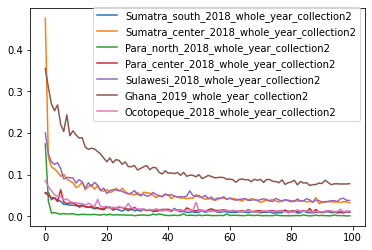

In [123]:
for dataset_idx in np.arange(len(datasets)):
    pl.plot(datasets_losses[dataset_idx], label=datasets_name[dataset_idx])
    
    print(datasets_losses[dataset_idx][-1])

pl.legend(bbox_to_anchor=(1, 1.03))

In [124]:
# remove last layer
model = Model(inputs=model.input, outputs=model.get_layer('last_pretrained_layer').output)

# save model
model.save(os.path.join(MODEL_ROOT_PATH, 'multi_output_pretrained_with_reptile_v4.hdf5'))

## V5 (V4 with january to april)

In [120]:
image_width = 9
image_height = 9
image_depth = len(BANDS)

inputs = Input(shape=(image_width, image_height, image_depth))
layers = Rescaling(0.0000275, offset=0.2)(inputs)
layers = BatchNormalization()(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Flatten(name="last_pretrained_layer")(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.5, name="last_input_layer")(layers)

label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(LabelCategory), activation='softmax', name="category")(layers)

model = Model(inputs=inputs, outputs=[label_output, category_output])

In [121]:
# define hyperparameters
meta_step_size = 0.3
nb_iterations = 100
nb_inner_iters = 5
minibatches_size = 32

tasks_output_weights = [None for _ in np.arange(len(datasets))]
datasets_losses = [[] for _ in np.arange(len(datasets))]

for iteration in range(nb_iterations):
    print(f"iteration: {iteration + 1}/{nb_iterations}\n-----------------")
    
    for X_train, Y_train, steps_per_epoch, dataset_idx, nb_labels, nb_categories in iteration_tasks(datasets):
        # Create model with an new output layer for this task
        label_output = Dense(nb_labels, activation='softmax', name="label")(model.get_layer('last_input_layer').output)
        category_output = Dense(nb_categories, activation='softmax', name="category")(model.get_layer('last_input_layer').output)
        
        model = Model(inputs=inputs, outputs=[label_output, category_output])

        model.compile(optimizer='adam', loss={
            'label': categorical_focal_loss([[.25] * nb_labels]),
            'category': categorical_focal_loss([[.25] * nb_categories])
        })
        
        # If task as already been trained on, set back the previous weights of the output layer 
        if tasks_output_weights[dataset_idx] is not None :
            model.layers[-1].set_weights(tasks_output_weights[dataset_idx])        

        # Save old weights
        old_weights = model.get_weights()
        
        # Train
        model.fit(
            x=X_train,
            y=Y_train,
            epochs=nb_inner_iters,
            steps_per_epoch=steps_per_epoch,
            verbose=0
        )
        
        # Evaluate model on training data
        score = model.evaluate(X_train, Y_train, verbose=0)
        
        # Get new weights
        new_weights = model.get_weights()
        
        # Store dataset current loss and accuracies
        datasets_losses[dataset_idx].append(float(score[0]))
        
        print(f"- loss: {score[0]}")

        # Update weights
        for weight in range(len(new_weights)):
            current_meta_step_size = (1 - iteration / nb_iterations) * meta_step_size
            
            new_weights[weight] = old_weights[weight] + (
                (new_weights[weight] - old_weights[weight]) * current_meta_step_size
            )

        # After the meta-learning step, reload the newly-trained weights into the model.
        model.set_weights(new_weights)

        # Save task's output layer weights
        tasks_output_weights[dataset_idx] = model.layers[-1].get_weights()

iteration: 1/100
-----------------
dataset index: 3, dataset iteration: 1/7, size: 14249
- loss: 0.12981067597866058
dataset index: 2, dataset iteration: 2/7, size: 1082
- loss: 0.29909607768058777
dataset index: 1, dataset iteration: 3/7, size: 1996
- loss: 0.5130977034568787
dataset index: 5, dataset iteration: 4/7, size: 6016
- loss: 0.3672771751880646
dataset index: 4, dataset iteration: 5/7, size: 2809
- loss: 0.31054437160491943
dataset index: 0, dataset iteration: 6/7, size: 11324
- loss: 0.10422814637422562
dataset index: 6, dataset iteration: 7/7, size: 58664
- loss: 0.09454740583896637
iteration: 2/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 6016
- loss: 0.3316636383533478
dataset index: 3, dataset iteration: 2/7, size: 14249
- loss: 0.1075245663523674
dataset index: 0, dataset iteration: 3/7, size: 11324
- loss: 0.08917511999607086
dataset index: 1, dataset iteration: 4/7, size: 1996
- loss: 0.16836412250995636
dataset index: 4, dataset iteration: 5

- loss: 0.09584635496139526
dataset index: 2, dataset iteration: 5/7, size: 1082
- loss: 0.007088313810527325
dataset index: 5, dataset iteration: 6/7, size: 6016
- loss: 0.22509105503559113
dataset index: 4, dataset iteration: 7/7, size: 2809
- loss: 0.11654082685709
iteration: 15/100
-----------------
dataset index: 0, dataset iteration: 1/7, size: 11324
- loss: 0.045215897262096405
dataset index: 1, dataset iteration: 2/7, size: 1996
- loss: 0.08365373313426971
dataset index: 4, dataset iteration: 3/7, size: 2809
- loss: 0.10901486128568649
dataset index: 2, dataset iteration: 4/7, size: 1082
- loss: 0.005647763609886169
dataset index: 3, dataset iteration: 5/7, size: 14249
- loss: 0.05220548063516617
dataset index: 6, dataset iteration: 6/7, size: 58664
- loss: 0.03485758602619171
dataset index: 5, dataset iteration: 7/7, size: 6016
- loss: 0.2208106517791748
iteration: 16/100
-----------------
dataset index: 6, dataset iteration: 1/7, size: 58664
- loss: 0.03549649938941002
datase

- loss: 0.024273913353681564
dataset index: 4, dataset iteration: 2/7, size: 2809
- loss: 0.10907553881406784
dataset index: 5, dataset iteration: 3/7, size: 6016
- loss: 0.17152075469493866
dataset index: 1, dataset iteration: 4/7, size: 1996
- loss: 0.08101338148117065
dataset index: 2, dataset iteration: 5/7, size: 1082
- loss: 0.007681863382458687
dataset index: 3, dataset iteration: 6/7, size: 14249
- loss: 0.03703185170888901
dataset index: 0, dataset iteration: 7/7, size: 11324
- loss: 0.04647596925497055
iteration: 29/100
-----------------
dataset index: 1, dataset iteration: 1/7, size: 1996
- loss: 0.06788614392280579
dataset index: 5, dataset iteration: 2/7, size: 6016
- loss: 0.1603141874074936
dataset index: 6, dataset iteration: 3/7, size: 58664
- loss: 0.025654606521129608
dataset index: 0, dataset iteration: 4/7, size: 11324
- loss: 0.042949602007865906
dataset index: 3, dataset iteration: 5/7, size: 14249
- loss: 0.04241858422756195
dataset index: 4, dataset iteration: 

- loss: 0.15681679546833038
dataset index: 2, dataset iteration: 6/7, size: 1082
- loss: 0.004522537812590599
dataset index: 1, dataset iteration: 7/7, size: 1996
- loss: 0.0806678906083107
iteration: 42/100
-----------------
dataset index: 4, dataset iteration: 1/7, size: 2809
- loss: 0.08666537702083588
dataset index: 0, dataset iteration: 2/7, size: 11324
- loss: 0.040140703320503235
dataset index: 3, dataset iteration: 3/7, size: 14249
- loss: 0.03580009192228317
dataset index: 2, dataset iteration: 4/7, size: 1082
- loss: 0.004403768107295036
dataset index: 6, dataset iteration: 5/7, size: 58664
- loss: 0.02215261198580265
dataset index: 5, dataset iteration: 6/7, size: 6016
- loss: 0.16154897212982178
dataset index: 1, dataset iteration: 7/7, size: 1996
- loss: 0.07559917122125626
iteration: 43/100
-----------------
dataset index: 0, dataset iteration: 1/7, size: 11324
- loss: 0.0365513414144516
dataset index: 2, dataset iteration: 2/7, size: 1082
- loss: 0.00471738213673234
data

- loss: 0.06455451995134354
dataset index: 2, dataset iteration: 3/7, size: 1082
- loss: 0.004256762098520994
dataset index: 3, dataset iteration: 4/7, size: 14249
- loss: 0.0317961722612381
dataset index: 0, dataset iteration: 5/7, size: 11324
- loss: 0.037281084805727005
dataset index: 5, dataset iteration: 6/7, size: 6016
- loss: 0.1422002911567688
dataset index: 4, dataset iteration: 7/7, size: 2809
- loss: 0.0819438248872757
iteration: 56/100
-----------------
dataset index: 1, dataset iteration: 1/7, size: 1996
- loss: 0.06085992977023125
dataset index: 6, dataset iteration: 2/7, size: 58664
- loss: 0.032782863825559616
dataset index: 2, dataset iteration: 3/7, size: 1082
- loss: 0.004039935301989317
dataset index: 5, dataset iteration: 4/7, size: 6016
- loss: 0.13647516071796417
dataset index: 4, dataset iteration: 5/7, size: 2809
- loss: 0.07705015689134598
dataset index: 0, dataset iteration: 6/7, size: 11324
- loss: 0.03647705540060997
dataset index: 3, dataset iteration: 7/7

- loss: 0.018055077642202377
dataset index: 3, dataset iteration: 7/7, size: 14249
- loss: 0.028305893763899803
iteration: 69/100
-----------------
dataset index: 0, dataset iteration: 1/7, size: 11324
- loss: 0.038961540907621384
dataset index: 6, dataset iteration: 2/7, size: 58664
- loss: 0.023856811225414276
dataset index: 3, dataset iteration: 3/7, size: 14249
- loss: 0.033213913440704346
dataset index: 1, dataset iteration: 4/7, size: 1996
- loss: 0.06577900052070618
dataset index: 5, dataset iteration: 5/7, size: 6016
- loss: 0.12902489304542542
dataset index: 2, dataset iteration: 6/7, size: 1082
- loss: 0.004107319284230471
dataset index: 4, dataset iteration: 7/7, size: 2809
- loss: 0.07460153102874756
iteration: 70/100
-----------------
dataset index: 1, dataset iteration: 1/7, size: 1996
- loss: 0.05306924134492874
dataset index: 6, dataset iteration: 2/7, size: 58664
- loss: 0.02069343440234661
dataset index: 5, dataset iteration: 3/7, size: 6016
- loss: 0.1320531666278839

- loss: 0.05481914058327675
dataset index: 5, dataset iteration: 3/7, size: 6016
- loss: 0.12352561205625534
dataset index: 3, dataset iteration: 4/7, size: 14249
- loss: 0.02861466445028782
dataset index: 2, dataset iteration: 5/7, size: 1082
- loss: 0.0044517070055007935
dataset index: 0, dataset iteration: 6/7, size: 11324
- loss: 0.03507407382130623
dataset index: 4, dataset iteration: 7/7, size: 2809
- loss: 0.07070399075746536
iteration: 83/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 6016
- loss: 0.12351857870817184
dataset index: 6, dataset iteration: 2/7, size: 58664
- loss: 0.022174591198563576
dataset index: 2, dataset iteration: 3/7, size: 1082
- loss: 0.00423874007537961
dataset index: 3, dataset iteration: 4/7, size: 14249
- loss: 0.026643862947821617
dataset index: 0, dataset iteration: 5/7, size: 11324
- loss: 0.030542107298970222
dataset index: 1, dataset iteration: 6/7, size: 1996
- loss: 0.05885975807905197
dataset index: 4, dataset iteration

- loss: 0.002549263881519437
dataset index: 5, dataset iteration: 7/7, size: 6016
- loss: 0.12315371632575989
iteration: 96/100
-----------------
dataset index: 3, dataset iteration: 1/7, size: 14249
- loss: 0.02632036618888378
dataset index: 5, dataset iteration: 2/7, size: 6016
- loss: 0.12898074090480804
dataset index: 2, dataset iteration: 3/7, size: 1082
- loss: 0.00459578912705183
dataset index: 6, dataset iteration: 4/7, size: 58664
- loss: 0.020678192377090454
dataset index: 4, dataset iteration: 5/7, size: 2809
- loss: 0.07198003679513931
dataset index: 1, dataset iteration: 6/7, size: 1996
- loss: 0.05291271582245827
dataset index: 0, dataset iteration: 7/7, size: 11324
- loss: 0.03389900550246239
iteration: 97/100
-----------------
dataset index: 1, dataset iteration: 1/7, size: 1996
- loss: 0.05528273805975914
dataset index: 0, dataset iteration: 2/7, size: 11324
- loss: 0.03259631618857384
dataset index: 4, dataset iteration: 3/7, size: 2809
- loss: 0.07166287302970886
dat

0.03510919585824013
0.05132366716861725
0.0028838985599577427
0.029106318950653076
0.07606888562440872
0.12167254090309143
0.01888221688568592


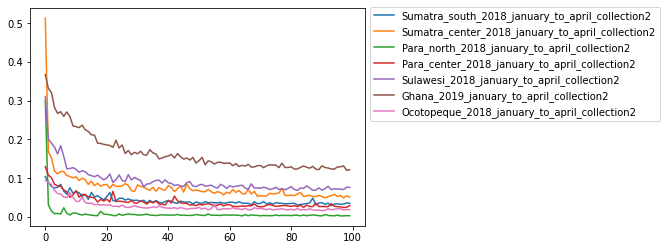

In [122]:
for dataset_idx in np.arange(len(datasets)):
    pl.plot(datasets_losses[dataset_idx], label=datasets_name[dataset_idx])
    
    print(datasets_losses[dataset_idx][-1])

pl.legend(bbox_to_anchor=(1, 1.03))

In [123]:
# remove last layer
model = Model(inputs=model.input, outputs=model.get_layer('last_pretrained_layer').output)

# save model
model.save(os.path.join(MODEL_ROOT_PATH, 'multi_output_pretrained_with_reptile_v5.hdf5'))

# Training with pretrained model

In [76]:
EPOCHS = 500
NB_TESTS = 4

labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.RUBBER,
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    Label.TEA,
    Label.RICE,     
    Label.DECIDUOUS_FOREST,
    Label.PINE_TREES,     
    Label.SHRUBLAND_BUSHLAND,     
    Label.GRASSLAND,     
    Label.SECONDARY_DEGRADED_FOREST,     
    Label.MINE_BARESOIL,
]

labels_names = [label.name for label in labels]
categories = pd.unique([category_from_label(label) for label in labels])

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [19]:
labels_coordinates = vietnam_labels_coordinates()

dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2018_whole_year_collection2/merged.tif')],
    labels_coordinates_list = [labels_coordinates],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2018 = make_dataset_from_raster_files(**dataset_args)

dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2019_whole_year_collection2/merged.tif')],
    labels_coordinates_list = [labels_coordinates],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2019 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2019)

In [78]:
# Create train sets
labels_train = labels_from_dataset(dataset_2018, labels_names)
categories_train = categories_from_label_set(labels, labels_train)

X_train = images_from_dataset(dataset_2018, bands)
y_train = [labels_train, categories_train]
Y_train = [
    to_categorical(labels_train, num_classes=len(labels_names)), 
    to_categorical(categories_train, num_classes=len(categories)), 
]

# Create test sets
labels_test = labels_from_dataset(dataset_2019, labels_names)
categories_test = categories_from_label_set(labels, labels_test)

X_test = images_from_dataset(dataset_2019, bands)
y_test = [labels_test, categories_test]
Y_test = [
    to_categorical(labels_test, num_classes=len(labels_names)), 
    to_categorical(categories_test, num_classes=len(categories)), 
]

In [10]:
model_name = "whole_year_2018_collection2_with_reptile_v4"

model = load_model(
    os.path.join(MODEL_ROOT_PATH, 'multi_output_pretrained_with_reptile_v4.hdf5'),
    custom_objects={
        'categorical_focal_loss_fixed': categorical_focal_loss
    }
)

layers = model.layers

# Freeze pretrained layers
for layer in layers:
    layer.trainable = False

# Add trainable layers before output layers
layers = Dense(128, activation='relu')(model.get_layer('last_pretrained_layer').output)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.25)(layers)

# Define output layers
label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(categories), activation='softmax', name="category")(layers)

# Create model
model = Model(inputs=model.input, outputs=[label_output, category_output])

model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels)]),
    'category': categorical_focal_loss([[.25] * len(categories)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 9, 9, 7)      0           input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 9, 9, 7)      28          rescaling_4[0][0]                
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 9, 9, 16)     464         batch_normalization_8[0][0]      
____________________________________________________________________________________________

In [11]:
# create data generators
train_datagen = ImageMultiOutputSequence(
    X_train, Y_train, ['label', 'category'], batch_size=32, augmentations=AUGMENTATIONS
)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=None,
    epochs=EPOCHS,
    steps_per_epoch=len(labels_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

trained_model.save(os.path.join(MODEL_ROOT_PATH, model_name + '.hdf5'))

Epoch 1/500
440/440 [==============================] - 2s 3ms/step - loss: 0.4890 - label_loss: 0.3755 - category_loss: 0.1135 - label_accuracy: 0.4166 - category_accuracy: 0.7458
Epoch 2/500
440/440 [==============================] - 1s 3ms/step - loss: 0.2572 - label_loss: 0.2001 - category_loss: 0.0570 - label_accuracy: 0.6107 - category_accuracy: 0.8486
Epoch 3/500
440/440 [==============================] - 1s 3ms/step - loss: 0.2155 - label_loss: 0.1679 - category_loss: 0.0476 - label_accuracy: 0.6617 - category_accuracy: 0.8679
Epoch 4/500
440/440 [==============================] - 1s 3ms/step - loss: 0.1951 - label_loss: 0.1521 - category_loss: 0.0430 - label_accuracy: 0.6803 - category_accuracy: 0.8769
Epoch 5/500
440/440 [==============================] - 1s 3ms/step - loss: 0.1809 - label_loss: 0.1420 - category_loss: 0.0389 - label_accuracy: 0.6878 - category_accuracy: 0.8855
Epoch 6/500
440/440 [==============================] - 1s 3ms/step - loss: 0.1690 - label_loss: 0.13

440/440 [==============================] - 1s 3ms/step - loss: 0.0724 - label_loss: 0.0584 - category_loss: 0.0141 - label_accuracy: 0.8110 - category_accuracy: 0.9430
Epoch 92/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0724 - label_loss: 0.0584 - category_loss: 0.0139 - label_accuracy: 0.8184 - category_accuracy: 0.9433
Epoch 93/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0740 - label_loss: 0.0590 - category_loss: 0.0149 - label_accuracy: 0.8161 - category_accuracy: 0.9409
Epoch 94/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0717 - label_loss: 0.0573 - category_loss: 0.0144 - label_accuracy: 0.8186 - category_accuracy: 0.9410
Epoch 95/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0740 - label_loss: 0.0592 - category_loss: 0.0148 - label_accuracy: 0.8146 - category_accuracy: 0.9426
Epoch 96/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0709 - label_loss: 0.0576 - ca

440/440 [==============================] - 1s 3ms/step - loss: 0.0605 - label_loss: 0.0493 - category_loss: 0.0112 - label_accuracy: 0.8291 - category_accuracy: 0.9502
Epoch 182/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0586 - label_loss: 0.0475 - category_loss: 0.0111 - label_accuracy: 0.8343 - category_accuracy: 0.9513
Epoch 183/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0639 - label_loss: 0.0516 - category_loss: 0.0123 - label_accuracy: 0.8283 - category_accuracy: 0.9478
Epoch 184/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0623 - label_loss: 0.0505 - category_loss: 0.0118 - label_accuracy: 0.8361 - category_accuracy: 0.9479
Epoch 185/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0599 - label_loss: 0.0481 - category_loss: 0.0118 - label_accuracy: 0.8371 - category_accuracy: 0.9510
Epoch 186/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0611 - label_loss: 0.0493

440/440 [==============================] - 1s 3ms/step - loss: 0.0568 - label_loss: 0.0458 - category_loss: 0.0110 - label_accuracy: 0.8458 - category_accuracy: 0.9557
Epoch 272/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0574 - label_loss: 0.0463 - category_loss: 0.0111 - label_accuracy: 0.8434 - category_accuracy: 0.9550
Epoch 273/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0571 - label_loss: 0.0458 - category_loss: 0.0113 - label_accuracy: 0.8452 - category_accuracy: 0.9550
Epoch 274/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0539 - label_loss: 0.0438 - category_loss: 0.0102 - label_accuracy: 0.8472 - category_accuracy: 0.9556
Epoch 275/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0572 - label_loss: 0.0461 - category_loss: 0.0111 - label_accuracy: 0.8453 - category_accuracy: 0.9528
Epoch 276/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0553 - label_loss: 0.0449

440/440 [==============================] - 1s 3ms/step - loss: 0.0557 - label_loss: 0.0453 - category_loss: 0.0104 - label_accuracy: 0.8420 - category_accuracy: 0.9549
Epoch 362/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0518 - label_loss: 0.0419 - category_loss: 0.0099 - label_accuracy: 0.8511 - category_accuracy: 0.9584
Epoch 363/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0530 - label_loss: 0.0427 - category_loss: 0.0103 - label_accuracy: 0.8508 - category_accuracy: 0.9583
Epoch 364/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0525 - label_loss: 0.0429 - category_loss: 0.0096 - label_accuracy: 0.8466 - category_accuracy: 0.9573
Epoch 365/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0531 - label_loss: 0.0433 - category_loss: 0.0098 - label_accuracy: 0.8474 - category_accuracy: 0.9566
Epoch 366/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0505 - label_loss: 0.0416

440/440 [==============================] - 1s 3ms/step - loss: 0.0518 - label_loss: 0.0423 - category_loss: 0.0096 - label_accuracy: 0.8544 - category_accuracy: 0.9614
Epoch 452/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0518 - label_loss: 0.0415 - category_loss: 0.0103 - label_accuracy: 0.8580 - category_accuracy: 0.9600
Epoch 453/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0519 - label_loss: 0.0418 - category_loss: 0.0100 - label_accuracy: 0.8596 - category_accuracy: 0.9584
Epoch 454/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0517 - label_loss: 0.0418 - category_loss: 0.0098 - label_accuracy: 0.8552 - category_accuracy: 0.9583
Epoch 455/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0500 - label_loss: 0.0403 - category_loss: 0.0096 - label_accuracy: 0.8556 - category_accuracy: 0.9613
Epoch 456/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0501 - label_loss: 0.0414

In [12]:
conf_matrices, accuracy, loss = evaluate_multi_output_model(trained_model, X_test, Y_test, y_test, [len(labels), len(categories)])

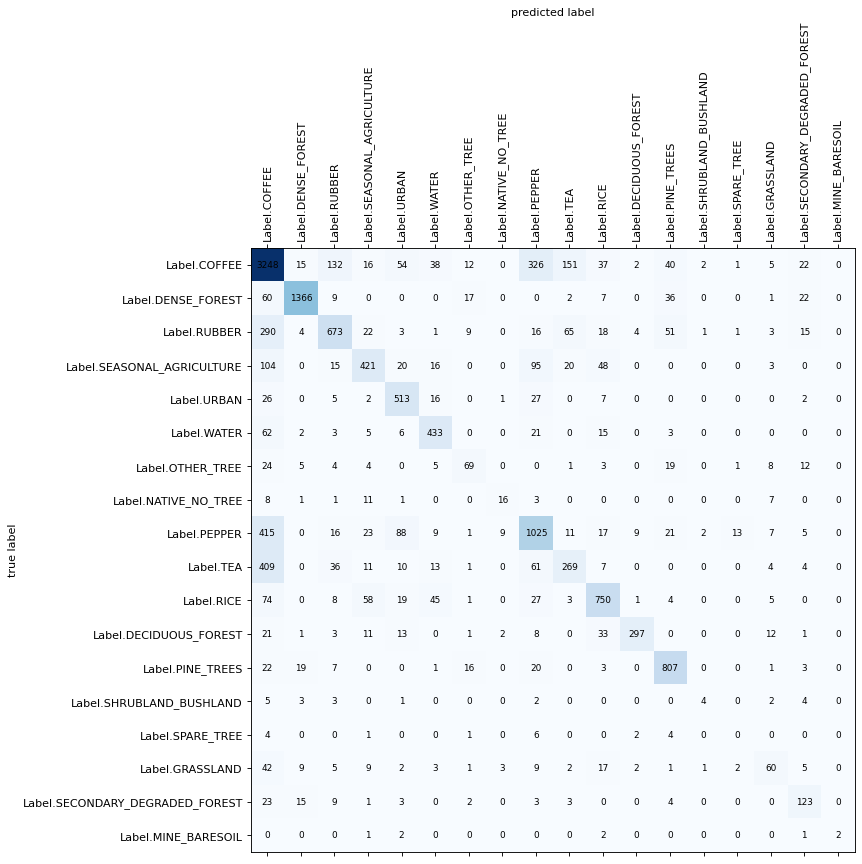

In [15]:
pl.figure(figsize=(12, 10), dpi=80)

plot_confusion_matrix(conf_matrices[0], labels)

In [16]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.67149059 0.94861111 0.72443488 0.70637584 0.69795918 0.74655172
 0.52671756 0.51612903 0.62158884 0.51043643 0.7780083  0.93690852
 0.81515152 0.4        0.         0.50847458 0.56164384 1.        ]
Mean precision:  0.6483601074676073

Recalls:  [0.79200195 0.89868421 0.57227891 0.56738544 0.85642738 0.78727273
 0.44516129 0.33333333 0.61340515 0.32606061 0.75376884 0.7369727
 0.89766407 0.16666667 0.         0.34682081 0.66129032 0.25      ]
Mean recall:  0.5558441343763002

F-Score:  [0.72678452 0.92297297 0.63942993 0.62929746 0.76911544 0.76637168
 0.48251748 0.40506329 0.61746988 0.39792899 0.76569678 0.825
 0.85442033 0.23529412        nan 0.41237113 0.60740741 0.4       ]
Mean f-score:  nan


/home/simon/Documents/HEIG/TB/scripts/notebooks/../src/statisticsUtils.py:106: RuntimeWarning: invalid value encountered in true_divide
  fscore = 2 * recall * precision / (recall + precision)


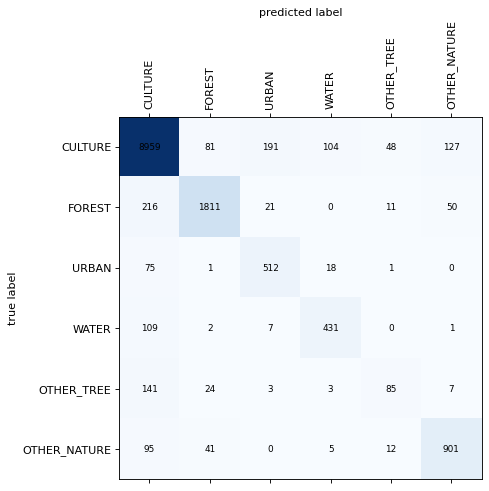

In [17]:
pl.figure(figsize=(8, 6), dpi=80)

plot_confusion_matrix(conf_matrices[1], [category.name for category in categories])

In [18]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.93371548 0.92397959 0.69754768 0.76827094 0.54140127 0.82965009]
Mean precision:  0.7824275105465324

Recalls:  [0.94206099 0.85870081 0.84349259 0.78363636 0.32319392 0.85483871]
Mean recall:  0.7676538951094978

F-Score:  [0.93786967 0.890145   0.76360925 0.77587759 0.4047619  0.84205607]
Mean f-score:  0.7690532467525387


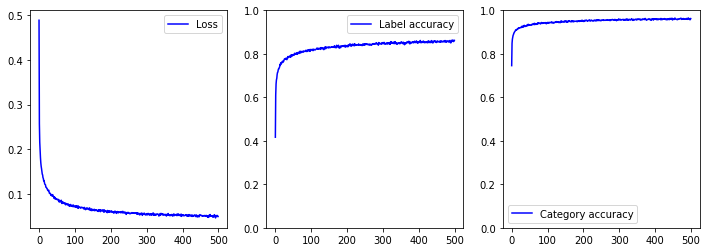

In [61]:
figure, axis = pl.subplots(1, 3, figsize=(12,4))
axis[0].plot(history.history['loss'], label='Loss', color="blue")
axis[0].legend()
axis[1].plot(history.history['label_accuracy'], label='Label accuracy', color="blue")
axis[1].set_ylim([0,1])
axis[1].legend()
axis[2].plot(history.history['category_accuracy'], label='Category accuracy', color="blue")
axis[2].set_ylim([0,1])
axis[2].legend()

### Without freezing layers

In [30]:
EPOCHS = 500

labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.RUBBER,
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    Label.TEA,
    Label.RICE,     
    Label.DECIDUOUS_FOREST,
    Label.PINE_TREES,     
    Label.SHRUBLAND_BUSHLAND,     
    Label.GRASSLAND,     
    Label.SECONDARY_DEGRADED_FOREST,     
    Label.MINE_BARESOIL,
]

labels_names = [label.name for label in labels]
categories = pd.unique([category_from_label(label) for label in labels])

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [31]:
labels_coordinates = vietnam_labels_coordinates()

dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2018_whole_year_collection2/merged.tif')],
    labels_coordinates_list = [labels_coordinates],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2018 = make_dataset_from_raster_files(**dataset_args)

dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2019_whole_year_collection2/merged.tif')],
    labels_coordinates_list = [labels_coordinates],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2019 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2019)

In [32]:
# Create train sets
labels_train = labels_from_dataset(dataset_2018, labels_names)
categories_train = categories_from_label_set(labels, labels_train)

X_train = images_from_dataset(dataset_2018, bands)
y_train = [labels_train, categories_train]
Y_train = [
    to_categorical(labels_train, num_classes=len(labels_names)), 
    to_categorical(categories_train, num_classes=len(categories)), 
]

# Create test sets
labels_test = labels_from_dataset(dataset_2019, labels_names)
categories_test = categories_from_label_set(labels, labels_test)

X_test = images_from_dataset(dataset_2019, bands)
y_test = [labels_test, categories_test]
Y_test = [
    to_categorical(labels_test, num_classes=len(labels_names)), 
    to_categorical(categories_test, num_classes=len(categories)), 
]

In [6]:
model_name = "whole_year_2018_collection2_with_reptile_v4"

model = load_model(
    os.path.join(MODEL_ROOT_PATH, 'multi_output_pretrained_with_reptile_v4.hdf5'),
    custom_objects={
        'categorical_focal_loss_fixed': categorical_focal_loss
    }
)

layers = model.layers

# Add trainable layers before output layers
layers = Dense(128, activation='relu')(model.get_layer('last_pretrained_layer').output)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.25)(layers)

# Define output layers
label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(categories), activation='softmax', name="category")(layers)

# Create model
model = Model(inputs=model.input, outputs=[label_output, category_output])

model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels)]),
    'category': categorical_focal_loss([[.25] * len(categories)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 9, 9, 7)      0           input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 9, 9, 7)      28          rescaling_4[0][0]                
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 9, 9, 16)     464         batch_normalization_8[0][0]      
______________________________________________________________________________________________

In [7]:
# create data generators
train_datagen = ImageMultiOutputSequence(
    X_train, Y_train, ['label', 'category'], batch_size=32, augmentations=AUGMENTATIONS
)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=None,
    epochs=EPOCHS,
    steps_per_epoch=len(labels_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

trained_model.save(os.path.join(MODEL_ROOT_PATH, model_name + '.hdf5'))

Epoch 1/500
440/440 [==============================] - 2s 4ms/step - loss: 0.6308 - label_loss: 0.4683 - category_loss: 0.1625 - label_accuracy: 0.2866 - category_accuracy: 0.6780
Epoch 2/500
440/440 [==============================] - 2s 4ms/step - loss: 0.3175 - label_loss: 0.2436 - category_loss: 0.0738 - label_accuracy: 0.5579 - category_accuracy: 0.8104
Epoch 3/500
440/440 [==============================] - 2s 4ms/step - loss: 0.2331 - label_loss: 0.1807 - category_loss: 0.0525 - label_accuracy: 0.6348 - category_accuracy: 0.8535
Epoch 4/500
440/440 [==============================] - 2s 4ms/step - loss: 0.2051 - label_loss: 0.1595 - category_loss: 0.0456 - label_accuracy: 0.6644 - category_accuracy: 0.8687
Epoch 5/500
440/440 [==============================] - 2s 4ms/step - loss: 0.1888 - label_loss: 0.1481 - category_loss: 0.0407 - label_accuracy: 0.6847 - category_accuracy: 0.8783
Epoch 6/500
440/440 [==============================] - 2s 4ms/step - loss: 0.1772 - label_loss: 0.13

440/440 [==============================] - 2s 4ms/step - loss: 0.0794 - label_loss: 0.0623 - category_loss: 0.0171 - label_accuracy: 0.8145 - category_accuracy: 0.9328
Epoch 92/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0795 - label_loss: 0.0622 - category_loss: 0.0173 - label_accuracy: 0.8178 - category_accuracy: 0.9320
Epoch 93/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0758 - label_loss: 0.0597 - category_loss: 0.0161 - label_accuracy: 0.8203 - category_accuracy: 0.9344
Epoch 94/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0764 - label_loss: 0.0599 - category_loss: 0.0165 - label_accuracy: 0.8194 - category_accuracy: 0.9339
Epoch 95/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0741 - label_loss: 0.0583 - category_loss: 0.0158 - label_accuracy: 0.8208 - category_accuracy: 0.9356
Epoch 96/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0748 - label_loss: 0.0589 - ca

440/440 [==============================] - 2s 4ms/step - loss: 0.0612 - label_loss: 0.0483 - category_loss: 0.0129 - label_accuracy: 0.8379 - category_accuracy: 0.9452
Epoch 182/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0648 - label_loss: 0.0509 - category_loss: 0.0139 - label_accuracy: 0.8386 - category_accuracy: 0.9415
Epoch 183/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0611 - label_loss: 0.0484 - category_loss: 0.0127 - label_accuracy: 0.8469 - category_accuracy: 0.9476
Epoch 184/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0620 - label_loss: 0.0489 - category_loss: 0.0130 - label_accuracy: 0.8420 - category_accuracy: 0.9444
Epoch 185/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0648 - label_loss: 0.0509 - category_loss: 0.0139 - label_accuracy: 0.8404 - category_accuracy: 0.9437
Epoch 186/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0620 - label_loss: 0.0490

440/440 [==============================] - 2s 5ms/step - loss: 0.0560 - label_loss: 0.0437 - category_loss: 0.0123 - label_accuracy: 0.8536 - category_accuracy: 0.9486
Epoch 272/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0547 - label_loss: 0.0427 - category_loss: 0.0120 - label_accuracy: 0.8575 - category_accuracy: 0.9513
Epoch 273/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0542 - label_loss: 0.0430 - category_loss: 0.0112 - label_accuracy: 0.8587 - category_accuracy: 0.9496
Epoch 274/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0579 - label_loss: 0.0453 - category_loss: 0.0126 - label_accuracy: 0.8535 - category_accuracy: 0.9469
Epoch 275/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0551 - label_loss: 0.0430 - category_loss: 0.0121 - label_accuracy: 0.8540 - category_accuracy: 0.9488
Epoch 276/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0521 - label_loss: 0.0408

440/440 [==============================] - 2s 4ms/step - loss: 0.0487 - label_loss: 0.0384 - category_loss: 0.0103 - label_accuracy: 0.8656 - category_accuracy: 0.9540
Epoch 362/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0499 - label_loss: 0.0390 - category_loss: 0.0109 - label_accuracy: 0.8648 - category_accuracy: 0.9543
Epoch 363/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0509 - label_loss: 0.0396 - category_loss: 0.0113 - label_accuracy: 0.8614 - category_accuracy: 0.9511
Epoch 364/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0494 - label_loss: 0.0387 - category_loss: 0.0106 - label_accuracy: 0.8626 - category_accuracy: 0.9532
Epoch 365/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0498 - label_loss: 0.0393 - category_loss: 0.0105 - label_accuracy: 0.8636 - category_accuracy: 0.9521
Epoch 366/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0493 - label_loss: 0.0388

440/440 [==============================] - 2s 4ms/step - loss: 0.0493 - label_loss: 0.0388 - category_loss: 0.0105 - label_accuracy: 0.8670 - category_accuracy: 0.9549
Epoch 452/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0475 - label_loss: 0.0371 - category_loss: 0.0104 - label_accuracy: 0.8690 - category_accuracy: 0.9544
Epoch 453/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0495 - label_loss: 0.0389 - category_loss: 0.0106 - label_accuracy: 0.8654 - category_accuracy: 0.9540
Epoch 454/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0476 - label_loss: 0.0372 - category_loss: 0.0104 - label_accuracy: 0.8671 - category_accuracy: 0.9561
Epoch 455/500
440/440 [==============================] - 3s 6ms/step - loss: 0.0476 - label_loss: 0.0373 - category_loss: 0.0102 - label_accuracy: 0.8677 - category_accuracy: 0.9552
Epoch 456/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0464 - label_loss: 0.0366

In [8]:
conf_matrices, accuracy, loss = evaluate_multi_output_model(trained_model, X_test, Y_test, y_test, [len(labels), len(categories)])

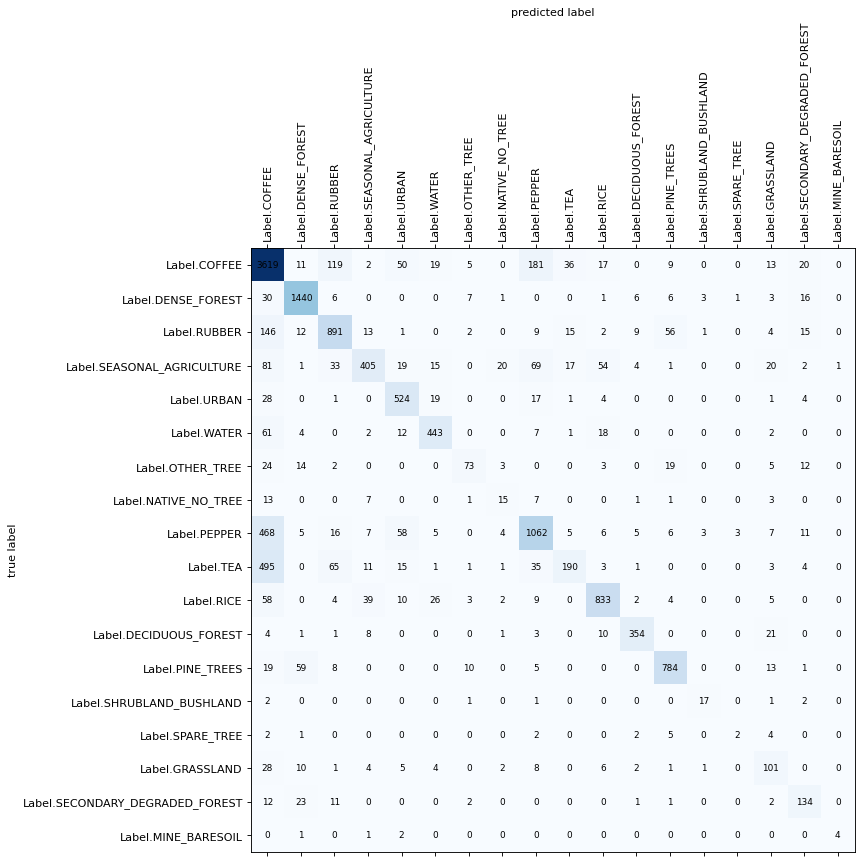

In [9]:
pl.figure(figsize=(12, 10), dpi=80)

plot_confusion_matrix(conf_matrices[0], labels)

In [10]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.71100196 0.9102402  0.76943005 0.81162325 0.75287356 0.83270677
 0.6952381  0.30612245 0.75053004 0.71698113 0.87042842 0.91472868
 0.87793953 0.68       0.33333333 0.48557692 0.60633484 0.8       ]
Mean precision:  0.7125049577233724

Recalls:  [0.88246769 0.94736842 0.75765306 0.5458221  0.87479132 0.80545455
 0.47096774 0.3125     0.63554758 0.23030303 0.83718593 0.87841191
 0.87208009 0.70833333 0.11111111 0.58381503 0.72043011 0.5       ]
Mean recall:  0.6485690554749227

F-Score:  [0.78750952 0.92843327 0.76349614 0.65269944 0.80926641 0.81885397
 0.56153846 0.30927835 0.6882696  0.34862385 0.85348361 0.89620253
 0.875      0.69387755 0.16666667 0.53018373 0.65847666 0.61538462]
Mean f-score:  0.6642913543913448


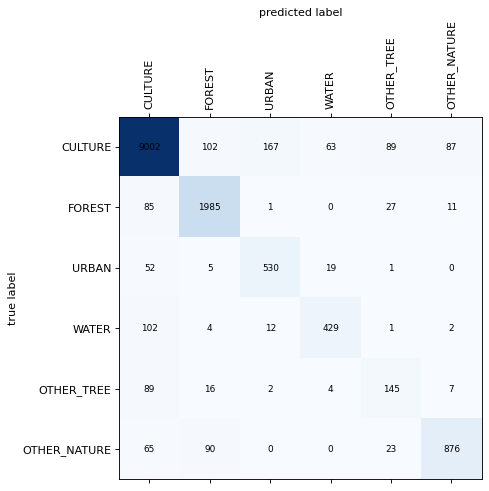

In [11]:
pl.figure(figsize=(8, 6), dpi=80)

plot_confusion_matrix(conf_matrices[1], [category.name for category in categories])

In [12]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.95816924 0.90145322 0.74438202 0.83300971 0.50699301 0.89114954]
Mean precision:  0.8058594572864802

Recalls:  [0.94658254 0.94120436 0.87314662 0.78       0.5513308  0.83111954]
Mean recall:  0.8205639787921122

F-Score:  [0.95234065 0.92090002 0.80363912 0.8056338  0.52823315 0.86008837]
Mean f-score:  0.811805852267958


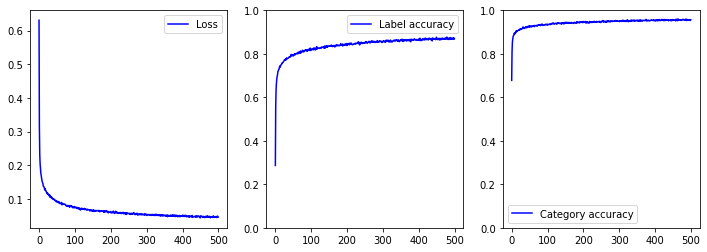

In [13]:
figure, axis = pl.subplots(1, 3, figsize=(12,4))
axis[0].plot(history.history['loss'], label='Loss', color="blue")
axis[0].legend()
axis[1].plot(history.history['label_accuracy'], label='Label accuracy', color="blue")
axis[1].set_ylim([0,1])
axis[1].legend()
axis[2].plot(history.history['category_accuracy'], label='Category accuracy', color="blue")
axis[2].set_ylim([0,1])
axis[2].legend()

### With January to April

In [14]:
EPOCHS = 500
NB_TESTS = 4

labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.RUBBER,
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    Label.TEA,
    Label.RICE,     
    Label.DECIDUOUS_FOREST,
    Label.PINE_TREES,     
    Label.SHRUBLAND_BUSHLAND,     
    Label.GRASSLAND,     
    Label.SECONDARY_DEGRADED_FOREST,     
    Label.MINE_BARESOIL,
]

labels_names = [label.name for label in labels]
categories = pd.unique([category_from_label(label) for label in labels])

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [15]:
labels_coordinates = vietnam_labels_coordinates()

dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2018_january_to_april_collection2/merged.tif')],
    labels_coordinates_list = [labels_coordinates],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2018 = make_dataset_from_raster_files(**dataset_args)

dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2019_january_to_april_collection2/merged.tif')],
    labels_coordinates_list = [labels_coordinates],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2019 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2019)

In [16]:
# Create train sets
labels_train = labels_from_dataset(dataset_2018, labels_names)
categories_train = categories_from_label_set(labels, labels_train)

X_train = images_from_dataset(dataset_2018, bands)
y_train = [labels_train, categories_train]
Y_train = [
    to_categorical(labels_train, num_classes=len(labels_names)), 
    to_categorical(categories_train, num_classes=len(categories)), 
]

# Create test sets
labels_test = labels_from_dataset(dataset_2019, labels_names)
categories_test = categories_from_label_set(labels, labels_test)

X_test = images_from_dataset(dataset_2019, bands)
y_test = [labels_test, categories_test]
Y_test = [
    to_categorical(labels_test, num_classes=len(labels_names)), 
    to_categorical(categories_test, num_classes=len(categories)), 
]

In [17]:
model_name = "january_to_april_2018_collection2_with_reptile_v5"

model = load_model(
    os.path.join(MODEL_ROOT_PATH, 'multi_output_pretrained_with_reptile_v5.hdf5'),
    custom_objects={
        'categorical_focal_loss_fixed': categorical_focal_loss
    }
)

layers = model.layers

# Add trainable layers before output layers
layers = Dense(128, activation='relu')(model.get_layer('last_pretrained_layer').output)
layers = Dropout(0.25)(layers)

# Define output layers
label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(categories), activation='softmax', name="category")(layers)

# Create model
model = Model(inputs=model.input, outputs=[label_output, category_output])

model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels)]),
    'category': categorical_focal_loss([[.25] * len(categories)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 9, 9, 7)      0           input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 9, 9, 7)      28          rescaling_4[0][0]                
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 9, 9, 16)     464         batch_normalization_12[0][0]     
____________________________________________________________________________________________

In [18]:
# create data generators
train_datagen = ImageMultiOutputSequence(
    X_train, Y_train, ['label', 'category'], batch_size=32, augmentations=AUGMENTATIONS
)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=None,
    epochs=EPOCHS,
    steps_per_epoch=len(labels_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

trained_model.save(os.path.join(MODEL_ROOT_PATH, model_name + '.hdf5'))

Epoch 1/500
440/440 [==============================] - 2s 4ms/step - loss: 0.6395 - label_loss: 0.4783 - category_loss: 0.1612 - label_accuracy: 0.3035 - category_accuracy: 0.6765
Epoch 2/500
440/440 [==============================] - 2s 4ms/step - loss: 0.3487 - label_loss: 0.2668 - category_loss: 0.0819 - label_accuracy: 0.5232 - category_accuracy: 0.7913
Epoch 3/500
440/440 [==============================] - 2s 4ms/step - loss: 0.2623 - label_loss: 0.2028 - category_loss: 0.0596 - label_accuracy: 0.6152 - category_accuracy: 0.8374
Epoch 4/500
440/440 [==============================] - 2s 4ms/step - loss: 0.2350 - label_loss: 0.1824 - category_loss: 0.0526 - label_accuracy: 0.6410 - category_accuracy: 0.8518
Epoch 5/500
440/440 [==============================] - 2s 4ms/step - loss: 0.2186 - label_loss: 0.1706 - category_loss: 0.0480 - label_accuracy: 0.6554 - category_accuracy: 0.8587
Epoch 6/500
440/440 [==============================] - 2s 4ms/step - loss: 0.2078 - label_loss: 0.16

440/440 [==============================] - 2s 5ms/step - loss: 0.1116 - label_loss: 0.0864 - category_loss: 0.0252 - label_accuracy: 0.7750 - category_accuracy: 0.9102
Epoch 92/500
440/440 [==============================] - 2s 5ms/step - loss: 0.1095 - label_loss: 0.0848 - category_loss: 0.0247 - label_accuracy: 0.7733 - category_accuracy: 0.9117
Epoch 93/500
440/440 [==============================] - 3s 6ms/step - loss: 0.1082 - label_loss: 0.0841 - category_loss: 0.0241 - label_accuracy: 0.7767 - category_accuracy: 0.9095
Epoch 94/500
440/440 [==============================] - 2s 4ms/step - loss: 0.1089 - label_loss: 0.0845 - category_loss: 0.0245 - label_accuracy: 0.7736 - category_accuracy: 0.9135
Epoch 95/500
440/440 [==============================] - 2s 4ms/step - loss: 0.1088 - label_loss: 0.0846 - category_loss: 0.0242 - label_accuracy: 0.7768 - category_accuracy: 0.9126
Epoch 96/500
440/440 [==============================] - 2s 4ms/step - loss: 0.1094 - label_loss: 0.0846 - ca

440/440 [==============================] - 2s 4ms/step - loss: 0.0922 - label_loss: 0.0721 - category_loss: 0.0201 - label_accuracy: 0.7978 - category_accuracy: 0.9225
Epoch 182/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0910 - label_loss: 0.0706 - category_loss: 0.0204 - label_accuracy: 0.8018 - category_accuracy: 0.9204
Epoch 183/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0958 - label_loss: 0.0753 - category_loss: 0.0205 - label_accuracy: 0.7910 - category_accuracy: 0.9202
Epoch 184/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0922 - label_loss: 0.0716 - category_loss: 0.0206 - label_accuracy: 0.8010 - category_accuracy: 0.9217
Epoch 185/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0914 - label_loss: 0.0711 - category_loss: 0.0203 - label_accuracy: 0.7982 - category_accuracy: 0.9212
Epoch 186/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0899 - label_loss: 0.0699

440/440 [==============================] - 2s 5ms/step - loss: 0.0864 - label_loss: 0.0677 - category_loss: 0.0186 - label_accuracy: 0.8032 - category_accuracy: 0.9245
Epoch 272/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0843 - label_loss: 0.0661 - category_loss: 0.0182 - label_accuracy: 0.8086 - category_accuracy: 0.9288
Epoch 273/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0841 - label_loss: 0.0665 - category_loss: 0.0176 - label_accuracy: 0.8033 - category_accuracy: 0.9258
Epoch 274/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0851 - label_loss: 0.0661 - category_loss: 0.0190 - label_accuracy: 0.8054 - category_accuracy: 0.9250
Epoch 275/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0869 - label_loss: 0.0672 - category_loss: 0.0197 - label_accuracy: 0.8113 - category_accuracy: 0.9281
Epoch 276/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0838 - label_loss: 0.0650

440/440 [==============================] - 2s 4ms/step - loss: 0.0844 - label_loss: 0.0653 - category_loss: 0.0191 - label_accuracy: 0.8144 - category_accuracy: 0.9287
Epoch 362/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0788 - label_loss: 0.0616 - category_loss: 0.0172 - label_accuracy: 0.8149 - category_accuracy: 0.9295
Epoch 363/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0805 - label_loss: 0.0627 - category_loss: 0.0178 - label_accuracy: 0.8148 - category_accuracy: 0.9293
Epoch 364/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0818 - label_loss: 0.0633 - category_loss: 0.0185 - label_accuracy: 0.8181 - category_accuracy: 0.9274
Epoch 365/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0810 - label_loss: 0.0629 - category_loss: 0.0181 - label_accuracy: 0.8164 - category_accuracy: 0.9281
Epoch 366/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0788 - label_loss: 0.0612

440/440 [==============================] - 2s 4ms/step - loss: 0.0779 - label_loss: 0.0606 - category_loss: 0.0173 - label_accuracy: 0.8225 - category_accuracy: 0.9304
Epoch 452/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0763 - label_loss: 0.0592 - category_loss: 0.0171 - label_accuracy: 0.8241 - category_accuracy: 0.9297
Epoch 453/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0753 - label_loss: 0.0587 - category_loss: 0.0165 - label_accuracy: 0.8227 - category_accuracy: 0.9327
Epoch 454/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0797 - label_loss: 0.0623 - category_loss: 0.0174 - label_accuracy: 0.8183 - category_accuracy: 0.9302
Epoch 455/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0791 - label_loss: 0.0618 - category_loss: 0.0172 - label_accuracy: 0.8161 - category_accuracy: 0.9329
Epoch 456/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0746 - label_loss: 0.0584

In [19]:
conf_matrices, accuracy, loss = evaluate_multi_output_model(trained_model, X_test, Y_test, y_test, [len(labels), len(categories)])

In [20]:
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.17001980543136597
accuracy:  0.13545697927474976


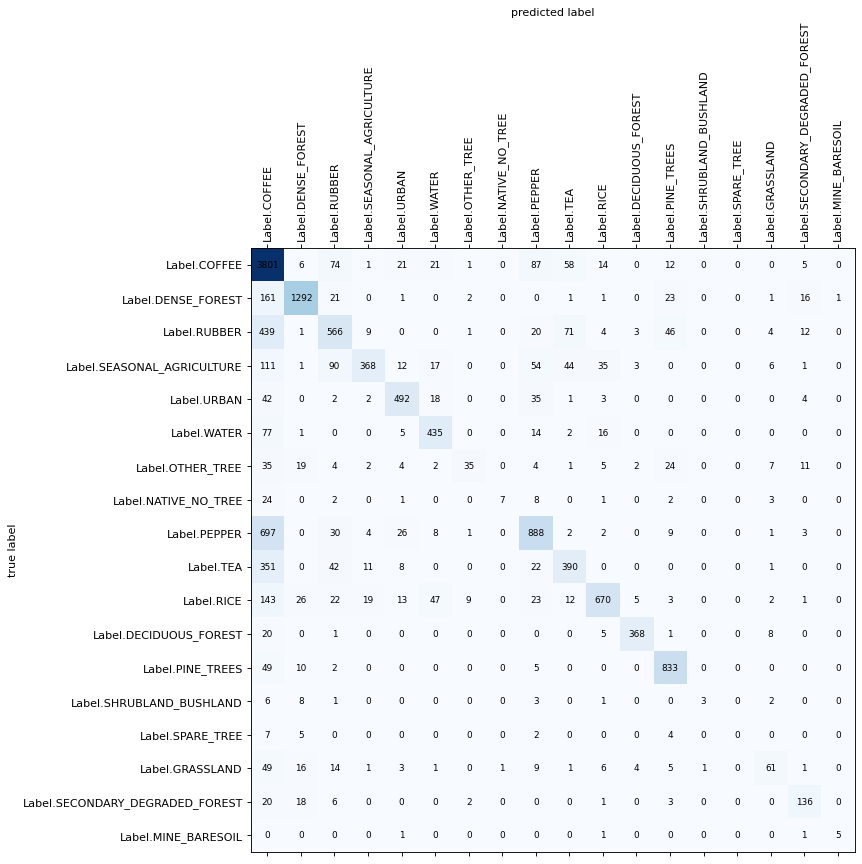

In [21]:
pl.figure(figsize=(12, 10), dpi=80)

plot_confusion_matrix(conf_matrices[0], labels)

In [22]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.63013926 0.92088382 0.64538198 0.882494   0.83816014 0.79234973
 0.68627451 0.875      0.75638842 0.66895369 0.87581699 0.95584416
 0.86321244 0.75              nan 0.63541667 0.71204188 0.83333333]
Mean precision:  nan

Recalls:  [0.92684711 0.85       0.48129252 0.49595687 0.82136895 0.79090909
 0.22580645 0.14583333 0.53141831 0.47272727 0.67336683 0.91315136
 0.92658509 0.125      0.         0.35260116 0.7311828  0.625     ]
Mean recall:  0.5605026197363006

F-Score:  [0.75022205 0.88402326 0.55138821 0.6350302  0.8296796  0.79162875
 0.33980583 0.25       0.62425308 0.55397727 0.76136364 0.93401015
 0.89377682 0.21428571        nan 0.4535316  0.72148541 0.71428571]
Mean f-score:  nan


/home/simon/Documents/HEIG/TB/scripts/notebooks/../src/statisticsUtils.py:104: RuntimeWarning: invalid value encountered in true_divide
  precision = tp / (tp + fp)


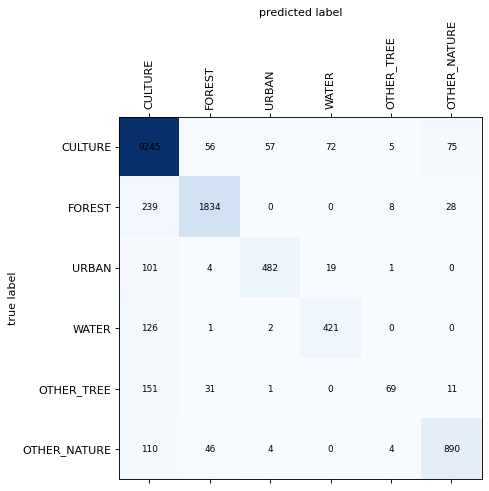

In [23]:
pl.figure(figsize=(8, 6), dpi=80)

plot_confusion_matrix(conf_matrices[1], [category.name for category in categories])

In [24]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.92709587 0.93002028 0.88278388 0.82226562 0.79310345 0.88645418]
Mean precision:  0.8736205486223242

Recalls:  [0.9721346  0.86960645 0.79406919 0.76545455 0.26235741 0.84440228]
Mean recall:  0.7513374122351837

F-Score:  [0.9490812  0.89879931 0.83607979 0.79284369 0.39428571 0.8649174 ]
Mean f-score:  0.789334518311172


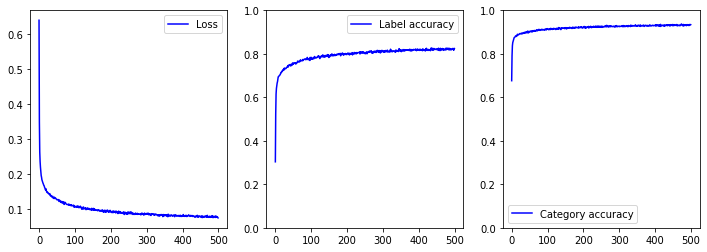

In [25]:
figure, axis = pl.subplots(1, 3, figsize=(12,4))
axis[0].plot(history.history['loss'], label='Loss', color="blue")
axis[0].legend()
axis[1].plot(history.history['label_accuracy'], label='Label accuracy', color="blue")
axis[1].set_ylim([0,1])
axis[1].legend()
axis[2].plot(history.history['category_accuracy'], label='Category accuracy', color="blue")
axis[2].set_ylim([0,1])
axis[2].legend()

### Final reptile model with cross validation

In [3]:
EPOCHS = 2000
NB_TESTS = 4

labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.RUBBER,
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    Label.TEA,
    Label.RICE,     
    Label.DECIDUOUS_FOREST,
    Label.PINE_TREES,     
    Label.SHRUBLAND_BUSHLAND,     
    Label.GRASSLAND,     
    Label.SECONDARY_DEGRADED_FOREST,     
    Label.MINE_BARESOIL,
]

labels_names = [label.name for label in labels]
categories = pd.unique([category_from_label(label) for label in labels])

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [4]:
labels_coordinates = vietnam_labels_coordinates()

dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2018_whole_year_collection2/merged.tif')],
    labels_coordinates_list = [labels_coordinates],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset = make_dataset_from_raster_files(**dataset_args)

np.random.shuffle(dataset)

In [5]:
model_name = "final_reptile_model"

model = load_model(
    os.path.join(MODEL_ROOT_PATH, 'multi_output_pretrained_with_reptile_v4.hdf5'),
    custom_objects={
        'categorical_focal_loss_fixed': categorical_focal_loss
    }
)

layers = model.layers

# Add trainable layers before output layers
layers = Dense(128, activation='relu')(model.get_layer('last_pretrained_layer').output)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.5)(layers)

# Define output layers
label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(categories), activation='softmax', name="category")(layers)

# Create model
model = Model(inputs=model.input, outputs=[label_output, category_output])

model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels)]),
    'category': categorical_focal_loss([[.25] * len(categories)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 9, 9, 7)      0           input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 9, 9, 7)      28          rescaling_4[0][0]                
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 9, 9, 16)     464         batch_normalization_8[0][0]      
______________________________________________________________________________________________

In [6]:
mean_loss, mean_accuracy, histories, conf_matrices = cross_validation_multi_output_model(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name, categories=categories)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 9, 9, 7)      0           input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 9, 9, 7)      28          rescaling_4[0][0]                
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 9, 9, 16)     464         batch_normalization_8[0][0]      
______________________________________________________________________________________________

351/351 [==============================] - 1s 4ms/step - loss: 0.1938 - label_loss: 0.1516 - category_loss: 0.0422 - label_accuracy: 0.6771 - category_accuracy: 0.8679 - val_loss: 0.1625 - val_label_loss: 0.1278 - val_category_loss: 0.0347 - val_label_accuracy: 0.7144 - val_category_accuracy: 0.8838
Epoch 13/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1877 - label_loss: 0.1466 - category_loss: 0.0412 - label_accuracy: 0.6829 - category_accuracy: 0.8716 - val_loss: 0.1473 - val_label_loss: 0.1175 - val_category_loss: 0.0298 - val_label_accuracy: 0.7361 - val_category_accuracy: 0.9059
Epoch 14/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1866 - label_loss: 0.1451 - category_loss: 0.0415 - label_accuracy: 0.6864 - category_accuracy: 0.8751 - val_loss: 0.1430 - val_label_loss: 0.1130 - val_category_loss: 0.0299 - val_label_accuracy: 0.7290 - val_category_accuracy: 0.8959
Epoch 15/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1373 - label_loss: 0.1069 - category_loss: 0.0304 - label_accuracy: 0.7437 - category_accuracy: 0.9004 - val_loss: 0.1136 - val_label_loss: 0.0908 - val_category_loss: 0.0228 - val_label_accuracy: 0.7631 - val_category_accuracy: 0.9176
Epoch 39/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1387 - label_loss: 0.1087 - category_loss: 0.0301 - label_accuracy: 0.7431 - category_accuracy: 0.8996 - val_loss: 0.1213 - val_label_loss: 0.0953 - val_category_loss: 0.0259 - val_label_accuracy: 0.7687 - val_category_accuracy: 0.9098
Epoch 40/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1319 - label_loss: 0.1034 - category_loss: 0.0285 - label_accuracy: 0.7492 - category_accuracy: 0.9046 - val_loss: 0.1181 - val_label_loss: 0.0947 - val_category_loss: 0.0234 - val_label_accuracy: 0.7666 - val_category_accuracy: 0.9215
Epoch 41/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1174 - label_loss: 0.0925 - category_loss: 0.0249 - label_accuracy: 0.7640 - category_accuracy: 0.9110 - val_loss: 0.1145 - val_label_loss: 0.0899 - val_category_loss: 0.0246 - val_label_accuracy: 0.7808 - val_category_accuracy: 0.9179
Epoch 65/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1187 - label_loss: 0.0932 - category_loss: 0.0256 - label_accuracy: 0.7657 - category_accuracy: 0.9071 - val_loss: 0.1086 - val_label_loss: 0.0841 - val_category_loss: 0.0245 - val_label_accuracy: 0.7911 - val_category_accuracy: 0.9215
Epoch 66/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1161 - label_loss: 0.0906 - category_loss: 0.0255 - label_accuracy: 0.7634 - category_accuracy: 0.9111 - val_loss: 0.1130 - val_label_loss: 0.0893 - val_category_loss: 0.0237 - val_label_accuracy: 0.7844 - val_category_accuracy: 0.9208
Epoch 67/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1063 - label_loss: 0.0836 - category_loss: 0.0228 - label_accuracy: 0.7787 - category_accuracy: 0.9168 - val_loss: 0.1067 - val_label_loss: 0.0836 - val_category_loss: 0.0231 - val_label_accuracy: 0.7964 - val_category_accuracy: 0.9229
Epoch 91/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1076 - label_loss: 0.0840 - category_loss: 0.0237 - label_accuracy: 0.7694 - category_accuracy: 0.9128 - val_loss: 0.1095 - val_label_loss: 0.0858 - val_category_loss: 0.0238 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.9258
Epoch 92/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1046 - label_loss: 0.0824 - category_loss: 0.0222 - label_accuracy: 0.7734 - category_accuracy: 0.9126 - val_loss: 0.1086 - val_label_loss: 0.0840 - val_category_loss: 0.0247 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9201
Epoch 93/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 2s 4ms/step - loss: 0.1002 - label_loss: 0.0788 - category_loss: 0.0213 - label_accuracy: 0.7883 - category_accuracy: 0.9187 - val_loss: 0.1088 - val_label_loss: 0.0853 - val_category_loss: 0.0236 - val_label_accuracy: 0.7812 - val_category_accuracy: 0.9279
Epoch 117/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0985 - label_loss: 0.0776 - category_loss: 0.0209 - label_accuracy: 0.7856 - category_accuracy: 0.9187 - val_loss: 0.1039 - val_label_loss: 0.0799 - val_category_loss: 0.0240 - val_label_accuracy: 0.8057 - val_category_accuracy: 0.9300
Epoch 118/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1000 - label_loss: 0.0787 - category_loss: 0.0213 - label_accuracy: 0.7817 - category_accuracy: 0.9196 - val_loss: 0.1020 - val_label_loss: 0.0796 - val_category_loss: 0.0224 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9325
Epoch 119/2000
351/351 [==============================] - 1s 4ms/st

Epoch 142/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0928 - label_loss: 0.0734 - category_loss: 0.0193 - label_accuracy: 0.7911 - category_accuracy: 0.9209 - val_loss: 0.1043 - val_label_loss: 0.0801 - val_category_loss: 0.0242 - val_label_accuracy: 0.8032 - val_category_accuracy: 0.9236
Epoch 143/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0914 - label_loss: 0.0719 - category_loss: 0.0195 - label_accuracy: 0.7948 - category_accuracy: 0.9283 - val_loss: 0.1025 - val_label_loss: 0.0797 - val_category_loss: 0.0228 - val_label_accuracy: 0.7982 - val_category_accuracy: 0.9268
Epoch 144/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0930 - label_loss: 0.0732 - category_loss: 0.0198 - label_accuracy: 0.7959 - category_accuracy: 0.9228 - val_loss: 0.1142 - val_label_loss: 0.0854 - val_category_loss: 0.0288 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.9155
Epoch 145/2000
351/351 [============================

Epoch 168/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0877 - label_loss: 0.0694 - category_loss: 0.0183 - label_accuracy: 0.7993 - category_accuracy: 0.9282 - val_loss: 0.0969 - val_label_loss: 0.0748 - val_category_loss: 0.0221 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9261
Epoch 169/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0861 - label_loss: 0.0682 - category_loss: 0.0179 - label_accuracy: 0.7958 - category_accuracy: 0.9252 - val_loss: 0.1100 - val_label_loss: 0.0845 - val_category_loss: 0.0254 - val_label_accuracy: 0.7947 - val_category_accuracy: 0.9293
Epoch 170/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0873 - label_loss: 0.0686 - category_loss: 0.0186 - label_accuracy: 0.8039 - category_accuracy: 0.9299 - val_loss: 0.1071 - val_label_loss: 0.0840 - val_category_loss: 0.0232 - val_label_accuracy: 0.7911 - val_category_accuracy: 0.9258
Epoch 171/2000
351/351 [============================

Epoch 194/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0837 - label_loss: 0.0663 - category_loss: 0.0174 - label_accuracy: 0.8012 - category_accuracy: 0.9287 - val_loss: 0.0964 - val_label_loss: 0.0743 - val_category_loss: 0.0221 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9282
Epoch 195/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0823 - label_loss: 0.0652 - category_loss: 0.0170 - label_accuracy: 0.8039 - category_accuracy: 0.9295 - val_loss: 0.1004 - val_label_loss: 0.0781 - val_category_loss: 0.0223 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9297
Epoch 196/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0839 - label_loss: 0.0666 - category_loss: 0.0173 - label_accuracy: 0.8029 - category_accuracy: 0.9289 - val_loss: 0.1085 - val_label_loss: 0.0838 - val_category_loss: 0.0248 - val_label_accuracy: 0.7915 - val_category_accuracy: 0.9282
Epoch 197/2000
351/351 [============================

Epoch 220/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0804 - label_loss: 0.0638 - category_loss: 0.0166 - label_accuracy: 0.8072 - category_accuracy: 0.9292 - val_loss: 0.1196 - val_label_loss: 0.0918 - val_category_loss: 0.0278 - val_label_accuracy: 0.7968 - val_category_accuracy: 0.9279
Epoch 221/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0800 - label_loss: 0.0631 - category_loss: 0.0168 - label_accuracy: 0.8056 - category_accuracy: 0.9290 - val_loss: 0.1063 - val_label_loss: 0.0820 - val_category_loss: 0.0243 - val_label_accuracy: 0.8050 - val_category_accuracy: 0.9318
Epoch 222/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0804 - label_loss: 0.0631 - category_loss: 0.0173 - label_accuracy: 0.8107 - category_accuracy: 0.9323 - val_loss: 0.1025 - val_label_loss: 0.0792 - val_category_loss: 0.0233 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9279
Epoch 223/2000
351/351 [============================

Epoch 246/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0785 - label_loss: 0.0620 - category_loss: 0.0165 - label_accuracy: 0.8094 - category_accuracy: 0.9347 - val_loss: 0.1103 - val_label_loss: 0.0840 - val_category_loss: 0.0263 - val_label_accuracy: 0.7993 - val_category_accuracy: 0.9233
Epoch 247/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0757 - label_loss: 0.0601 - category_loss: 0.0156 - label_accuracy: 0.8122 - category_accuracy: 0.9353 - val_loss: 0.1002 - val_label_loss: 0.0772 - val_category_loss: 0.0230 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9336
Epoch 248/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0781 - label_loss: 0.0620 - category_loss: 0.0161 - label_accuracy: 0.8131 - category_accuracy: 0.9338 - val_loss: 0.1009 - val_label_loss: 0.0766 - val_category_loss: 0.0243 - val_label_accuracy: 0.8163 - val_category_accuracy: 0.9343
Epoch 249/2000
351/351 [============================

Epoch 272/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0761 - label_loss: 0.0606 - category_loss: 0.0155 - label_accuracy: 0.8150 - category_accuracy: 0.9338 - val_loss: 0.1035 - val_label_loss: 0.0794 - val_category_loss: 0.0241 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9297
Epoch 273/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0747 - label_loss: 0.0592 - category_loss: 0.0155 - label_accuracy: 0.8164 - category_accuracy: 0.9355 - val_loss: 0.0990 - val_label_loss: 0.0749 - val_category_loss: 0.0241 - val_label_accuracy: 0.8188 - val_category_accuracy: 0.9297
Epoch 274/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0731 - label_loss: 0.0580 - category_loss: 0.0151 - label_accuracy: 0.8149 - category_accuracy: 0.9346 - val_loss: 0.1042 - val_label_loss: 0.0786 - val_category_loss: 0.0256 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9229
Epoch 275/2000
351/351 [============================

Epoch 298/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0767 - label_loss: 0.0602 - category_loss: 0.0165 - label_accuracy: 0.8139 - category_accuracy: 0.9342 - val_loss: 0.1013 - val_label_loss: 0.0777 - val_category_loss: 0.0236 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9307
Epoch 299/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0746 - label_loss: 0.0590 - category_loss: 0.0156 - label_accuracy: 0.8194 - category_accuracy: 0.9362 - val_loss: 0.0965 - val_label_loss: 0.0743 - val_category_loss: 0.0223 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9346
Epoch 300/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0744 - label_loss: 0.0588 - category_loss: 0.0156 - label_accuracy: 0.8206 - category_accuracy: 0.9362 - val_loss: 0.1082 - val_label_loss: 0.0822 - val_category_loss: 0.0260 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9279
Epoch 301/2000
351/351 [============================

Epoch 9/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2044 - label_loss: 0.1593 - category_loss: 0.0451 - label_accuracy: 0.6639 - category_accuracy: 0.8647 - val_loss: 0.1668 - val_label_loss: 0.1288 - val_category_loss: 0.0380 - val_label_accuracy: 0.7240 - val_category_accuracy: 0.8909
Epoch 10/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1924 - label_loss: 0.1505 - category_loss: 0.0419 - label_accuracy: 0.6763 - category_accuracy: 0.8745 - val_loss: 0.1534 - val_label_loss: 0.1202 - val_category_loss: 0.0332 - val_label_accuracy: 0.7293 - val_category_accuracy: 0.8959
Epoch 11/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1949 - label_loss: 0.1514 - category_loss: 0.0435 - label_accuracy: 0.6745 - category_accuracy: 0.8710 - val_loss: 0.1647 - val_label_loss: 0.1283 - val_category_loss: 0.0364 - val_label_accuracy: 0.7037 - val_category_accuracy: 0.8828
Epoch 12/2000
351/351 [==============================] -

351/351 [==============================] - 1s 4ms/step - loss: 0.1390 - label_loss: 0.1090 - category_loss: 0.0299 - label_accuracy: 0.7353 - category_accuracy: 0.9011 - val_loss: 0.1264 - val_label_loss: 0.0961 - val_category_loss: 0.0303 - val_label_accuracy: 0.7801 - val_category_accuracy: 0.9108
Epoch 36/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1382 - label_loss: 0.1083 - category_loss: 0.0299 - label_accuracy: 0.7269 - category_accuracy: 0.8956 - val_loss: 0.1205 - val_label_loss: 0.0927 - val_category_loss: 0.0278 - val_label_accuracy: 0.7652 - val_category_accuracy: 0.9126
Epoch 37/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1389 - label_loss: 0.1085 - category_loss: 0.0304 - label_accuracy: 0.7353 - category_accuracy: 0.8976 - val_loss: 0.1254 - val_label_loss: 0.0972 - val_category_loss: 0.0283 - val_label_accuracy: 0.7503 - val_category_accuracy: 0.9147
Epoch 38/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1196 - label_loss: 0.0935 - category_loss: 0.0261 - label_accuracy: 0.7544 - category_accuracy: 0.9088 - val_loss: 0.1148 - val_label_loss: 0.0882 - val_category_loss: 0.0267 - val_label_accuracy: 0.7876 - val_category_accuracy: 0.9222
Epoch 62/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1152 - label_loss: 0.0898 - category_loss: 0.0254 - label_accuracy: 0.7603 - category_accuracy: 0.9054 - val_loss: 0.1139 - val_label_loss: 0.0879 - val_category_loss: 0.0260 - val_label_accuracy: 0.7790 - val_category_accuracy: 0.9158
Epoch 63/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1116 - label_loss: 0.0879 - category_loss: 0.0237 - label_accuracy: 0.7647 - category_accuracy: 0.9120 - val_loss: 0.1182 - val_label_loss: 0.0904 - val_category_loss: 0.0278 - val_label_accuracy: 0.7893 - val_category_accuracy: 0.9194
Epoch 64/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1037 - label_loss: 0.0812 - category_loss: 0.0225 - label_accuracy: 0.7781 - category_accuracy: 0.9161 - val_loss: 0.1214 - val_label_loss: 0.0941 - val_category_loss: 0.0273 - val_label_accuracy: 0.7947 - val_category_accuracy: 0.9279
Epoch 88/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1076 - label_loss: 0.0849 - category_loss: 0.0227 - label_accuracy: 0.7670 - category_accuracy: 0.9111 - val_loss: 0.1235 - val_label_loss: 0.0940 - val_category_loss: 0.0294 - val_label_accuracy: 0.7819 - val_category_accuracy: 0.9094
Epoch 89/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1064 - label_loss: 0.0839 - category_loss: 0.0225 - label_accuracy: 0.7734 - category_accuracy: 0.9154 - val_loss: 0.1105 - val_label_loss: 0.0840 - val_category_loss: 0.0265 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9197
Epoch 90/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0963 - label_loss: 0.0755 - category_loss: 0.0208 - label_accuracy: 0.7859 - category_accuracy: 0.9207 - val_loss: 0.1068 - val_label_loss: 0.0810 - val_category_loss: 0.0259 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9265
Epoch 114/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0943 - label_loss: 0.0744 - category_loss: 0.0199 - label_accuracy: 0.7858 - category_accuracy: 0.9242 - val_loss: 0.1085 - val_label_loss: 0.0820 - val_category_loss: 0.0265 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9233
Epoch 115/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1006 - label_loss: 0.0786 - category_loss: 0.0220 - label_accuracy: 0.7807 - category_accuracy: 0.9160 - val_loss: 0.1112 - val_label_loss: 0.0851 - val_category_loss: 0.0261 - val_label_accuracy: 0.7893 - val_category_accuracy: 0.9208
Epoch 116/2000
351/351 [==============================] - 1s 4ms/st

Epoch 139/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0924 - label_loss: 0.0732 - category_loss: 0.0192 - label_accuracy: 0.7901 - category_accuracy: 0.9265 - val_loss: 0.1073 - val_label_loss: 0.0822 - val_category_loss: 0.0251 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9254
Epoch 140/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0914 - label_loss: 0.0721 - category_loss: 0.0193 - label_accuracy: 0.7909 - category_accuracy: 0.9204 - val_loss: 0.1234 - val_label_loss: 0.0929 - val_category_loss: 0.0305 - val_label_accuracy: 0.7684 - val_category_accuracy: 0.8938
Epoch 141/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0915 - label_loss: 0.0724 - category_loss: 0.0191 - label_accuracy: 0.7941 - category_accuracy: 0.9269 - val_loss: 0.1072 - val_label_loss: 0.0808 - val_category_loss: 0.0265 - val_label_accuracy: 0.8099 - val_category_accuracy: 0.9229
Epoch 142/2000
351/351 [============================

Epoch 165/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0894 - label_loss: 0.0702 - category_loss: 0.0192 - label_accuracy: 0.7909 - category_accuracy: 0.9216 - val_loss: 0.1080 - val_label_loss: 0.0816 - val_category_loss: 0.0264 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9258
Epoch 166/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0831 - label_loss: 0.0662 - category_loss: 0.0169 - label_accuracy: 0.8060 - category_accuracy: 0.9313 - val_loss: 0.1127 - val_label_loss: 0.0854 - val_category_loss: 0.0273 - val_label_accuracy: 0.7993 - val_category_accuracy: 0.9236
Epoch 167/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0885 - label_loss: 0.0700 - category_loss: 0.0185 - label_accuracy: 0.7987 - category_accuracy: 0.9267 - val_loss: 0.1152 - val_label_loss: 0.0866 - val_category_loss: 0.0287 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9176
Epoch 168/2000
351/351 [============================

Epoch 191/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0828 - label_loss: 0.0653 - category_loss: 0.0176 - label_accuracy: 0.8025 - category_accuracy: 0.9302 - val_loss: 0.1153 - val_label_loss: 0.0856 - val_category_loss: 0.0297 - val_label_accuracy: 0.8057 - val_category_accuracy: 0.9165
Epoch 192/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0812 - label_loss: 0.0640 - category_loss: 0.0171 - label_accuracy: 0.8072 - category_accuracy: 0.9315 - val_loss: 0.1056 - val_label_loss: 0.0799 - val_category_loss: 0.0257 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9314
Epoch 193/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0821 - label_loss: 0.0641 - category_loss: 0.0181 - label_accuracy: 0.8081 - category_accuracy: 0.9308 - val_loss: 0.1137 - val_label_loss: 0.0862 - val_category_loss: 0.0275 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9254
Epoch 194/2000
351/351 [============================

Epoch 217/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0782 - label_loss: 0.0613 - category_loss: 0.0169 - label_accuracy: 0.8085 - category_accuracy: 0.9312 - val_loss: 0.1112 - val_label_loss: 0.0846 - val_category_loss: 0.0266 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9261
Epoch 218/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0810 - label_loss: 0.0642 - category_loss: 0.0168 - label_accuracy: 0.8038 - category_accuracy: 0.9304 - val_loss: 0.1089 - val_label_loss: 0.0828 - val_category_loss: 0.0261 - val_label_accuracy: 0.8032 - val_category_accuracy: 0.9279
Epoch 219/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0832 - label_loss: 0.0651 - category_loss: 0.0181 - label_accuracy: 0.8032 - category_accuracy: 0.9282 - val_loss: 0.1155 - val_label_loss: 0.0875 - val_category_loss: 0.0280 - val_label_accuracy: 0.8007 - val_category_accuracy: 0.9179
Epoch 220/2000
351/351 [============================

Epoch 243/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0781 - label_loss: 0.0613 - category_loss: 0.0168 - label_accuracy: 0.8097 - category_accuracy: 0.9313 - val_loss: 0.1076 - val_label_loss: 0.0823 - val_category_loss: 0.0253 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9236
Epoch 244/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0798 - label_loss: 0.0627 - category_loss: 0.0172 - label_accuracy: 0.8123 - category_accuracy: 0.9303 - val_loss: 0.1177 - val_label_loss: 0.0888 - val_category_loss: 0.0288 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9197
Epoch 245/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0800 - label_loss: 0.0621 - category_loss: 0.0179 - label_accuracy: 0.8131 - category_accuracy: 0.9315 - val_loss: 0.1050 - val_label_loss: 0.0802 - val_category_loss: 0.0248 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9229
Epoch 246/2000
351/351 [============================

Epoch 269/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0762 - label_loss: 0.0603 - category_loss: 0.0158 - label_accuracy: 0.8141 - category_accuracy: 0.9333 - val_loss: 0.1083 - val_label_loss: 0.0806 - val_category_loss: 0.0277 - val_label_accuracy: 0.8064 - val_category_accuracy: 0.9243
Epoch 270/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0740 - label_loss: 0.0583 - category_loss: 0.0156 - label_accuracy: 0.8175 - category_accuracy: 0.9372 - val_loss: 0.1104 - val_label_loss: 0.0833 - val_category_loss: 0.0270 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9261
Epoch 271/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0781 - label_loss: 0.0617 - category_loss: 0.0164 - label_accuracy: 0.8085 - category_accuracy: 0.9323 - val_loss: 0.1079 - val_label_loss: 0.0814 - val_category_loss: 0.0266 - val_label_accuracy: 0.8131 - val_category_accuracy: 0.9300
Epoch 272/2000
351/351 [============================

Epoch 295/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0728 - label_loss: 0.0574 - category_loss: 0.0154 - label_accuracy: 0.8184 - category_accuracy: 0.9374 - val_loss: 0.1123 - val_label_loss: 0.0842 - val_category_loss: 0.0280 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9247
Epoch 296/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0738 - label_loss: 0.0579 - category_loss: 0.0159 - label_accuracy: 0.8135 - category_accuracy: 0.9329 - val_loss: 0.1072 - val_label_loss: 0.0800 - val_category_loss: 0.0272 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9258
Epoch 297/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0749 - label_loss: 0.0592 - category_loss: 0.0157 - label_accuracy: 0.8139 - category_accuracy: 0.9354 - val_loss: 0.1060 - val_label_loss: 0.0795 - val_category_loss: 0.0264 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9204
Epoch 298/2000
351/351 [============================

Epoch 321/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0706 - label_loss: 0.0555 - category_loss: 0.0150 - label_accuracy: 0.8201 - category_accuracy: 0.9361 - val_loss: 0.1167 - val_label_loss: 0.0864 - val_category_loss: 0.0302 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9279
Epoch 322/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0700 - label_loss: 0.0549 - category_loss: 0.0151 - label_accuracy: 0.8255 - category_accuracy: 0.9370 - val_loss: 0.1135 - val_label_loss: 0.0854 - val_category_loss: 0.0281 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9240
Epoch 323/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0678 - label_loss: 0.0539 - category_loss: 0.0140 - label_accuracy: 0.8232 - category_accuracy: 0.9397 - val_loss: 0.1194 - val_label_loss: 0.0890 - val_category_loss: 0.0304 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9300
Epoch 324/2000
351/351 [============================

Epoch 347/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0724 - label_loss: 0.0570 - category_loss: 0.0154 - label_accuracy: 0.8185 - category_accuracy: 0.9345 - val_loss: 0.1111 - val_label_loss: 0.0828 - val_category_loss: 0.0283 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9279
Epoch 348/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0703 - label_loss: 0.0556 - category_loss: 0.0147 - label_accuracy: 0.8218 - category_accuracy: 0.9394 - val_loss: 0.1083 - val_label_loss: 0.0810 - val_category_loss: 0.0273 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9297
Epoch 349/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0724 - label_loss: 0.0569 - category_loss: 0.0155 - label_accuracy: 0.8181 - category_accuracy: 0.9354 - val_loss: 0.1053 - val_label_loss: 0.0790 - val_category_loss: 0.0263 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9321
Epoch 350/2000
351/351 [============================

Epoch 373/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0708 - label_loss: 0.0560 - category_loss: 0.0148 - label_accuracy: 0.8271 - category_accuracy: 0.9380 - val_loss: 0.1267 - val_label_loss: 0.0956 - val_category_loss: 0.0311 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9233
Epoch 374/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0707 - label_loss: 0.0557 - category_loss: 0.0150 - label_accuracy: 0.8250 - category_accuracy: 0.9370 - val_loss: 0.1193 - val_label_loss: 0.0878 - val_category_loss: 0.0315 - val_label_accuracy: 0.7904 - val_category_accuracy: 0.9083
Epoch 375/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0666 - label_loss: 0.0523 - category_loss: 0.0143 - label_accuracy: 0.8249 - category_accuracy: 0.9368 - val_loss: 0.1033 - val_label_loss: 0.0780 - val_category_loss: 0.0253 - val_label_accuracy: 0.8110 - val_category_accuracy: 0.9243
Epoch 376/2000
351/351 [============================

Epoch 399/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0673 - label_loss: 0.0534 - category_loss: 0.0139 - label_accuracy: 0.8266 - category_accuracy: 0.9397 - val_loss: 0.1180 - val_label_loss: 0.0872 - val_category_loss: 0.0308 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9226
Epoch 400/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0695 - label_loss: 0.0546 - category_loss: 0.0149 - label_accuracy: 0.8231 - category_accuracy: 0.9372 - val_loss: 0.1070 - val_label_loss: 0.0805 - val_category_loss: 0.0265 - val_label_accuracy: 0.8181 - val_category_accuracy: 0.9290
Epoch 401/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0648 - label_loss: 0.0511 - category_loss: 0.0137 - label_accuracy: 0.8333 - category_accuracy: 0.9425 - val_loss: 0.1053 - val_label_loss: 0.0790 - val_category_loss: 0.0262 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9304
Epoch 402/2000
351/351 [============================

Epoch 425/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0680 - label_loss: 0.0534 - category_loss: 0.0146 - label_accuracy: 0.8273 - category_accuracy: 0.9404 - val_loss: 0.1117 - val_label_loss: 0.0823 - val_category_loss: 0.0294 - val_label_accuracy: 0.8163 - val_category_accuracy: 0.9254
Epoch 426/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0660 - label_loss: 0.0524 - category_loss: 0.0136 - label_accuracy: 0.8311 - category_accuracy: 0.9413 - val_loss: 0.1210 - val_label_loss: 0.0906 - val_category_loss: 0.0304 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9187
Epoch 427/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0679 - label_loss: 0.0537 - category_loss: 0.0143 - label_accuracy: 0.8299 - category_accuracy: 0.9376 - val_loss: 0.1070 - val_label_loss: 0.0809 - val_category_loss: 0.0261 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9258
Epoch 428/2000
351/351 [============================

Epoch 11/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1883 - label_loss: 0.1465 - category_loss: 0.0418 - label_accuracy: 0.6831 - category_accuracy: 0.8667 - val_loss: 0.1650 - val_label_loss: 0.1296 - val_category_loss: 0.0353 - val_label_accuracy: 0.7119 - val_category_accuracy: 0.8988
Epoch 12/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1813 - label_loss: 0.1415 - category_loss: 0.0397 - label_accuracy: 0.6877 - category_accuracy: 0.8723 - val_loss: 0.1684 - val_label_loss: 0.1315 - val_category_loss: 0.0369 - val_label_accuracy: 0.7144 - val_category_accuracy: 0.8934
Epoch 13/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1789 - label_loss: 0.1389 - category_loss: 0.0401 - label_accuracy: 0.6904 - category_accuracy: 0.8750 - val_loss: 0.1591 - val_label_loss: 0.1239 - val_category_loss: 0.0351 - val_label_accuracy: 0.7332 - val_category_accuracy: 0.9005
Epoch 14/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1270 - label_loss: 0.0993 - category_loss: 0.0276 - label_accuracy: 0.7478 - category_accuracy: 0.9006 - val_loss: 0.1331 - val_label_loss: 0.1041 - val_category_loss: 0.0290 - val_label_accuracy: 0.7645 - val_category_accuracy: 0.9165
Epoch 38/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1265 - label_loss: 0.0989 - category_loss: 0.0277 - label_accuracy: 0.7529 - category_accuracy: 0.9016 - val_loss: 0.1269 - val_label_loss: 0.0995 - val_category_loss: 0.0274 - val_label_accuracy: 0.7691 - val_category_accuracy: 0.9158
Epoch 39/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1280 - label_loss: 0.0994 - category_loss: 0.0286 - label_accuracy: 0.7511 - category_accuracy: 0.8964 - val_loss: 0.1383 - val_label_loss: 0.1075 - val_category_loss: 0.0308 - val_label_accuracy: 0.7499 - val_category_accuracy: 0.9108
Epoch 40/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1106 - label_loss: 0.0871 - category_loss: 0.0235 - label_accuracy: 0.7747 - category_accuracy: 0.9135 - val_loss: 0.1240 - val_label_loss: 0.0954 - val_category_loss: 0.0286 - val_label_accuracy: 0.7694 - val_category_accuracy: 0.9105
Epoch 64/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1104 - label_loss: 0.0863 - category_loss: 0.0241 - label_accuracy: 0.7731 - category_accuracy: 0.9136 - val_loss: 0.1168 - val_label_loss: 0.0925 - val_category_loss: 0.0243 - val_label_accuracy: 0.7776 - val_category_accuracy: 0.9250
Epoch 65/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1059 - label_loss: 0.0829 - category_loss: 0.0230 - label_accuracy: 0.7728 - category_accuracy: 0.9107 - val_loss: 0.1232 - val_label_loss: 0.0978 - val_category_loss: 0.0254 - val_label_accuracy: 0.7684 - val_category_accuracy: 0.9204
Epoch 66/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0973 - label_loss: 0.0762 - category_loss: 0.0211 - label_accuracy: 0.7852 - category_accuracy: 0.9171 - val_loss: 0.1151 - val_label_loss: 0.0904 - val_category_loss: 0.0247 - val_label_accuracy: 0.7858 - val_category_accuracy: 0.9236
Epoch 90/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0992 - label_loss: 0.0770 - category_loss: 0.0222 - label_accuracy: 0.7886 - category_accuracy: 0.9117 - val_loss: 0.1157 - val_label_loss: 0.0912 - val_category_loss: 0.0245 - val_label_accuracy: 0.7865 - val_category_accuracy: 0.9261
Epoch 91/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0980 - label_loss: 0.0765 - category_loss: 0.0215 - label_accuracy: 0.7830 - category_accuracy: 0.9174 - val_loss: 0.1205 - val_label_loss: 0.0933 - val_category_loss: 0.0273 - val_label_accuracy: 0.7883 - val_category_accuracy: 0.9236
Epoch 92/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0839 - label_loss: 0.0662 - category_loss: 0.0177 - label_accuracy: 0.8001 - category_accuracy: 0.9295 - val_loss: 0.1120 - val_label_loss: 0.0880 - val_category_loss: 0.0241 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9268
Epoch 116/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0900 - label_loss: 0.0703 - category_loss: 0.0196 - label_accuracy: 0.7989 - category_accuracy: 0.9253 - val_loss: 0.1176 - val_label_loss: 0.0916 - val_category_loss: 0.0260 - val_label_accuracy: 0.7766 - val_category_accuracy: 0.9250
Epoch 117/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0892 - label_loss: 0.0696 - category_loss: 0.0196 - label_accuracy: 0.7976 - category_accuracy: 0.9227 - val_loss: 0.1101 - val_label_loss: 0.0849 - val_category_loss: 0.0252 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9314
Epoch 118/2000
351/351 [==============================] - 1s 4ms/st

Epoch 141/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0870 - label_loss: 0.0685 - category_loss: 0.0186 - label_accuracy: 0.8022 - category_accuracy: 0.9214 - val_loss: 0.1153 - val_label_loss: 0.0904 - val_category_loss: 0.0249 - val_label_accuracy: 0.7908 - val_category_accuracy: 0.9275
Epoch 142/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0838 - label_loss: 0.0653 - category_loss: 0.0185 - label_accuracy: 0.8012 - category_accuracy: 0.9254 - val_loss: 0.1241 - val_label_loss: 0.0955 - val_category_loss: 0.0286 - val_label_accuracy: 0.7972 - val_category_accuracy: 0.9332
Epoch 143/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0812 - label_loss: 0.0640 - category_loss: 0.0172 - label_accuracy: 0.8080 - category_accuracy: 0.9273 - val_loss: 0.1163 - val_label_loss: 0.0891 - val_category_loss: 0.0271 - val_label_accuracy: 0.7890 - val_category_accuracy: 0.9247
Epoch 144/2000
351/351 [============================

Epoch 167/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0794 - label_loss: 0.0625 - category_loss: 0.0169 - label_accuracy: 0.8130 - category_accuracy: 0.9300 - val_loss: 0.1185 - val_label_loss: 0.0933 - val_category_loss: 0.0252 - val_label_accuracy: 0.7901 - val_category_accuracy: 0.9318
Epoch 168/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0771 - label_loss: 0.0603 - category_loss: 0.0167 - label_accuracy: 0.8143 - category_accuracy: 0.9313 - val_loss: 0.1172 - val_label_loss: 0.0909 - val_category_loss: 0.0263 - val_label_accuracy: 0.7929 - val_category_accuracy: 0.9261
Epoch 169/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0824 - label_loss: 0.0646 - category_loss: 0.0178 - label_accuracy: 0.8044 - category_accuracy: 0.9273 - val_loss: 0.1107 - val_label_loss: 0.0859 - val_category_loss: 0.0247 - val_label_accuracy: 0.7943 - val_category_accuracy: 0.9293
Epoch 170/2000
351/351 [============================

Epoch 193/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0777 - label_loss: 0.0612 - category_loss: 0.0165 - label_accuracy: 0.8169 - category_accuracy: 0.9330 - val_loss: 0.1112 - val_label_loss: 0.0874 - val_category_loss: 0.0238 - val_label_accuracy: 0.7933 - val_category_accuracy: 0.9300
Epoch 194/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0761 - label_loss: 0.0596 - category_loss: 0.0165 - label_accuracy: 0.8165 - category_accuracy: 0.9316 - val_loss: 0.1158 - val_label_loss: 0.0892 - val_category_loss: 0.0265 - val_label_accuracy: 0.7915 - val_category_accuracy: 0.9332
Epoch 195/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0751 - label_loss: 0.0592 - category_loss: 0.0159 - label_accuracy: 0.8183 - category_accuracy: 0.9302 - val_loss: 0.1200 - val_label_loss: 0.0915 - val_category_loss: 0.0286 - val_label_accuracy: 0.7908 - val_category_accuracy: 0.9226
Epoch 196/2000
351/351 [============================

Epoch 219/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0718 - label_loss: 0.0566 - category_loss: 0.0152 - label_accuracy: 0.8219 - category_accuracy: 0.9353 - val_loss: 0.1127 - val_label_loss: 0.0886 - val_category_loss: 0.0241 - val_label_accuracy: 0.7968 - val_category_accuracy: 0.9272
Epoch 220/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0733 - label_loss: 0.0576 - category_loss: 0.0157 - label_accuracy: 0.8199 - category_accuracy: 0.9336 - val_loss: 0.1175 - val_label_loss: 0.0926 - val_category_loss: 0.0249 - val_label_accuracy: 0.7858 - val_category_accuracy: 0.9304
Epoch 221/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0738 - label_loss: 0.0577 - category_loss: 0.0160 - label_accuracy: 0.8218 - category_accuracy: 0.9349 - val_loss: 0.1174 - val_label_loss: 0.0922 - val_category_loss: 0.0252 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9290
Epoch 222/2000
351/351 [============================

Epoch 245/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0750 - label_loss: 0.0581 - category_loss: 0.0169 - label_accuracy: 0.8187 - category_accuracy: 0.9324 - val_loss: 0.1143 - val_label_loss: 0.0892 - val_category_loss: 0.0251 - val_label_accuracy: 0.7975 - val_category_accuracy: 0.9318
Epoch 246/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0747 - label_loss: 0.0583 - category_loss: 0.0164 - label_accuracy: 0.8182 - category_accuracy: 0.9329 - val_loss: 0.1113 - val_label_loss: 0.0878 - val_category_loss: 0.0234 - val_label_accuracy: 0.7993 - val_category_accuracy: 0.9314
Epoch 247/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0705 - label_loss: 0.0559 - category_loss: 0.0146 - label_accuracy: 0.8282 - category_accuracy: 0.9399 - val_loss: 0.1252 - val_label_loss: 0.0974 - val_category_loss: 0.0278 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9254
Epoch 248/2000
351/351 [============================

Epoch 271/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0686 - label_loss: 0.0536 - category_loss: 0.0150 - label_accuracy: 0.8309 - category_accuracy: 0.9377 - val_loss: 0.1165 - val_label_loss: 0.0921 - val_category_loss: 0.0244 - val_label_accuracy: 0.7950 - val_category_accuracy: 0.9336
Epoch 272/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0688 - label_loss: 0.0543 - category_loss: 0.0146 - label_accuracy: 0.8215 - category_accuracy: 0.9378 - val_loss: 0.1140 - val_label_loss: 0.0884 - val_category_loss: 0.0256 - val_label_accuracy: 0.7961 - val_category_accuracy: 0.9311
Epoch 273/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0694 - label_loss: 0.0546 - category_loss: 0.0147 - label_accuracy: 0.8229 - category_accuracy: 0.9362 - val_loss: 0.1163 - val_label_loss: 0.0912 - val_category_loss: 0.0251 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9307
Epoch 274/2000
351/351 [============================

Epoch 297/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0662 - label_loss: 0.0521 - category_loss: 0.0142 - label_accuracy: 0.8305 - category_accuracy: 0.9399 - val_loss: 0.1266 - val_label_loss: 0.0984 - val_category_loss: 0.0282 - val_label_accuracy: 0.7925 - val_category_accuracy: 0.9265
Epoch 298/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0656 - label_loss: 0.0527 - category_loss: 0.0129 - label_accuracy: 0.8369 - category_accuracy: 0.9459 - val_loss: 0.1108 - val_label_loss: 0.0863 - val_category_loss: 0.0245 - val_label_accuracy: 0.7982 - val_category_accuracy: 0.9275
Epoch 299/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0679 - label_loss: 0.0534 - category_loss: 0.0145 - label_accuracy: 0.8306 - category_accuracy: 0.9382 - val_loss: 0.1307 - val_label_loss: 0.1005 - val_category_loss: 0.0302 - val_label_accuracy: 0.7876 - val_category_accuracy: 0.9226
Epoch 300/2000
351/351 [============================

Epoch 323/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0654 - label_loss: 0.0517 - category_loss: 0.0137 - label_accuracy: 0.8308 - category_accuracy: 0.9419 - val_loss: 0.1168 - val_label_loss: 0.0899 - val_category_loss: 0.0269 - val_label_accuracy: 0.8007 - val_category_accuracy: 0.9371
Epoch 324/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0666 - label_loss: 0.0527 - category_loss: 0.0139 - label_accuracy: 0.8301 - category_accuracy: 0.9398 - val_loss: 0.1254 - val_label_loss: 0.0973 - val_category_loss: 0.0282 - val_label_accuracy: 0.7901 - val_category_accuracy: 0.9282
Epoch 325/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0659 - label_loss: 0.0521 - category_loss: 0.0138 - label_accuracy: 0.8358 - category_accuracy: 0.9458 - val_loss: 0.1198 - val_label_loss: 0.0926 - val_category_loss: 0.0272 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.9346
Epoch 326/2000
351/351 [============================

Epoch 349/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0637 - label_loss: 0.0500 - category_loss: 0.0137 - label_accuracy: 0.8350 - category_accuracy: 0.9409 - val_loss: 0.1215 - val_label_loss: 0.0926 - val_category_loss: 0.0288 - val_label_accuracy: 0.7993 - val_category_accuracy: 0.9314
Epoch 350/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0674 - label_loss: 0.0530 - category_loss: 0.0144 - label_accuracy: 0.8358 - category_accuracy: 0.9393 - val_loss: 0.1337 - val_label_loss: 0.1027 - val_category_loss: 0.0311 - val_label_accuracy: 0.7801 - val_category_accuracy: 0.9201
Epoch 351/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0641 - label_loss: 0.0505 - category_loss: 0.0136 - label_accuracy: 0.8429 - category_accuracy: 0.9444 - val_loss: 0.1223 - val_label_loss: 0.0942 - val_category_loss: 0.0282 - val_label_accuracy: 0.7986 - val_category_accuracy: 0.9332
Epoch 352/2000
351/351 [============================

Epoch 11/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1911 - label_loss: 0.1487 - category_loss: 0.0423 - label_accuracy: 0.6804 - category_accuracy: 0.8671 - val_loss: 0.1525 - val_label_loss: 0.1205 - val_category_loss: 0.0319 - val_label_accuracy: 0.7194 - val_category_accuracy: 0.8991
Epoch 12/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1911 - label_loss: 0.1483 - category_loss: 0.0428 - label_accuracy: 0.6824 - category_accuracy: 0.8694 - val_loss: 0.1542 - val_label_loss: 0.1206 - val_category_loss: 0.0335 - val_label_accuracy: 0.7368 - val_category_accuracy: 0.8998
Epoch 13/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1887 - label_loss: 0.1475 - category_loss: 0.0412 - label_accuracy: 0.6836 - category_accuracy: 0.8708 - val_loss: 0.1558 - val_label_loss: 0.1212 - val_category_loss: 0.0346 - val_label_accuracy: 0.7357 - val_category_accuracy: 0.8970
Epoch 14/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1381 - label_loss: 0.1079 - category_loss: 0.0302 - label_accuracy: 0.7407 - category_accuracy: 0.8963 - val_loss: 0.1274 - val_label_loss: 0.1007 - val_category_loss: 0.0267 - val_label_accuracy: 0.7677 - val_category_accuracy: 0.9204
Epoch 38/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1411 - label_loss: 0.1091 - category_loss: 0.0321 - label_accuracy: 0.7448 - category_accuracy: 0.8933 - val_loss: 0.1199 - val_label_loss: 0.0950 - val_category_loss: 0.0250 - val_label_accuracy: 0.7794 - val_category_accuracy: 0.9211
Epoch 39/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1332 - label_loss: 0.1037 - category_loss: 0.0295 - label_accuracy: 0.7441 - category_accuracy: 0.8963 - val_loss: 0.1343 - val_label_loss: 0.1034 - val_category_loss: 0.0308 - val_label_accuracy: 0.7538 - val_category_accuracy: 0.9012
Epoch 40/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 2s 4ms/step - loss: 0.1202 - label_loss: 0.0939 - category_loss: 0.0263 - label_accuracy: 0.7738 - category_accuracy: 0.9038 - val_loss: 0.1146 - val_label_loss: 0.0901 - val_category_loss: 0.0245 - val_label_accuracy: 0.7734 - val_category_accuracy: 0.9130
Epoch 64/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1162 - label_loss: 0.0909 - category_loss: 0.0253 - label_accuracy: 0.7687 - category_accuracy: 0.9081 - val_loss: 0.1137 - val_label_loss: 0.0896 - val_category_loss: 0.0241 - val_label_accuracy: 0.7822 - val_category_accuracy: 0.9194
Epoch 65/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1171 - label_loss: 0.0907 - category_loss: 0.0264 - label_accuracy: 0.7644 - category_accuracy: 0.9052 - val_loss: 0.1103 - val_label_loss: 0.0865 - val_category_loss: 0.0238 - val_label_accuracy: 0.7854 - val_category_accuracy: 0.9187
Epoch 66/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 2s 5ms/step - loss: 0.1041 - label_loss: 0.0813 - category_loss: 0.0229 - label_accuracy: 0.7810 - category_accuracy: 0.9155 - val_loss: 0.1241 - val_label_loss: 0.0951 - val_category_loss: 0.0290 - val_label_accuracy: 0.7677 - val_category_accuracy: 0.9066
Epoch 90/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.1062 - label_loss: 0.0824 - category_loss: 0.0239 - label_accuracy: 0.7805 - category_accuracy: 0.9141 - val_loss: 0.1147 - val_label_loss: 0.0882 - val_category_loss: 0.0265 - val_label_accuracy: 0.7837 - val_category_accuracy: 0.9261
Epoch 91/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1038 - label_loss: 0.0811 - category_loss: 0.0227 - label_accuracy: 0.7876 - category_accuracy: 0.9171 - val_loss: 0.1224 - val_label_loss: 0.0941 - val_category_loss: 0.0283 - val_label_accuracy: 0.7787 - val_category_accuracy: 0.9105
Epoch 92/2000
351/351 [==============================] - 2s 4ms/step 

351/351 [==============================] - 2s 4ms/step - loss: 0.0956 - label_loss: 0.0745 - category_loss: 0.0211 - label_accuracy: 0.7937 - category_accuracy: 0.9201 - val_loss: 0.1020 - val_label_loss: 0.0807 - val_category_loss: 0.0213 - val_label_accuracy: 0.8036 - val_category_accuracy: 0.9275
Epoch 116/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0953 - label_loss: 0.0742 - category_loss: 0.0211 - label_accuracy: 0.7956 - category_accuracy: 0.9205 - val_loss: 0.1052 - val_label_loss: 0.0825 - val_category_loss: 0.0226 - val_label_accuracy: 0.7968 - val_category_accuracy: 0.9307
Epoch 117/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.1001 - label_loss: 0.0776 - category_loss: 0.0225 - label_accuracy: 0.7875 - category_accuracy: 0.9178 - val_loss: 0.1123 - val_label_loss: 0.0876 - val_category_loss: 0.0247 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9211
Epoch 118/2000
351/351 [==============================] - 2s 5ms/st

Epoch 141/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0926 - label_loss: 0.0719 - category_loss: 0.0207 - label_accuracy: 0.7978 - category_accuracy: 0.9208 - val_loss: 0.1059 - val_label_loss: 0.0825 - val_category_loss: 0.0234 - val_label_accuracy: 0.7968 - val_category_accuracy: 0.9282
Epoch 142/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0879 - label_loss: 0.0693 - category_loss: 0.0186 - label_accuracy: 0.8067 - category_accuracy: 0.9269 - val_loss: 0.1081 - val_label_loss: 0.0835 - val_category_loss: 0.0246 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9268
Epoch 143/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0910 - label_loss: 0.0712 - category_loss: 0.0198 - label_accuracy: 0.8027 - category_accuracy: 0.9238 - val_loss: 0.1083 - val_label_loss: 0.0825 - val_category_loss: 0.0257 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9290
Epoch 144/2000
351/351 [============================

Epoch 167/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0813 - label_loss: 0.0639 - category_loss: 0.0174 - label_accuracy: 0.8107 - category_accuracy: 0.9294 - val_loss: 0.1084 - val_label_loss: 0.0844 - val_category_loss: 0.0239 - val_label_accuracy: 0.7975 - val_category_accuracy: 0.9215
Epoch 168/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0866 - label_loss: 0.0675 - category_loss: 0.0191 - label_accuracy: 0.8067 - category_accuracy: 0.9249 - val_loss: 0.1047 - val_label_loss: 0.0818 - val_category_loss: 0.0229 - val_label_accuracy: 0.8032 - val_category_accuracy: 0.9218
Epoch 169/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0867 - label_loss: 0.0679 - category_loss: 0.0188 - label_accuracy: 0.8085 - category_accuracy: 0.9275 - val_loss: 0.1166 - val_label_loss: 0.0893 - val_category_loss: 0.0273 - val_label_accuracy: 0.7893 - val_category_accuracy: 0.9197
Epoch 170/2000
351/351 [============================

Epoch 193/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0820 - label_loss: 0.0642 - category_loss: 0.0177 - label_accuracy: 0.8149 - category_accuracy: 0.9294 - val_loss: 0.1080 - val_label_loss: 0.0850 - val_category_loss: 0.0230 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9275
Epoch 194/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0844 - label_loss: 0.0658 - category_loss: 0.0186 - label_accuracy: 0.8064 - category_accuracy: 0.9269 - val_loss: 0.1130 - val_label_loss: 0.0872 - val_category_loss: 0.0259 - val_label_accuracy: 0.7901 - val_category_accuracy: 0.9261
Epoch 195/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0840 - label_loss: 0.0656 - category_loss: 0.0185 - label_accuracy: 0.8113 - category_accuracy: 0.9257 - val_loss: 0.1091 - val_label_loss: 0.0847 - val_category_loss: 0.0244 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9268
Epoch 196/2000
351/351 [============================

Epoch 219/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0793 - label_loss: 0.0624 - category_loss: 0.0169 - label_accuracy: 0.8159 - category_accuracy: 0.9317 - val_loss: 0.1100 - val_label_loss: 0.0861 - val_category_loss: 0.0239 - val_label_accuracy: 0.8004 - val_category_accuracy: 0.9258
Epoch 220/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0829 - label_loss: 0.0649 - category_loss: 0.0181 - label_accuracy: 0.8090 - category_accuracy: 0.9294 - val_loss: 0.1112 - val_label_loss: 0.0853 - val_category_loss: 0.0259 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9258
Epoch 221/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0777 - label_loss: 0.0609 - category_loss: 0.0168 - label_accuracy: 0.8204 - category_accuracy: 0.9322 - val_loss: 0.1051 - val_label_loss: 0.0824 - val_category_loss: 0.0226 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9247
Epoch 222/2000
351/351 [============================

Epoch 245/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0783 - label_loss: 0.0616 - category_loss: 0.0167 - label_accuracy: 0.8194 - category_accuracy: 0.9336 - val_loss: 0.1090 - val_label_loss: 0.0837 - val_category_loss: 0.0253 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9314

Validation 1, fold 5 :
---------------------------

Epoch 1/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.4428 - label_loss: 0.3353 - category_loss: 0.1075 - label_accuracy: 0.4449 - category_accuracy: 0.7645 - val_loss: 0.9231 - val_label_loss: 0.6554 - val_category_loss: 0.2677 - val_label_accuracy: 0.2444 - val_category_accuracy: 0.6718
Epoch 2/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.3182 - label_loss: 0.2443 - category_loss: 0.0739 - label_accuracy: 0.5488 - category_accuracy: 0.8097 - val_loss: 0.2917 - val_label_loss: 0.2209 - val_category_loss: 0.0708 - val_label_accuracy: 0.5940 - val_category_accuracy: 0.8124
Epo

Epoch 26/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1566 - label_loss: 0.1232 - category_loss: 0.0334 - label_accuracy: 0.7100 - category_accuracy: 0.8869 - val_loss: 0.1448 - val_label_loss: 0.1127 - val_category_loss: 0.0321 - val_label_accuracy: 0.7421 - val_category_accuracy: 0.9052
Epoch 27/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1495 - label_loss: 0.1179 - category_loss: 0.0316 - label_accuracy: 0.7241 - category_accuracy: 0.8995 - val_loss: 0.1449 - val_label_loss: 0.1127 - val_category_loss: 0.0322 - val_label_accuracy: 0.7357 - val_category_accuracy: 0.8973
Epoch 28/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1475 - label_loss: 0.1162 - category_loss: 0.0314 - label_accuracy: 0.7249 - category_accuracy: 0.8996 - val_loss: 0.1543 - val_label_loss: 0.1200 - val_category_loss: 0.0343 - val_label_accuracy: 0.7194 - val_category_accuracy: 0.8941
Epoch 29/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1235 - label_loss: 0.0965 - category_loss: 0.0270 - label_accuracy: 0.7521 - category_accuracy: 0.9096 - val_loss: 0.1180 - val_label_loss: 0.0917 - val_category_loss: 0.0263 - val_label_accuracy: 0.7783 - val_category_accuracy: 0.9130
Epoch 53/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1178 - label_loss: 0.0924 - category_loss: 0.0254 - label_accuracy: 0.7627 - category_accuracy: 0.9087 - val_loss: 0.1325 - val_label_loss: 0.1015 - val_category_loss: 0.0310 - val_label_accuracy: 0.7623 - val_category_accuracy: 0.8977
Epoch 54/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1212 - label_loss: 0.0948 - category_loss: 0.0264 - label_accuracy: 0.7564 - category_accuracy: 0.9092 - val_loss: 0.1372 - val_label_loss: 0.1043 - val_category_loss: 0.0329 - val_label_accuracy: 0.7762 - val_category_accuracy: 0.9119
Epoch 55/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1060 - label_loss: 0.0827 - category_loss: 0.0233 - label_accuracy: 0.7808 - category_accuracy: 0.9153 - val_loss: 0.1152 - val_label_loss: 0.0892 - val_category_loss: 0.0260 - val_label_accuracy: 0.7940 - val_category_accuracy: 0.9133
Epoch 79/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1051 - label_loss: 0.0828 - category_loss: 0.0222 - label_accuracy: 0.7755 - category_accuracy: 0.9158 - val_loss: 0.1197 - val_label_loss: 0.0917 - val_category_loss: 0.0280 - val_label_accuracy: 0.7883 - val_category_accuracy: 0.9144
Epoch 80/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1072 - label_loss: 0.0841 - category_loss: 0.0231 - label_accuracy: 0.7702 - category_accuracy: 0.9131 - val_loss: 0.1159 - val_label_loss: 0.0890 - val_category_loss: 0.0269 - val_label_accuracy: 0.7915 - val_category_accuracy: 0.9179
Epoch 81/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0958 - label_loss: 0.0761 - category_loss: 0.0197 - label_accuracy: 0.7809 - category_accuracy: 0.9201 - val_loss: 0.1210 - val_label_loss: 0.0919 - val_category_loss: 0.0291 - val_label_accuracy: 0.7918 - val_category_accuracy: 0.9179
Epoch 105/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0939 - label_loss: 0.0741 - category_loss: 0.0198 - label_accuracy: 0.7877 - category_accuracy: 0.9237 - val_loss: 0.1191 - val_label_loss: 0.0914 - val_category_loss: 0.0276 - val_label_accuracy: 0.7858 - val_category_accuracy: 0.9162
Epoch 106/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0953 - label_loss: 0.0748 - category_loss: 0.0205 - label_accuracy: 0.7835 - category_accuracy: 0.9208 - val_loss: 0.1176 - val_label_loss: 0.0886 - val_category_loss: 0.0289 - val_label_accuracy: 0.7933 - val_category_accuracy: 0.9151
Epoch 107/2000
351/351 [==============================] - 1s 4ms/st

Epoch 130/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0881 - label_loss: 0.0692 - category_loss: 0.0189 - label_accuracy: 0.7962 - category_accuracy: 0.9276 - val_loss: 0.1136 - val_label_loss: 0.0869 - val_category_loss: 0.0267 - val_label_accuracy: 0.7964 - val_category_accuracy: 0.9133
Epoch 131/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0852 - label_loss: 0.0672 - category_loss: 0.0181 - label_accuracy: 0.7978 - category_accuracy: 0.9282 - val_loss: 0.1188 - val_label_loss: 0.0918 - val_category_loss: 0.0270 - val_label_accuracy: 0.7915 - val_category_accuracy: 0.9204
Epoch 132/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0876 - label_loss: 0.0695 - category_loss: 0.0181 - label_accuracy: 0.7939 - category_accuracy: 0.9283 - val_loss: 0.1229 - val_label_loss: 0.0923 - val_category_loss: 0.0306 - val_label_accuracy: 0.7961 - val_category_accuracy: 0.9112
Epoch 133/2000
351/351 [============================

Epoch 156/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0858 - label_loss: 0.0670 - category_loss: 0.0189 - label_accuracy: 0.8038 - category_accuracy: 0.9274 - val_loss: 0.1194 - val_label_loss: 0.0920 - val_category_loss: 0.0274 - val_label_accuracy: 0.7943 - val_category_accuracy: 0.9208
Epoch 157/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0782 - label_loss: 0.0621 - category_loss: 0.0162 - label_accuracy: 0.8083 - category_accuracy: 0.9348 - val_loss: 0.1172 - val_label_loss: 0.0902 - val_category_loss: 0.0270 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9226
Epoch 158/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0854 - label_loss: 0.0676 - category_loss: 0.0178 - label_accuracy: 0.8004 - category_accuracy: 0.9298 - val_loss: 0.1240 - val_label_loss: 0.0948 - val_category_loss: 0.0293 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9208
Epoch 159/2000
351/351 [============================

Epoch 182/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0807 - label_loss: 0.0637 - category_loss: 0.0170 - label_accuracy: 0.8042 - category_accuracy: 0.9313 - val_loss: 0.1354 - val_label_loss: 0.1036 - val_category_loss: 0.0318 - val_label_accuracy: 0.7840 - val_category_accuracy: 0.9140
Epoch 183/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0812 - label_loss: 0.0639 - category_loss: 0.0173 - label_accuracy: 0.8036 - category_accuracy: 0.9294 - val_loss: 0.1280 - val_label_loss: 0.0977 - val_category_loss: 0.0303 - val_label_accuracy: 0.7872 - val_category_accuracy: 0.9098
Epoch 184/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0778 - label_loss: 0.0616 - category_loss: 0.0162 - label_accuracy: 0.8094 - category_accuracy: 0.9320 - val_loss: 0.1197 - val_label_loss: 0.0917 - val_category_loss: 0.0280 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9172
Epoch 185/2000
351/351 [============================

Epoch 208/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0792 - label_loss: 0.0629 - category_loss: 0.0163 - label_accuracy: 0.8132 - category_accuracy: 0.9367 - val_loss: 0.1254 - val_label_loss: 0.0953 - val_category_loss: 0.0301 - val_label_accuracy: 0.8018 - val_category_accuracy: 0.9158
Epoch 209/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0781 - label_loss: 0.0617 - category_loss: 0.0164 - label_accuracy: 0.8115 - category_accuracy: 0.9364 - val_loss: 0.1221 - val_label_loss: 0.0942 - val_category_loss: 0.0279 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9275
Epoch 210/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0747 - label_loss: 0.0592 - category_loss: 0.0155 - label_accuracy: 0.8195 - category_accuracy: 0.9348 - val_loss: 0.1218 - val_label_loss: 0.0924 - val_category_loss: 0.0294 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9243
Epoch 211/2000
351/351 [============================

Epoch 234/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0720 - label_loss: 0.0572 - category_loss: 0.0148 - label_accuracy: 0.8221 - category_accuracy: 0.9361 - val_loss: 0.1142 - val_label_loss: 0.0873 - val_category_loss: 0.0268 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9265
Epoch 235/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0769 - label_loss: 0.0605 - category_loss: 0.0164 - label_accuracy: 0.8108 - category_accuracy: 0.9333 - val_loss: 0.1172 - val_label_loss: 0.0898 - val_category_loss: 0.0274 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9197
Epoch 236/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0770 - label_loss: 0.0609 - category_loss: 0.0161 - label_accuracy: 0.8128 - category_accuracy: 0.9353 - val_loss: 0.1121 - val_label_loss: 0.0855 - val_category_loss: 0.0266 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9290
Epoch 237/2000
351/351 [============================

Epoch 260/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0689 - label_loss: 0.0541 - category_loss: 0.0148 - label_accuracy: 0.8255 - category_accuracy: 0.9382 - val_loss: 0.1241 - val_label_loss: 0.0964 - val_category_loss: 0.0277 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.9240
Epoch 261/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0742 - label_loss: 0.0581 - category_loss: 0.0162 - label_accuracy: 0.8142 - category_accuracy: 0.9329 - val_loss: 0.1270 - val_label_loss: 0.0971 - val_category_loss: 0.0299 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9204
Epoch 262/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0730 - label_loss: 0.0580 - category_loss: 0.0151 - label_accuracy: 0.8164 - category_accuracy: 0.9362 - val_loss: 0.1151 - val_label_loss: 0.0889 - val_category_loss: 0.0263 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9215
Epoch 263/2000
351/351 [============================

Epoch 286/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0686 - label_loss: 0.0545 - category_loss: 0.0142 - label_accuracy: 0.8264 - category_accuracy: 0.9404 - val_loss: 0.1127 - val_label_loss: 0.0864 - val_category_loss: 0.0264 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9243
Epoch 287/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0704 - label_loss: 0.0556 - category_loss: 0.0148 - label_accuracy: 0.8257 - category_accuracy: 0.9416 - val_loss: 0.1191 - val_label_loss: 0.0911 - val_category_loss: 0.0280 - val_label_accuracy: 0.8007 - val_category_accuracy: 0.9162
Epoch 288/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0739 - label_loss: 0.0583 - category_loss: 0.0155 - label_accuracy: 0.8188 - category_accuracy: 0.9358 - val_loss: 0.1223 - val_label_loss: 0.0937 - val_category_loss: 0.0286 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9137
Epoch 289/2000
351/351 [============================

Epoch 312/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0675 - label_loss: 0.0543 - category_loss: 0.0132 - label_accuracy: 0.8286 - category_accuracy: 0.9421 - val_loss: 0.1174 - val_label_loss: 0.0889 - val_category_loss: 0.0285 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9169
Epoch 313/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0658 - label_loss: 0.0518 - category_loss: 0.0140 - label_accuracy: 0.8285 - category_accuracy: 0.9426 - val_loss: 0.1220 - val_label_loss: 0.0919 - val_category_loss: 0.0301 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9130
Epoch 314/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0688 - label_loss: 0.0553 - category_loss: 0.0135 - label_accuracy: 0.8236 - category_accuracy: 0.9394 - val_loss: 0.1209 - val_label_loss: 0.0905 - val_category_loss: 0.0303 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9151
Epoch 315/2000
351/351 [============================

Epoch 2/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.3068 - label_loss: 0.2348 - category_loss: 0.0720 - label_accuracy: 0.5636 - category_accuracy: 0.8161 - val_loss: 0.2382 - val_label_loss: 0.1874 - val_category_loss: 0.0508 - val_label_accuracy: 0.6309 - val_category_accuracy: 0.8593
Epoch 3/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2765 - label_loss: 0.2118 - category_loss: 0.0648 - label_accuracy: 0.5925 - category_accuracy: 0.8259 - val_loss: 0.2182 - val_label_loss: 0.1719 - val_category_loss: 0.0463 - val_label_accuracy: 0.6586 - val_category_accuracy: 0.8686
Epoch 4/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2514 - label_loss: 0.1936 - category_loss: 0.0579 - label_accuracy: 0.6241 - category_accuracy: 0.8407 - val_loss: 0.1939 - val_label_loss: 0.1533 - val_category_loss: 0.0406 - val_label_accuracy: 0.6835 - val_category_accuracy: 0.8849
Epoch 5/2000
351/351 [==============================] - 1s

351/351 [==============================] - 1s 4ms/step - loss: 0.1451 - label_loss: 0.1130 - category_loss: 0.0321 - label_accuracy: 0.7330 - category_accuracy: 0.8933 - val_loss: 0.1403 - val_label_loss: 0.1111 - val_category_loss: 0.0292 - val_label_accuracy: 0.7435 - val_category_accuracy: 0.9041
Epoch 29/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1479 - label_loss: 0.1150 - category_loss: 0.0329 - label_accuracy: 0.7301 - category_accuracy: 0.8899 - val_loss: 0.1320 - val_label_loss: 0.1044 - val_category_loss: 0.0275 - val_label_accuracy: 0.7552 - val_category_accuracy: 0.9115
Epoch 30/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1452 - label_loss: 0.1126 - category_loss: 0.0326 - label_accuracy: 0.7311 - category_accuracy: 0.8961 - val_loss: 0.1430 - val_label_loss: 0.1115 - val_category_loss: 0.0315 - val_label_accuracy: 0.7378 - val_category_accuracy: 0.8977
Epoch 31/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1240 - label_loss: 0.0964 - category_loss: 0.0276 - label_accuracy: 0.7519 - category_accuracy: 0.8998 - val_loss: 0.1236 - val_label_loss: 0.0985 - val_category_loss: 0.0252 - val_label_accuracy: 0.7655 - val_category_accuracy: 0.9108
Epoch 55/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1228 - label_loss: 0.0963 - category_loss: 0.0265 - label_accuracy: 0.7555 - category_accuracy: 0.9061 - val_loss: 0.1150 - val_label_loss: 0.0910 - val_category_loss: 0.0241 - val_label_accuracy: 0.7787 - val_category_accuracy: 0.9268
Epoch 56/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1184 - label_loss: 0.0921 - category_loss: 0.0263 - label_accuracy: 0.7618 - category_accuracy: 0.9093 - val_loss: 0.1222 - val_label_loss: 0.0961 - val_category_loss: 0.0260 - val_label_accuracy: 0.7737 - val_category_accuracy: 0.9201
Epoch 57/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1061 - label_loss: 0.0828 - category_loss: 0.0234 - label_accuracy: 0.7740 - category_accuracy: 0.9152 - val_loss: 0.1067 - val_label_loss: 0.0849 - val_category_loss: 0.0218 - val_label_accuracy: 0.7933 - val_category_accuracy: 0.9293
Epoch 81/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1052 - label_loss: 0.0816 - category_loss: 0.0236 - label_accuracy: 0.7799 - category_accuracy: 0.9155 - val_loss: 0.1207 - val_label_loss: 0.0961 - val_category_loss: 0.0246 - val_label_accuracy: 0.7780 - val_category_accuracy: 0.9243
Epoch 82/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1050 - label_loss: 0.0813 - category_loss: 0.0236 - label_accuracy: 0.7793 - category_accuracy: 0.9165 - val_loss: 0.1231 - val_label_loss: 0.0967 - val_category_loss: 0.0263 - val_label_accuracy: 0.7854 - val_category_accuracy: 0.9236
Epoch 83/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0940 - label_loss: 0.0730 - category_loss: 0.0210 - label_accuracy: 0.7897 - category_accuracy: 0.9210 - val_loss: 0.1153 - val_label_loss: 0.0912 - val_category_loss: 0.0241 - val_label_accuracy: 0.7790 - val_category_accuracy: 0.9265
Epoch 107/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0958 - label_loss: 0.0753 - category_loss: 0.0204 - label_accuracy: 0.7891 - category_accuracy: 0.9201 - val_loss: 0.1159 - val_label_loss: 0.0908 - val_category_loss: 0.0251 - val_label_accuracy: 0.7822 - val_category_accuracy: 0.9240
Epoch 108/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0987 - label_loss: 0.0766 - category_loss: 0.0222 - label_accuracy: 0.7843 - category_accuracy: 0.9152 - val_loss: 0.1054 - val_label_loss: 0.0834 - val_category_loss: 0.0220 - val_label_accuracy: 0.7968 - val_category_accuracy: 0.9304
Epoch 109/2000
351/351 [==============================] - 1s 4ms/st

Epoch 132/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0921 - label_loss: 0.0724 - category_loss: 0.0197 - label_accuracy: 0.7922 - category_accuracy: 0.9211 - val_loss: 0.1164 - val_label_loss: 0.0920 - val_category_loss: 0.0244 - val_label_accuracy: 0.7861 - val_category_accuracy: 0.9254
Epoch 133/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0914 - label_loss: 0.0711 - category_loss: 0.0203 - label_accuracy: 0.7996 - category_accuracy: 0.9238 - val_loss: 0.1107 - val_label_loss: 0.0869 - val_category_loss: 0.0238 - val_label_accuracy: 0.7908 - val_category_accuracy: 0.9233
Epoch 134/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0950 - label_loss: 0.0735 - category_loss: 0.0215 - label_accuracy: 0.7918 - category_accuracy: 0.9223 - val_loss: 0.1022 - val_label_loss: 0.0804 - val_category_loss: 0.0218 - val_label_accuracy: 0.8036 - val_category_accuracy: 0.9343
Epoch 135/2000
351/351 [============================

Epoch 158/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0830 - label_loss: 0.0653 - category_loss: 0.0177 - label_accuracy: 0.8041 - category_accuracy: 0.9278 - val_loss: 0.1066 - val_label_loss: 0.0836 - val_category_loss: 0.0230 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9350
Epoch 159/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0838 - label_loss: 0.0650 - category_loss: 0.0188 - label_accuracy: 0.8044 - category_accuracy: 0.9275 - val_loss: 0.1134 - val_label_loss: 0.0874 - val_category_loss: 0.0259 - val_label_accuracy: 0.7979 - val_category_accuracy: 0.9275
Epoch 160/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0852 - label_loss: 0.0668 - category_loss: 0.0184 - label_accuracy: 0.8071 - category_accuracy: 0.9242 - val_loss: 0.1100 - val_label_loss: 0.0860 - val_category_loss: 0.0239 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9268
Epoch 161/2000
351/351 [============================

Epoch 184/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0812 - label_loss: 0.0629 - category_loss: 0.0183 - label_accuracy: 0.8128 - category_accuracy: 0.9248 - val_loss: 0.1050 - val_label_loss: 0.0825 - val_category_loss: 0.0225 - val_label_accuracy: 0.8163 - val_category_accuracy: 0.9378
Epoch 185/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0810 - label_loss: 0.0628 - category_loss: 0.0181 - label_accuracy: 0.8082 - category_accuracy: 0.9256 - val_loss: 0.1120 - val_label_loss: 0.0869 - val_category_loss: 0.0251 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9258
Epoch 186/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0780 - label_loss: 0.0615 - category_loss: 0.0165 - label_accuracy: 0.8070 - category_accuracy: 0.9306 - val_loss: 0.1121 - val_label_loss: 0.0881 - val_category_loss: 0.0240 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9311
Epoch 187/2000
351/351 [============================

Epoch 210/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0809 - label_loss: 0.0634 - category_loss: 0.0175 - label_accuracy: 0.8074 - category_accuracy: 0.9305 - val_loss: 0.1060 - val_label_loss: 0.0826 - val_category_loss: 0.0234 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9286
Epoch 211/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0757 - label_loss: 0.0594 - category_loss: 0.0162 - label_accuracy: 0.8179 - category_accuracy: 0.9335 - val_loss: 0.1084 - val_label_loss: 0.0841 - val_category_loss: 0.0243 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9332
Epoch 212/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0780 - label_loss: 0.0606 - category_loss: 0.0175 - label_accuracy: 0.8128 - category_accuracy: 0.9293 - val_loss: 0.1096 - val_label_loss: 0.0837 - val_category_loss: 0.0259 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9364
Epoch 213/2000
351/351 [============================

Epoch 236/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0781 - label_loss: 0.0610 - category_loss: 0.0171 - label_accuracy: 0.8116 - category_accuracy: 0.9298 - val_loss: 0.1199 - val_label_loss: 0.0920 - val_category_loss: 0.0279 - val_label_accuracy: 0.7865 - val_category_accuracy: 0.9258
Epoch 237/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0776 - label_loss: 0.0608 - category_loss: 0.0169 - label_accuracy: 0.8117 - category_accuracy: 0.9318 - val_loss: 0.1185 - val_label_loss: 0.0911 - val_category_loss: 0.0274 - val_label_accuracy: 0.8050 - val_category_accuracy: 0.9389
Epoch 238/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0760 - label_loss: 0.0598 - category_loss: 0.0162 - label_accuracy: 0.8159 - category_accuracy: 0.9364 - val_loss: 0.1199 - val_label_loss: 0.0919 - val_category_loss: 0.0280 - val_label_accuracy: 0.7847 - val_category_accuracy: 0.9187
Epoch 239/2000
351/351 [============================

Epoch 262/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0694 - label_loss: 0.0546 - category_loss: 0.0148 - label_accuracy: 0.8242 - category_accuracy: 0.9382 - val_loss: 0.1051 - val_label_loss: 0.0810 - val_category_loss: 0.0241 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9336
Epoch 263/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0732 - label_loss: 0.0577 - category_loss: 0.0155 - label_accuracy: 0.8205 - category_accuracy: 0.9337 - val_loss: 0.1016 - val_label_loss: 0.0785 - val_category_loss: 0.0231 - val_label_accuracy: 0.8192 - val_category_accuracy: 0.9371
Epoch 264/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0736 - label_loss: 0.0574 - category_loss: 0.0162 - label_accuracy: 0.8198 - category_accuracy: 0.9357 - val_loss: 0.1121 - val_label_loss: 0.0852 - val_category_loss: 0.0270 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.9265
Epoch 265/2000
351/351 [============================

Epoch 4/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2607 - label_loss: 0.2008 - category_loss: 0.0599 - label_accuracy: 0.6136 - category_accuracy: 0.8429 - val_loss: 0.2051 - val_label_loss: 0.1595 - val_category_loss: 0.0455 - val_label_accuracy: 0.6792 - val_category_accuracy: 0.8579
Epoch 5/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2459 - label_loss: 0.1908 - category_loss: 0.0551 - label_accuracy: 0.6258 - category_accuracy: 0.8514 - val_loss: 0.1865 - val_label_loss: 0.1478 - val_category_loss: 0.0387 - val_label_accuracy: 0.6931 - val_category_accuracy: 0.8849
Epoch 6/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2342 - label_loss: 0.1817 - category_loss: 0.0525 - label_accuracy: 0.6381 - category_accuracy: 0.8525 - val_loss: 0.1725 - val_label_loss: 0.1355 - val_category_loss: 0.0370 - val_label_accuracy: 0.7115 - val_category_accuracy: 0.8845
Epoch 7/2000
351/351 [==============================] - 1s

351/351 [==============================] - 1s 4ms/step - loss: 0.1519 - label_loss: 0.1185 - category_loss: 0.0334 - label_accuracy: 0.7279 - category_accuracy: 0.8933 - val_loss: 0.1168 - val_label_loss: 0.0935 - val_category_loss: 0.0233 - val_label_accuracy: 0.7723 - val_category_accuracy: 0.9183
Epoch 31/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1483 - label_loss: 0.1155 - category_loss: 0.0328 - label_accuracy: 0.7246 - category_accuracy: 0.8935 - val_loss: 0.1231 - val_label_loss: 0.0970 - val_category_loss: 0.0261 - val_label_accuracy: 0.7602 - val_category_accuracy: 0.9130
Epoch 32/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1457 - label_loss: 0.1144 - category_loss: 0.0313 - label_accuracy: 0.7282 - category_accuracy: 0.8919 - val_loss: 0.1180 - val_label_loss: 0.0934 - val_category_loss: 0.0246 - val_label_accuracy: 0.7787 - val_category_accuracy: 0.9190
Epoch 33/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1201 - label_loss: 0.0934 - category_loss: 0.0267 - label_accuracy: 0.7560 - category_accuracy: 0.9060 - val_loss: 0.1106 - val_label_loss: 0.0870 - val_category_loss: 0.0236 - val_label_accuracy: 0.7886 - val_category_accuracy: 0.9165
Epoch 57/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1228 - label_loss: 0.0958 - category_loss: 0.0270 - label_accuracy: 0.7535 - category_accuracy: 0.9028 - val_loss: 0.1044 - val_label_loss: 0.0823 - val_category_loss: 0.0221 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9307
Epoch 58/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1247 - label_loss: 0.0964 - category_loss: 0.0283 - label_accuracy: 0.7506 - category_accuracy: 0.9028 - val_loss: 0.1265 - val_label_loss: 0.1004 - val_category_loss: 0.0261 - val_label_accuracy: 0.7730 - val_category_accuracy: 0.9222
Epoch 59/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1077 - label_loss: 0.0846 - category_loss: 0.0232 - label_accuracy: 0.7784 - category_accuracy: 0.9147 - val_loss: 0.1077 - val_label_loss: 0.0836 - val_category_loss: 0.0241 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9229
Epoch 83/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1062 - label_loss: 0.0839 - category_loss: 0.0223 - label_accuracy: 0.7718 - category_accuracy: 0.9133 - val_loss: 0.0985 - val_label_loss: 0.0780 - val_category_loss: 0.0204 - val_label_accuracy: 0.8039 - val_category_accuracy: 0.9318
Epoch 84/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1091 - label_loss: 0.0850 - category_loss: 0.0241 - label_accuracy: 0.7707 - category_accuracy: 0.9123 - val_loss: 0.1090 - val_label_loss: 0.0852 - val_category_loss: 0.0238 - val_label_accuracy: 0.7972 - val_category_accuracy: 0.9162
Epoch 85/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0967 - label_loss: 0.0761 - category_loss: 0.0206 - label_accuracy: 0.7864 - category_accuracy: 0.9241 - val_loss: 0.0983 - val_label_loss: 0.0768 - val_category_loss: 0.0214 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9297
Epoch 109/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0979 - label_loss: 0.0769 - category_loss: 0.0210 - label_accuracy: 0.7893 - category_accuracy: 0.9218 - val_loss: 0.1004 - val_label_loss: 0.0796 - val_category_loss: 0.0208 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9346
Epoch 110/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1005 - label_loss: 0.0790 - category_loss: 0.0215 - label_accuracy: 0.7851 - category_accuracy: 0.9189 - val_loss: 0.0992 - val_label_loss: 0.0777 - val_category_loss: 0.0215 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9272
Epoch 111/2000
351/351 [==============================] - 1s 4ms/st

Epoch 134/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0921 - label_loss: 0.0720 - category_loss: 0.0201 - label_accuracy: 0.7985 - category_accuracy: 0.9251 - val_loss: 0.0941 - val_label_loss: 0.0752 - val_category_loss: 0.0189 - val_label_accuracy: 0.8202 - val_category_accuracy: 0.9339
Epoch 135/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0902 - label_loss: 0.0706 - category_loss: 0.0197 - label_accuracy: 0.7995 - category_accuracy: 0.9242 - val_loss: 0.1088 - val_label_loss: 0.0850 - val_category_loss: 0.0238 - val_label_accuracy: 0.8007 - val_category_accuracy: 0.9147
Epoch 136/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0929 - label_loss: 0.0732 - category_loss: 0.0197 - label_accuracy: 0.7928 - category_accuracy: 0.9247 - val_loss: 0.1035 - val_label_loss: 0.0809 - val_category_loss: 0.0226 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9236
Epoch 137/2000
351/351 [============================

Epoch 160/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0847 - label_loss: 0.0668 - category_loss: 0.0179 - label_accuracy: 0.8055 - category_accuracy: 0.9287 - val_loss: 0.1079 - val_label_loss: 0.0838 - val_category_loss: 0.0241 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9314
Epoch 161/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0902 - label_loss: 0.0708 - category_loss: 0.0195 - label_accuracy: 0.7914 - category_accuracy: 0.9260 - val_loss: 0.1051 - val_label_loss: 0.0840 - val_category_loss: 0.0211 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9332
Epoch 162/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0855 - label_loss: 0.0672 - category_loss: 0.0183 - label_accuracy: 0.8020 - category_accuracy: 0.9270 - val_loss: 0.0988 - val_label_loss: 0.0774 - val_category_loss: 0.0213 - val_label_accuracy: 0.8206 - val_category_accuracy: 0.9346
Epoch 163/2000
351/351 [============================

Epoch 186/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0864 - label_loss: 0.0681 - category_loss: 0.0183 - label_accuracy: 0.8062 - category_accuracy: 0.9279 - val_loss: 0.0983 - val_label_loss: 0.0784 - val_category_loss: 0.0200 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9364
Epoch 187/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0818 - label_loss: 0.0646 - category_loss: 0.0172 - label_accuracy: 0.8060 - category_accuracy: 0.9333 - val_loss: 0.1049 - val_label_loss: 0.0830 - val_category_loss: 0.0219 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9243
Epoch 188/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0823 - label_loss: 0.0644 - category_loss: 0.0179 - label_accuracy: 0.8091 - category_accuracy: 0.9306 - val_loss: 0.1003 - val_label_loss: 0.0792 - val_category_loss: 0.0211 - val_label_accuracy: 0.8181 - val_category_accuracy: 0.9290
Epoch 189/2000
351/351 [============================

Epoch 212/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0788 - label_loss: 0.0621 - category_loss: 0.0167 - label_accuracy: 0.8119 - category_accuracy: 0.9333 - val_loss: 0.1095 - val_label_loss: 0.0855 - val_category_loss: 0.0240 - val_label_accuracy: 0.8217 - val_category_accuracy: 0.9311
Epoch 213/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0768 - label_loss: 0.0607 - category_loss: 0.0161 - label_accuracy: 0.8100 - category_accuracy: 0.9315 - val_loss: 0.0981 - val_label_loss: 0.0773 - val_category_loss: 0.0209 - val_label_accuracy: 0.8259 - val_category_accuracy: 0.9350
Epoch 214/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0808 - label_loss: 0.0635 - category_loss: 0.0173 - label_accuracy: 0.8102 - category_accuracy: 0.9296 - val_loss: 0.1002 - val_label_loss: 0.0793 - val_category_loss: 0.0209 - val_label_accuracy: 0.8227 - val_category_accuracy: 0.9396
Epoch 215/2000
351/351 [============================

Epoch 238/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0752 - label_loss: 0.0594 - category_loss: 0.0158 - label_accuracy: 0.8144 - category_accuracy: 0.9326 - val_loss: 0.1056 - val_label_loss: 0.0834 - val_category_loss: 0.0222 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9329
Epoch 239/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0747 - label_loss: 0.0588 - category_loss: 0.0159 - label_accuracy: 0.8190 - category_accuracy: 0.9347 - val_loss: 0.1041 - val_label_loss: 0.0828 - val_category_loss: 0.0213 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9325
Epoch 240/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0781 - label_loss: 0.0621 - category_loss: 0.0160 - label_accuracy: 0.8154 - category_accuracy: 0.9353 - val_loss: 0.1042 - val_label_loss: 0.0816 - val_category_loss: 0.0225 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9339
Epoch 241/2000
351/351 [============================

Epoch 264/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0724 - label_loss: 0.0572 - category_loss: 0.0152 - label_accuracy: 0.8211 - category_accuracy: 0.9380 - val_loss: 0.1013 - val_label_loss: 0.0812 - val_category_loss: 0.0202 - val_label_accuracy: 0.8174 - val_category_accuracy: 0.9329
Epoch 265/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0754 - label_loss: 0.0596 - category_loss: 0.0158 - label_accuracy: 0.8120 - category_accuracy: 0.9361 - val_loss: 0.1028 - val_label_loss: 0.0809 - val_category_loss: 0.0220 - val_label_accuracy: 0.8309 - val_category_accuracy: 0.9375
Epoch 266/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0691 - label_loss: 0.0548 - category_loss: 0.0143 - label_accuracy: 0.8197 - category_accuracy: 0.9386 - val_loss: 0.1114 - val_label_loss: 0.0869 - val_category_loss: 0.0245 - val_label_accuracy: 0.8242 - val_category_accuracy: 0.9318
Epoch 267/2000
351/351 [============================

Epoch 290/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0709 - label_loss: 0.0562 - category_loss: 0.0147 - label_accuracy: 0.8248 - category_accuracy: 0.9397 - val_loss: 0.1029 - val_label_loss: 0.0796 - val_category_loss: 0.0233 - val_label_accuracy: 0.8313 - val_category_accuracy: 0.9343
Epoch 291/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0698 - label_loss: 0.0553 - category_loss: 0.0145 - label_accuracy: 0.8269 - category_accuracy: 0.9406 - val_loss: 0.1136 - val_label_loss: 0.0873 - val_category_loss: 0.0264 - val_label_accuracy: 0.8174 - val_category_accuracy: 0.9286
Epoch 292/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0688 - label_loss: 0.0542 - category_loss: 0.0146 - label_accuracy: 0.8248 - category_accuracy: 0.9401 - val_loss: 0.1047 - val_label_loss: 0.0822 - val_category_loss: 0.0225 - val_label_accuracy: 0.8327 - val_category_accuracy: 0.9414
Epoch 293/2000
351/351 [============================

Epoch 316/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0689 - label_loss: 0.0547 - category_loss: 0.0142 - label_accuracy: 0.8258 - category_accuracy: 0.9416 - val_loss: 0.1132 - val_label_loss: 0.0885 - val_category_loss: 0.0247 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9279
Epoch 317/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0701 - label_loss: 0.0552 - category_loss: 0.0149 - label_accuracy: 0.8265 - category_accuracy: 0.9372 - val_loss: 0.0957 - val_label_loss: 0.0752 - val_category_loss: 0.0205 - val_label_accuracy: 0.8288 - val_category_accuracy: 0.9393
Epoch 318/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0698 - label_loss: 0.0550 - category_loss: 0.0148 - label_accuracy: 0.8300 - category_accuracy: 0.9370 - val_loss: 0.1080 - val_label_loss: 0.0839 - val_category_loss: 0.0241 - val_label_accuracy: 0.8238 - val_category_accuracy: 0.9297
Epoch 319/2000
351/351 [============================

Epoch 342/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0674 - label_loss: 0.0535 - category_loss: 0.0139 - label_accuracy: 0.8269 - category_accuracy: 0.9413 - val_loss: 0.1051 - val_label_loss: 0.0814 - val_category_loss: 0.0238 - val_label_accuracy: 0.8206 - val_category_accuracy: 0.9318
Epoch 343/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0689 - label_loss: 0.0538 - category_loss: 0.0151 - label_accuracy: 0.8224 - category_accuracy: 0.9392 - val_loss: 0.1053 - val_label_loss: 0.0814 - val_category_loss: 0.0239 - val_label_accuracy: 0.8281 - val_category_accuracy: 0.9371
Epoch 344/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0663 - label_loss: 0.0528 - category_loss: 0.0135 - label_accuracy: 0.8238 - category_accuracy: 0.9444 - val_loss: 0.1061 - val_label_loss: 0.0825 - val_category_loss: 0.0236 - val_label_accuracy: 0.8153 - val_category_accuracy: 0.9314
Epoch 345/2000
351/351 [============================

Epoch 368/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0679 - label_loss: 0.0534 - category_loss: 0.0145 - label_accuracy: 0.8340 - category_accuracy: 0.9396 - val_loss: 0.1004 - val_label_loss: 0.0795 - val_category_loss: 0.0209 - val_label_accuracy: 0.8291 - val_category_accuracy: 0.9361
Epoch 369/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0700 - label_loss: 0.0552 - category_loss: 0.0148 - label_accuracy: 0.8218 - category_accuracy: 0.9374 - val_loss: 0.1029 - val_label_loss: 0.0815 - val_category_loss: 0.0214 - val_label_accuracy: 0.8181 - val_category_accuracy: 0.9332
Epoch 370/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0651 - label_loss: 0.0512 - category_loss: 0.0139 - label_accuracy: 0.8325 - category_accuracy: 0.9436 - val_loss: 0.1068 - val_label_loss: 0.0841 - val_category_loss: 0.0226 - val_label_accuracy: 0.8160 - val_category_accuracy: 0.9353
Epoch 371/2000
351/351 [============================

Epoch 394/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0638 - label_loss: 0.0508 - category_loss: 0.0130 - label_accuracy: 0.8362 - category_accuracy: 0.9446 - val_loss: 0.1114 - val_label_loss: 0.0881 - val_category_loss: 0.0232 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9371
Epoch 395/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0638 - label_loss: 0.0511 - category_loss: 0.0127 - label_accuracy: 0.8317 - category_accuracy: 0.9457 - val_loss: 0.1029 - val_label_loss: 0.0800 - val_category_loss: 0.0229 - val_label_accuracy: 0.8249 - val_category_accuracy: 0.9318
Epoch 396/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0676 - label_loss: 0.0539 - category_loss: 0.0137 - label_accuracy: 0.8304 - category_accuracy: 0.9401 - val_loss: 0.1188 - val_label_loss: 0.0920 - val_category_loss: 0.0268 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9236
Epoch 397/2000
351/351 [============================

Epoch 3/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2767 - label_loss: 0.2116 - category_loss: 0.0651 - label_accuracy: 0.5933 - category_accuracy: 0.8305 - val_loss: 0.2258 - val_label_loss: 0.1734 - val_category_loss: 0.0523 - val_label_accuracy: 0.6391 - val_category_accuracy: 0.8544
Epoch 4/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2568 - label_loss: 0.1975 - category_loss: 0.0593 - label_accuracy: 0.6113 - category_accuracy: 0.8358 - val_loss: 0.2052 - val_label_loss: 0.1586 - val_category_loss: 0.0466 - val_label_accuracy: 0.6615 - val_category_accuracy: 0.8604
Epoch 5/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2369 - label_loss: 0.1828 - category_loss: 0.0541 - label_accuracy: 0.6258 - category_accuracy: 0.8504 - val_loss: 0.1969 - val_label_loss: 0.1519 - val_category_loss: 0.0451 - val_label_accuracy: 0.6693 - val_category_accuracy: 0.8721
Epoch 6/2000
351/351 [==============================] - 1s

351/351 [==============================] - 1s 4ms/step - loss: 0.1523 - label_loss: 0.1183 - category_loss: 0.0340 - label_accuracy: 0.7238 - category_accuracy: 0.8857 - val_loss: 0.1495 - val_label_loss: 0.1145 - val_category_loss: 0.0350 - val_label_accuracy: 0.7240 - val_category_accuracy: 0.8849
Epoch 30/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1465 - label_loss: 0.1144 - category_loss: 0.0320 - label_accuracy: 0.7288 - category_accuracy: 0.8959 - val_loss: 0.1310 - val_label_loss: 0.0997 - val_category_loss: 0.0313 - val_label_accuracy: 0.7574 - val_category_accuracy: 0.8973
Epoch 31/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1466 - label_loss: 0.1145 - category_loss: 0.0321 - label_accuracy: 0.7253 - category_accuracy: 0.8900 - val_loss: 0.1308 - val_label_loss: 0.0994 - val_category_loss: 0.0314 - val_label_accuracy: 0.7613 - val_category_accuracy: 0.9041
Epoch 32/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1253 - label_loss: 0.0976 - category_loss: 0.0276 - label_accuracy: 0.7576 - category_accuracy: 0.9087 - val_loss: 0.1220 - val_label_loss: 0.0927 - val_category_loss: 0.0292 - val_label_accuracy: 0.7655 - val_category_accuracy: 0.9076
Epoch 56/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1230 - label_loss: 0.0963 - category_loss: 0.0267 - label_accuracy: 0.7570 - category_accuracy: 0.9052 - val_loss: 0.1229 - val_label_loss: 0.0928 - val_category_loss: 0.0301 - val_label_accuracy: 0.7659 - val_category_accuracy: 0.9083
Epoch 57/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1206 - label_loss: 0.0945 - category_loss: 0.0261 - label_accuracy: 0.7571 - category_accuracy: 0.9066 - val_loss: 0.1166 - val_label_loss: 0.0886 - val_category_loss: 0.0281 - val_label_accuracy: 0.7858 - val_category_accuracy: 0.9179
Epoch 58/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1088 - label_loss: 0.0852 - category_loss: 0.0235 - label_accuracy: 0.7775 - category_accuracy: 0.9160 - val_loss: 0.1185 - val_label_loss: 0.0893 - val_category_loss: 0.0292 - val_label_accuracy: 0.7982 - val_category_accuracy: 0.9215
Epoch 82/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1039 - label_loss: 0.0815 - category_loss: 0.0224 - label_accuracy: 0.7813 - category_accuracy: 0.9156 - val_loss: 0.1160 - val_label_loss: 0.0885 - val_category_loss: 0.0275 - val_label_accuracy: 0.7865 - val_category_accuracy: 0.9201
Epoch 83/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1043 - label_loss: 0.0822 - category_loss: 0.0221 - label_accuracy: 0.7849 - category_accuracy: 0.9218 - val_loss: 0.1128 - val_label_loss: 0.0847 - val_category_loss: 0.0281 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9233
Epoch 84/2000
351/351 [==============================] - 2s 4ms/step 

351/351 [==============================] - 2s 4ms/step - loss: 0.1002 - label_loss: 0.0780 - category_loss: 0.0222 - label_accuracy: 0.7840 - category_accuracy: 0.9205 - val_loss: 0.1117 - val_label_loss: 0.0849 - val_category_loss: 0.0268 - val_label_accuracy: 0.7925 - val_category_accuracy: 0.9162
Epoch 108/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0944 - label_loss: 0.0743 - category_loss: 0.0202 - label_accuracy: 0.7881 - category_accuracy: 0.9218 - val_loss: 0.1166 - val_label_loss: 0.0886 - val_category_loss: 0.0280 - val_label_accuracy: 0.7961 - val_category_accuracy: 0.9133
Epoch 109/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0946 - label_loss: 0.0738 - category_loss: 0.0207 - label_accuracy: 0.7927 - category_accuracy: 0.9209 - val_loss: 0.1122 - val_label_loss: 0.0860 - val_category_loss: 0.0261 - val_label_accuracy: 0.7911 - val_category_accuracy: 0.9190
Epoch 110/2000
351/351 [==============================] - 1s 4ms/st

Epoch 133/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0899 - label_loss: 0.0711 - category_loss: 0.0188 - label_accuracy: 0.7929 - category_accuracy: 0.9235 - val_loss: 0.1129 - val_label_loss: 0.0850 - val_category_loss: 0.0279 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9243
Epoch 134/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0893 - label_loss: 0.0699 - category_loss: 0.0194 - label_accuracy: 0.7975 - category_accuracy: 0.9244 - val_loss: 0.1053 - val_label_loss: 0.0797 - val_category_loss: 0.0256 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9300
Epoch 135/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0892 - label_loss: 0.0703 - category_loss: 0.0190 - label_accuracy: 0.7996 - category_accuracy: 0.9274 - val_loss: 0.1226 - val_label_loss: 0.0902 - val_category_loss: 0.0324 - val_label_accuracy: 0.8050 - val_category_accuracy: 0.9208
Epoch 136/2000
351/351 [============================

Epoch 159/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0875 - label_loss: 0.0690 - category_loss: 0.0184 - label_accuracy: 0.8032 - category_accuracy: 0.9290 - val_loss: 0.1084 - val_label_loss: 0.0820 - val_category_loss: 0.0265 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9254
Epoch 160/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0847 - label_loss: 0.0667 - category_loss: 0.0180 - label_accuracy: 0.8034 - category_accuracy: 0.9274 - val_loss: 0.1109 - val_label_loss: 0.0844 - val_category_loss: 0.0265 - val_label_accuracy: 0.8092 - val_category_accuracy: 0.9272
Epoch 161/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0821 - label_loss: 0.0647 - category_loss: 0.0174 - label_accuracy: 0.8073 - category_accuracy: 0.9300 - val_loss: 0.1189 - val_label_loss: 0.0893 - val_category_loss: 0.0296 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9311
Epoch 162/2000
351/351 [============================

Epoch 185/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0802 - label_loss: 0.0631 - category_loss: 0.0171 - label_accuracy: 0.8139 - category_accuracy: 0.9299 - val_loss: 0.1164 - val_label_loss: 0.0872 - val_category_loss: 0.0292 - val_label_accuracy: 0.7979 - val_category_accuracy: 0.9275
Epoch 186/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0777 - label_loss: 0.0617 - category_loss: 0.0159 - label_accuracy: 0.8153 - category_accuracy: 0.9321 - val_loss: 0.1118 - val_label_loss: 0.0837 - val_category_loss: 0.0280 - val_label_accuracy: 0.8099 - val_category_accuracy: 0.9282
Epoch 187/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0832 - label_loss: 0.0659 - category_loss: 0.0172 - label_accuracy: 0.8083 - category_accuracy: 0.9293 - val_loss: 0.1127 - val_label_loss: 0.0841 - val_category_loss: 0.0286 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9282
Epoch 188/2000
351/351 [============================

Epoch 211/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0794 - label_loss: 0.0625 - category_loss: 0.0168 - label_accuracy: 0.8056 - category_accuracy: 0.9334 - val_loss: 0.1182 - val_label_loss: 0.0886 - val_category_loss: 0.0296 - val_label_accuracy: 0.8007 - val_category_accuracy: 0.9275
Epoch 212/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0801 - label_loss: 0.0632 - category_loss: 0.0169 - label_accuracy: 0.8100 - category_accuracy: 0.9291 - val_loss: 0.1113 - val_label_loss: 0.0835 - val_category_loss: 0.0278 - val_label_accuracy: 0.8110 - val_category_accuracy: 0.9261
Epoch 213/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0781 - label_loss: 0.0618 - category_loss: 0.0163 - label_accuracy: 0.8099 - category_accuracy: 0.9317 - val_loss: 0.1066 - val_label_loss: 0.0805 - val_category_loss: 0.0261 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9332
Epoch 214/2000
351/351 [============================

Epoch 237/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0725 - label_loss: 0.0576 - category_loss: 0.0149 - label_accuracy: 0.8212 - category_accuracy: 0.9381 - val_loss: 0.1130 - val_label_loss: 0.0856 - val_category_loss: 0.0273 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9318
Epoch 238/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0762 - label_loss: 0.0600 - category_loss: 0.0162 - label_accuracy: 0.8163 - category_accuracy: 0.9369 - val_loss: 0.1157 - val_label_loss: 0.0877 - val_category_loss: 0.0280 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9321
Epoch 239/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0752 - label_loss: 0.0592 - category_loss: 0.0160 - label_accuracy: 0.8183 - category_accuracy: 0.9351 - val_loss: 0.1117 - val_label_loss: 0.0832 - val_category_loss: 0.0284 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9275
Epoch 240/2000
351/351 [============================

Epoch 263/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0682 - label_loss: 0.0544 - category_loss: 0.0139 - label_accuracy: 0.8267 - category_accuracy: 0.9393 - val_loss: 0.1124 - val_label_loss: 0.0837 - val_category_loss: 0.0287 - val_label_accuracy: 0.8192 - val_category_accuracy: 0.9339
Epoch 264/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0768 - label_loss: 0.0602 - category_loss: 0.0165 - label_accuracy: 0.8206 - category_accuracy: 0.9335 - val_loss: 0.1138 - val_label_loss: 0.0844 - val_category_loss: 0.0294 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9254
Epoch 265/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0717 - label_loss: 0.0563 - category_loss: 0.0154 - label_accuracy: 0.8233 - category_accuracy: 0.9363 - val_loss: 0.1188 - val_label_loss: 0.0881 - val_category_loss: 0.0307 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9265
Epoch 266/2000
351/351 [============================

Epoch 289/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0717 - label_loss: 0.0568 - category_loss: 0.0149 - label_accuracy: 0.8233 - category_accuracy: 0.9380 - val_loss: 0.1159 - val_label_loss: 0.0868 - val_category_loss: 0.0291 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9261
Epoch 290/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0674 - label_loss: 0.0533 - category_loss: 0.0141 - label_accuracy: 0.8271 - category_accuracy: 0.9387 - val_loss: 0.1182 - val_label_loss: 0.0879 - val_category_loss: 0.0302 - val_label_accuracy: 0.8160 - val_category_accuracy: 0.9240
Epoch 291/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0657 - label_loss: 0.0515 - category_loss: 0.0142 - label_accuracy: 0.8262 - category_accuracy: 0.9399 - val_loss: 0.1229 - val_label_loss: 0.0915 - val_category_loss: 0.0314 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9332
Epoch 292/2000
351/351 [============================

Epoch 315/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0695 - label_loss: 0.0551 - category_loss: 0.0144 - label_accuracy: 0.8266 - category_accuracy: 0.9358 - val_loss: 0.1091 - val_label_loss: 0.0822 - val_category_loss: 0.0269 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9307
Epoch 316/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0691 - label_loss: 0.0550 - category_loss: 0.0141 - label_accuracy: 0.8290 - category_accuracy: 0.9421 - val_loss: 0.1192 - val_label_loss: 0.0900 - val_category_loss: 0.0291 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9275
Epoch 317/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0686 - label_loss: 0.0538 - category_loss: 0.0147 - label_accuracy: 0.8281 - category_accuracy: 0.9405 - val_loss: 0.1139 - val_label_loss: 0.0862 - val_category_loss: 0.0277 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9265
Epoch 318/2000
351/351 [============================

Epoch 17/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.1730 - label_loss: 0.1333 - category_loss: 0.0397 - label_accuracy: 0.7050 - category_accuracy: 0.8758 - val_loss: 0.1504 - val_label_loss: 0.1165 - val_category_loss: 0.0339 - val_label_accuracy: 0.7236 - val_category_accuracy: 0.9012
Epoch 18/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1699 - label_loss: 0.1314 - category_loss: 0.0385 - label_accuracy: 0.7070 - category_accuracy: 0.8846 - val_loss: 0.1479 - val_label_loss: 0.1132 - val_category_loss: 0.0347 - val_label_accuracy: 0.7350 - val_category_accuracy: 0.8998
Epoch 19/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1619 - label_loss: 0.1259 - category_loss: 0.0361 - label_accuracy: 0.7085 - category_accuracy: 0.8830 - val_loss: 0.1538 - val_label_loss: 0.1185 - val_category_loss: 0.0353 - val_label_accuracy: 0.7229 - val_category_accuracy: 0.8867
Epoch 20/2000
351/351 [==============================] 

351/351 [==============================] - 2s 5ms/step - loss: 0.1263 - label_loss: 0.0990 - category_loss: 0.0272 - label_accuracy: 0.7491 - category_accuracy: 0.9044 - val_loss: 0.1275 - val_label_loss: 0.0998 - val_category_loss: 0.0278 - val_label_accuracy: 0.7606 - val_category_accuracy: 0.9169
Epoch 44/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1247 - label_loss: 0.0972 - category_loss: 0.0275 - label_accuracy: 0.7480 - category_accuracy: 0.9009 - val_loss: 0.1239 - val_label_loss: 0.0967 - val_category_loss: 0.0272 - val_label_accuracy: 0.7680 - val_category_accuracy: 0.9179
Epoch 45/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1269 - label_loss: 0.0988 - category_loss: 0.0281 - label_accuracy: 0.7513 - category_accuracy: 0.9028 - val_loss: 0.1202 - val_label_loss: 0.0926 - val_category_loss: 0.0276 - val_label_accuracy: 0.7840 - val_category_accuracy: 0.9172
Epoch 46/2000
351/351 [==============================] - 2s 4ms/step 

351/351 [==============================] - 2s 5ms/step - loss: 0.1146 - label_loss: 0.0896 - category_loss: 0.0250 - label_accuracy: 0.7621 - category_accuracy: 0.9073 - val_loss: 0.1112 - val_label_loss: 0.0856 - val_category_loss: 0.0256 - val_label_accuracy: 0.7826 - val_category_accuracy: 0.9215
Epoch 70/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1170 - label_loss: 0.0913 - category_loss: 0.0257 - label_accuracy: 0.7601 - category_accuracy: 0.9059 - val_loss: 0.1259 - val_label_loss: 0.0965 - val_category_loss: 0.0294 - val_label_accuracy: 0.7659 - val_category_accuracy: 0.9076
Epoch 71/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1123 - label_loss: 0.0872 - category_loss: 0.0251 - label_accuracy: 0.7700 - category_accuracy: 0.9119 - val_loss: 0.1241 - val_label_loss: 0.0942 - val_category_loss: 0.0298 - val_label_accuracy: 0.7723 - val_category_accuracy: 0.9105
Epoch 72/2000
351/351 [==============================] - 2s 5ms/step 

351/351 [==============================] - 2s 5ms/step - loss: 0.1019 - label_loss: 0.0795 - category_loss: 0.0224 - label_accuracy: 0.7804 - category_accuracy: 0.9139 - val_loss: 0.1175 - val_label_loss: 0.0880 - val_category_loss: 0.0295 - val_label_accuracy: 0.7925 - val_category_accuracy: 0.9140
Epoch 96/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1044 - label_loss: 0.0811 - category_loss: 0.0233 - label_accuracy: 0.7750 - category_accuracy: 0.9123 - val_loss: 0.1121 - val_label_loss: 0.0863 - val_category_loss: 0.0258 - val_label_accuracy: 0.7879 - val_category_accuracy: 0.9272
Epoch 97/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1046 - label_loss: 0.0812 - category_loss: 0.0234 - label_accuracy: 0.7790 - category_accuracy: 0.9148 - val_loss: 0.1126 - val_label_loss: 0.0863 - val_category_loss: 0.0263 - val_label_accuracy: 0.7947 - val_category_accuracy: 0.9250
Epoch 98/2000
351/351 [==============================] - 2s 5ms/step 

Epoch 121/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0944 - label_loss: 0.0735 - category_loss: 0.0208 - label_accuracy: 0.7907 - category_accuracy: 0.9192 - val_loss: 0.1242 - val_label_loss: 0.0949 - val_category_loss: 0.0294 - val_label_accuracy: 0.7826 - val_category_accuracy: 0.9201
Epoch 122/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0903 - label_loss: 0.0709 - category_loss: 0.0195 - label_accuracy: 0.7933 - category_accuracy: 0.9239 - val_loss: 0.1164 - val_label_loss: 0.0888 - val_category_loss: 0.0275 - val_label_accuracy: 0.7929 - val_category_accuracy: 0.9204
Epoch 123/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0937 - label_loss: 0.0740 - category_loss: 0.0197 - label_accuracy: 0.7914 - category_accuracy: 0.9201 - val_loss: 0.1141 - val_label_loss: 0.0865 - val_category_loss: 0.0275 - val_label_accuracy: 0.7872 - val_category_accuracy: 0.9165
Epoch 124/2000
351/351 [============================

Epoch 147/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0884 - label_loss: 0.0688 - category_loss: 0.0196 - label_accuracy: 0.7997 - category_accuracy: 0.9226 - val_loss: 0.1097 - val_label_loss: 0.0836 - val_category_loss: 0.0261 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9158
Epoch 148/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0877 - label_loss: 0.0684 - category_loss: 0.0193 - label_accuracy: 0.8017 - category_accuracy: 0.9244 - val_loss: 0.1096 - val_label_loss: 0.0832 - val_category_loss: 0.0264 - val_label_accuracy: 0.7972 - val_category_accuracy: 0.9204
Epoch 149/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0869 - label_loss: 0.0685 - category_loss: 0.0184 - label_accuracy: 0.7983 - category_accuracy: 0.9269 - val_loss: 0.1104 - val_label_loss: 0.0835 - val_category_loss: 0.0269 - val_label_accuracy: 0.7972 - val_category_accuracy: 0.9194
Epoch 150/2000
351/351 [============================

Epoch 173/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0838 - label_loss: 0.0656 - category_loss: 0.0182 - label_accuracy: 0.8072 - category_accuracy: 0.9261 - val_loss: 0.1213 - val_label_loss: 0.0903 - val_category_loss: 0.0309 - val_label_accuracy: 0.7972 - val_category_accuracy: 0.9172
Epoch 174/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0822 - label_loss: 0.0649 - category_loss: 0.0173 - label_accuracy: 0.8062 - category_accuracy: 0.9319 - val_loss: 0.1183 - val_label_loss: 0.0882 - val_category_loss: 0.0301 - val_label_accuracy: 0.7943 - val_category_accuracy: 0.9172
Epoch 175/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0831 - label_loss: 0.0658 - category_loss: 0.0173 - label_accuracy: 0.8086 - category_accuracy: 0.9290 - val_loss: 0.1173 - val_label_loss: 0.0876 - val_category_loss: 0.0297 - val_label_accuracy: 0.7858 - val_category_accuracy: 0.9222
Epoch 176/2000
351/351 [============================

Epoch 199/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0781 - label_loss: 0.0617 - category_loss: 0.0163 - label_accuracy: 0.8159 - category_accuracy: 0.9354 - val_loss: 0.1217 - val_label_loss: 0.0909 - val_category_loss: 0.0307 - val_label_accuracy: 0.7961 - val_category_accuracy: 0.9187
Epoch 200/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0795 - label_loss: 0.0626 - category_loss: 0.0170 - label_accuracy: 0.8106 - category_accuracy: 0.9329 - val_loss: 0.1182 - val_label_loss: 0.0881 - val_category_loss: 0.0301 - val_label_accuracy: 0.7819 - val_category_accuracy: 0.9155
Epoch 201/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0801 - label_loss: 0.0621 - category_loss: 0.0180 - label_accuracy: 0.8130 - category_accuracy: 0.9320 - val_loss: 0.1155 - val_label_loss: 0.0868 - val_category_loss: 0.0287 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9176
Epoch 202/2000
351/351 [============================

Epoch 225/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0778 - label_loss: 0.0612 - category_loss: 0.0165 - label_accuracy: 0.8198 - category_accuracy: 0.9343 - val_loss: 0.1271 - val_label_loss: 0.0947 - val_category_loss: 0.0324 - val_label_accuracy: 0.7904 - val_category_accuracy: 0.9204
Epoch 226/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0799 - label_loss: 0.0626 - category_loss: 0.0173 - label_accuracy: 0.8079 - category_accuracy: 0.9298 - val_loss: 0.1241 - val_label_loss: 0.0952 - val_category_loss: 0.0288 - val_label_accuracy: 0.7826 - val_category_accuracy: 0.9165
Epoch 227/2000
351/351 [==============================] - 2s 6ms/step - loss: 0.0749 - label_loss: 0.0593 - category_loss: 0.0156 - label_accuracy: 0.8139 - category_accuracy: 0.9353 - val_loss: 0.1302 - val_label_loss: 0.0969 - val_category_loss: 0.0332 - val_label_accuracy: 0.7883 - val_category_accuracy: 0.9147
Epoch 228/2000
351/351 [============================

Epoch 251/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0745 - label_loss: 0.0589 - category_loss: 0.0156 - label_accuracy: 0.8190 - category_accuracy: 0.9361 - val_loss: 0.1332 - val_label_loss: 0.0974 - val_category_loss: 0.0358 - val_label_accuracy: 0.7787 - val_category_accuracy: 0.9094
Epoch 252/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0759 - label_loss: 0.0597 - category_loss: 0.0162 - label_accuracy: 0.8173 - category_accuracy: 0.9357 - val_loss: 0.1110 - val_label_loss: 0.0820 - val_category_loss: 0.0290 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9226
Epoch 253/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0736 - label_loss: 0.0578 - category_loss: 0.0158 - label_accuracy: 0.8210 - category_accuracy: 0.9333 - val_loss: 0.1206 - val_label_loss: 0.0888 - val_category_loss: 0.0318 - val_label_accuracy: 0.7929 - val_category_accuracy: 0.9187
Epoch 254/2000
351/351 [============================

Epoch 277/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0710 - label_loss: 0.0562 - category_loss: 0.0149 - label_accuracy: 0.8258 - category_accuracy: 0.9365 - val_loss: 0.1253 - val_label_loss: 0.0928 - val_category_loss: 0.0324 - val_label_accuracy: 0.7979 - val_category_accuracy: 0.9265
Epoch 278/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0728 - label_loss: 0.0572 - category_loss: 0.0156 - label_accuracy: 0.8274 - category_accuracy: 0.9364 - val_loss: 0.1133 - val_label_loss: 0.0845 - val_category_loss: 0.0288 - val_label_accuracy: 0.8131 - val_category_accuracy: 0.9346
Epoch 279/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0718 - label_loss: 0.0568 - category_loss: 0.0150 - label_accuracy: 0.8243 - category_accuracy: 0.9377 - val_loss: 0.1149 - val_label_loss: 0.0860 - val_category_loss: 0.0289 - val_label_accuracy: 0.7968 - val_category_accuracy: 0.9300
Epoch 280/2000
351/351 [============================

Epoch 303/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0674 - label_loss: 0.0533 - category_loss: 0.0141 - label_accuracy: 0.8321 - category_accuracy: 0.9403 - val_loss: 0.1200 - val_label_loss: 0.0875 - val_category_loss: 0.0325 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9243
Epoch 304/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0689 - label_loss: 0.0546 - category_loss: 0.0143 - label_accuracy: 0.8254 - category_accuracy: 0.9412 - val_loss: 0.1149 - val_label_loss: 0.0853 - val_category_loss: 0.0296 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9286
Epoch 305/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0693 - label_loss: 0.0549 - category_loss: 0.0144 - label_accuracy: 0.8247 - category_accuracy: 0.9415 - val_loss: 0.1179 - val_label_loss: 0.0873 - val_category_loss: 0.0305 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9329
Epoch 306/2000
351/351 [============================

Epoch 329/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0670 - label_loss: 0.0528 - category_loss: 0.0143 - label_accuracy: 0.8254 - category_accuracy: 0.9380 - val_loss: 0.1260 - val_label_loss: 0.0936 - val_category_loss: 0.0324 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9243
Epoch 330/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0686 - label_loss: 0.0537 - category_loss: 0.0149 - label_accuracy: 0.8253 - category_accuracy: 0.9372 - val_loss: 0.1163 - val_label_loss: 0.0870 - val_category_loss: 0.0293 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9190
Epoch 331/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0714 - label_loss: 0.0557 - category_loss: 0.0157 - label_accuracy: 0.8234 - category_accuracy: 0.9366 - val_loss: 0.1088 - val_label_loss: 0.0815 - val_category_loss: 0.0272 - val_label_accuracy: 0.8039 - val_category_accuracy: 0.9233
Epoch 332/2000
351/351 [============================

Epoch 355/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0683 - label_loss: 0.0538 - category_loss: 0.0145 - label_accuracy: 0.8289 - category_accuracy: 0.9377 - val_loss: 0.1161 - val_label_loss: 0.0863 - val_category_loss: 0.0298 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9290
Epoch 356/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0686 - label_loss: 0.0537 - category_loss: 0.0150 - label_accuracy: 0.8292 - category_accuracy: 0.9400 - val_loss: 0.1186 - val_label_loss: 0.0875 - val_category_loss: 0.0310 - val_label_accuracy: 0.8099 - val_category_accuracy: 0.9247
Epoch 357/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0659 - label_loss: 0.0517 - category_loss: 0.0142 - label_accuracy: 0.8322 - category_accuracy: 0.9423 - val_loss: 0.1341 - val_label_loss: 0.0992 - val_category_loss: 0.0348 - val_label_accuracy: 0.7936 - val_category_accuracy: 0.9162
Epoch 358/2000
351/351 [============================

Epoch 3/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.2732 - label_loss: 0.2114 - category_loss: 0.0619 - label_accuracy: 0.5900 - category_accuracy: 0.8337 - val_loss: 0.2209 - val_label_loss: 0.1693 - val_category_loss: 0.0516 - val_label_accuracy: 0.6607 - val_category_accuracy: 0.8650
Epoch 4/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.2499 - label_loss: 0.1933 - category_loss: 0.0566 - label_accuracy: 0.6198 - category_accuracy: 0.8495 - val_loss: 0.2117 - val_label_loss: 0.1633 - val_category_loss: 0.0483 - val_label_accuracy: 0.6739 - val_category_accuracy: 0.8718
Epoch 5/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2379 - label_loss: 0.1842 - category_loss: 0.0538 - label_accuracy: 0.6225 - category_accuracy: 0.8493 - val_loss: 0.1951 - val_label_loss: 0.1519 - val_category_loss: 0.0432 - val_label_accuracy: 0.6774 - val_category_accuracy: 0.8817
Epoch 6/2000
351/351 [==============================] - 1s

351/351 [==============================] - 1s 4ms/step - loss: 0.1495 - label_loss: 0.1174 - category_loss: 0.0321 - label_accuracy: 0.7179 - category_accuracy: 0.8928 - val_loss: 0.1310 - val_label_loss: 0.1007 - val_category_loss: 0.0302 - val_label_accuracy: 0.7510 - val_category_accuracy: 0.9023
Epoch 30/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1473 - label_loss: 0.1153 - category_loss: 0.0319 - label_accuracy: 0.7247 - category_accuracy: 0.8950 - val_loss: 0.1327 - val_label_loss: 0.1029 - val_category_loss: 0.0297 - val_label_accuracy: 0.7560 - val_category_accuracy: 0.9052
Epoch 31/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1413 - label_loss: 0.1109 - category_loss: 0.0303 - label_accuracy: 0.7250 - category_accuracy: 0.8961 - val_loss: 0.1238 - val_label_loss: 0.0963 - val_category_loss: 0.0276 - val_label_accuracy: 0.7751 - val_category_accuracy: 0.9172
Epoch 32/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1206 - label_loss: 0.0944 - category_loss: 0.0262 - label_accuracy: 0.7553 - category_accuracy: 0.9085 - val_loss: 0.1229 - val_label_loss: 0.0967 - val_category_loss: 0.0262 - val_label_accuracy: 0.7719 - val_category_accuracy: 0.9226
Epoch 56/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1182 - label_loss: 0.0929 - category_loss: 0.0253 - label_accuracy: 0.7574 - category_accuracy: 0.9105 - val_loss: 0.1240 - val_label_loss: 0.0950 - val_category_loss: 0.0290 - val_label_accuracy: 0.7766 - val_category_accuracy: 0.9105
Epoch 57/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1181 - label_loss: 0.0926 - category_loss: 0.0255 - label_accuracy: 0.7563 - category_accuracy: 0.9091 - val_loss: 0.1227 - val_label_loss: 0.0957 - val_category_loss: 0.0270 - val_label_accuracy: 0.7783 - val_category_accuracy: 0.9218
Epoch 58/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1086 - label_loss: 0.0852 - category_loss: 0.0234 - label_accuracy: 0.7701 - category_accuracy: 0.9147 - val_loss: 0.1211 - val_label_loss: 0.0945 - val_category_loss: 0.0267 - val_label_accuracy: 0.7581 - val_category_accuracy: 0.9126
Epoch 82/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1059 - label_loss: 0.0837 - category_loss: 0.0222 - label_accuracy: 0.7733 - category_accuracy: 0.9139 - val_loss: 0.1188 - val_label_loss: 0.0909 - val_category_loss: 0.0279 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.9215
Epoch 83/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1024 - label_loss: 0.0805 - category_loss: 0.0220 - label_accuracy: 0.7794 - category_accuracy: 0.9190 - val_loss: 0.1207 - val_label_loss: 0.0929 - val_category_loss: 0.0278 - val_label_accuracy: 0.7858 - val_category_accuracy: 0.9169
Epoch 84/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0977 - label_loss: 0.0768 - category_loss: 0.0209 - label_accuracy: 0.7825 - category_accuracy: 0.9206 - val_loss: 0.1239 - val_label_loss: 0.0946 - val_category_loss: 0.0292 - val_label_accuracy: 0.7854 - val_category_accuracy: 0.9115
Epoch 108/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0978 - label_loss: 0.0766 - category_loss: 0.0213 - label_accuracy: 0.7837 - category_accuracy: 0.9193 - val_loss: 0.1247 - val_label_loss: 0.0960 - val_category_loss: 0.0287 - val_label_accuracy: 0.7851 - val_category_accuracy: 0.9155
Epoch 109/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1002 - label_loss: 0.0787 - category_loss: 0.0215 - label_accuracy: 0.7862 - category_accuracy: 0.9202 - val_loss: 0.1202 - val_label_loss: 0.0931 - val_category_loss: 0.0272 - val_label_accuracy: 0.7851 - val_category_accuracy: 0.9147
Epoch 110/2000
351/351 [==============================] - 1s 4ms/st

Epoch 133/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0910 - label_loss: 0.0722 - category_loss: 0.0188 - label_accuracy: 0.7940 - category_accuracy: 0.9242 - val_loss: 0.1254 - val_label_loss: 0.0947 - val_category_loss: 0.0308 - val_label_accuracy: 0.7812 - val_category_accuracy: 0.9165
Epoch 134/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0951 - label_loss: 0.0742 - category_loss: 0.0209 - label_accuracy: 0.7903 - category_accuracy: 0.9187 - val_loss: 0.1063 - val_label_loss: 0.0822 - val_category_loss: 0.0241 - val_label_accuracy: 0.7968 - val_category_accuracy: 0.9240
Epoch 135/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0911 - label_loss: 0.0710 - category_loss: 0.0201 - label_accuracy: 0.7916 - category_accuracy: 0.9214 - val_loss: 0.1172 - val_label_loss: 0.0912 - val_category_loss: 0.0260 - val_label_accuracy: 0.7783 - val_category_accuracy: 0.9176
Epoch 136/2000
351/351 [============================

Epoch 159/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0896 - label_loss: 0.0703 - category_loss: 0.0193 - label_accuracy: 0.7944 - category_accuracy: 0.9244 - val_loss: 0.1175 - val_label_loss: 0.0894 - val_category_loss: 0.0280 - val_label_accuracy: 0.7819 - val_category_accuracy: 0.9091
Epoch 160/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0871 - label_loss: 0.0683 - category_loss: 0.0188 - label_accuracy: 0.7985 - category_accuracy: 0.9277 - val_loss: 0.1316 - val_label_loss: 0.0977 - val_category_loss: 0.0339 - val_label_accuracy: 0.7798 - val_category_accuracy: 0.9101
Epoch 161/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0897 - label_loss: 0.0702 - category_loss: 0.0195 - label_accuracy: 0.7964 - category_accuracy: 0.9254 - val_loss: 0.1121 - val_label_loss: 0.0856 - val_category_loss: 0.0266 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9151
Epoch 162/2000
351/351 [============================

Epoch 185/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0839 - label_loss: 0.0656 - category_loss: 0.0183 - label_accuracy: 0.7988 - category_accuracy: 0.9254 - val_loss: 0.1059 - val_label_loss: 0.0820 - val_category_loss: 0.0239 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9211
Epoch 186/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0877 - label_loss: 0.0692 - category_loss: 0.0185 - label_accuracy: 0.7963 - category_accuracy: 0.9255 - val_loss: 0.1122 - val_label_loss: 0.0860 - val_category_loss: 0.0262 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9272
Epoch 187/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0843 - label_loss: 0.0663 - category_loss: 0.0180 - label_accuracy: 0.8007 - category_accuracy: 0.9274 - val_loss: 0.1257 - val_label_loss: 0.0947 - val_category_loss: 0.0311 - val_label_accuracy: 0.7819 - val_category_accuracy: 0.9130
Epoch 188/2000
351/351 [============================

Epoch 211/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0783 - label_loss: 0.0615 - category_loss: 0.0168 - label_accuracy: 0.8107 - category_accuracy: 0.9313 - val_loss: 0.1108 - val_label_loss: 0.0840 - val_category_loss: 0.0267 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9226
Epoch 212/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0793 - label_loss: 0.0625 - category_loss: 0.0168 - label_accuracy: 0.8136 - category_accuracy: 0.9352 - val_loss: 0.1151 - val_label_loss: 0.0880 - val_category_loss: 0.0271 - val_label_accuracy: 0.7936 - val_category_accuracy: 0.9236
Epoch 213/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0806 - label_loss: 0.0630 - category_loss: 0.0176 - label_accuracy: 0.8102 - category_accuracy: 0.9306 - val_loss: 0.1188 - val_label_loss: 0.0891 - val_category_loss: 0.0297 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.9204
Epoch 214/2000
351/351 [============================

Epoch 237/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0785 - label_loss: 0.0616 - category_loss: 0.0169 - label_accuracy: 0.8113 - category_accuracy: 0.9324 - val_loss: 0.1138 - val_label_loss: 0.0875 - val_category_loss: 0.0264 - val_label_accuracy: 0.7972 - val_category_accuracy: 0.9275
Epoch 238/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0750 - label_loss: 0.0596 - category_loss: 0.0155 - label_accuracy: 0.8154 - category_accuracy: 0.9347 - val_loss: 0.1128 - val_label_loss: 0.0859 - val_category_loss: 0.0269 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9282
Epoch 239/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0756 - label_loss: 0.0590 - category_loss: 0.0166 - label_accuracy: 0.8139 - category_accuracy: 0.9321 - val_loss: 0.1138 - val_label_loss: 0.0862 - val_category_loss: 0.0276 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9293
Epoch 240/2000
351/351 [============================

Epoch 263/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0733 - label_loss: 0.0580 - category_loss: 0.0154 - label_accuracy: 0.8187 - category_accuracy: 0.9361 - val_loss: 0.1196 - val_label_loss: 0.0907 - val_category_loss: 0.0289 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9226
Epoch 264/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0751 - label_loss: 0.0589 - category_loss: 0.0162 - label_accuracy: 0.8203 - category_accuracy: 0.9335 - val_loss: 0.1216 - val_label_loss: 0.0934 - val_category_loss: 0.0282 - val_label_accuracy: 0.7950 - val_category_accuracy: 0.9211
Epoch 265/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0730 - label_loss: 0.0573 - category_loss: 0.0156 - label_accuracy: 0.8174 - category_accuracy: 0.9352 - val_loss: 0.1144 - val_label_loss: 0.0864 - val_category_loss: 0.0280 - val_label_accuracy: 0.8099 - val_category_accuracy: 0.9222
Epoch 266/2000
351/351 [============================

Epoch 289/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0721 - label_loss: 0.0574 - category_loss: 0.0147 - label_accuracy: 0.8206 - category_accuracy: 0.9394 - val_loss: 0.1195 - val_label_loss: 0.0898 - val_category_loss: 0.0297 - val_label_accuracy: 0.7961 - val_category_accuracy: 0.9201
Epoch 290/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0711 - label_loss: 0.0558 - category_loss: 0.0152 - label_accuracy: 0.8199 - category_accuracy: 0.9370 - val_loss: 0.1193 - val_label_loss: 0.0896 - val_category_loss: 0.0296 - val_label_accuracy: 0.7982 - val_category_accuracy: 0.9254
Epoch 291/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0694 - label_loss: 0.0545 - category_loss: 0.0148 - label_accuracy: 0.8268 - category_accuracy: 0.9411 - val_loss: 0.1136 - val_label_loss: 0.0853 - val_category_loss: 0.0283 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9155
Epoch 292/2000
351/351 [============================

Epoch 315/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0705 - label_loss: 0.0560 - category_loss: 0.0145 - label_accuracy: 0.8214 - category_accuracy: 0.9384 - val_loss: 0.1132 - val_label_loss: 0.0852 - val_category_loss: 0.0281 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9254
Epoch 316/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0685 - label_loss: 0.0535 - category_loss: 0.0150 - label_accuracy: 0.8263 - category_accuracy: 0.9413 - val_loss: 0.1147 - val_label_loss: 0.0877 - val_category_loss: 0.0270 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9279
Epoch 317/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0715 - label_loss: 0.0560 - category_loss: 0.0155 - label_accuracy: 0.8186 - category_accuracy: 0.9372 - val_loss: 0.1173 - val_label_loss: 0.0881 - val_category_loss: 0.0292 - val_label_accuracy: 0.8064 - val_category_accuracy: 0.9304
Epoch 318/2000
351/351 [============================

Epoch 14/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1819 - label_loss: 0.1419 - category_loss: 0.0400 - label_accuracy: 0.6869 - category_accuracy: 0.8718 - val_loss: 0.1677 - val_label_loss: 0.1293 - val_category_loss: 0.0384 - val_label_accuracy: 0.7165 - val_category_accuracy: 0.8778
Epoch 15/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1815 - label_loss: 0.1409 - category_loss: 0.0406 - label_accuracy: 0.6885 - category_accuracy: 0.8764 - val_loss: 0.1653 - val_label_loss: 0.1267 - val_category_loss: 0.0387 - val_label_accuracy: 0.7048 - val_category_accuracy: 0.8679
Epoch 16/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1765 - label_loss: 0.1373 - category_loss: 0.0392 - label_accuracy: 0.6993 - category_accuracy: 0.8761 - val_loss: 0.1504 - val_label_loss: 0.1176 - val_category_loss: 0.0328 - val_label_accuracy: 0.7332 - val_category_accuracy: 0.8913
Epoch 17/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1353 - label_loss: 0.1054 - category_loss: 0.0299 - label_accuracy: 0.7400 - category_accuracy: 0.8972 - val_loss: 0.1349 - val_label_loss: 0.1069 - val_category_loss: 0.0280 - val_label_accuracy: 0.7503 - val_category_accuracy: 0.9147
Epoch 41/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1342 - label_loss: 0.1048 - category_loss: 0.0295 - label_accuracy: 0.7435 - category_accuracy: 0.9001 - val_loss: 0.1358 - val_label_loss: 0.1051 - val_category_loss: 0.0307 - val_label_accuracy: 0.7513 - val_category_accuracy: 0.8973
Epoch 42/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1345 - label_loss: 0.1044 - category_loss: 0.0302 - label_accuracy: 0.7463 - category_accuracy: 0.8974 - val_loss: 0.1280 - val_label_loss: 0.0979 - val_category_loss: 0.0301 - val_label_accuracy: 0.7677 - val_category_accuracy: 0.9005
Epoch 43/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1144 - label_loss: 0.0895 - category_loss: 0.0248 - label_accuracy: 0.7672 - category_accuracy: 0.9107 - val_loss: 0.1184 - val_label_loss: 0.0904 - val_category_loss: 0.0280 - val_label_accuracy: 0.7901 - val_category_accuracy: 0.9208
Epoch 67/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1147 - label_loss: 0.0894 - category_loss: 0.0252 - label_accuracy: 0.7658 - category_accuracy: 0.9069 - val_loss: 0.1238 - val_label_loss: 0.0952 - val_category_loss: 0.0287 - val_label_accuracy: 0.7840 - val_category_accuracy: 0.9197
Epoch 68/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1155 - label_loss: 0.0911 - category_loss: 0.0244 - label_accuracy: 0.7660 - category_accuracy: 0.9088 - val_loss: 0.1202 - val_label_loss: 0.0921 - val_category_loss: 0.0281 - val_label_accuracy: 0.7861 - val_category_accuracy: 0.9226
Epoch 69/2000
351/351 [==============================] - 2s 5ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1051 - label_loss: 0.0823 - category_loss: 0.0228 - label_accuracy: 0.7768 - category_accuracy: 0.9138 - val_loss: 0.1120 - val_label_loss: 0.0875 - val_category_loss: 0.0245 - val_label_accuracy: 0.7904 - val_category_accuracy: 0.9261
Epoch 93/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1036 - label_loss: 0.0805 - category_loss: 0.0232 - label_accuracy: 0.7796 - category_accuracy: 0.9117 - val_loss: 0.1148 - val_label_loss: 0.0886 - val_category_loss: 0.0262 - val_label_accuracy: 0.7869 - val_category_accuracy: 0.9208
Epoch 94/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1049 - label_loss: 0.0819 - category_loss: 0.0230 - label_accuracy: 0.7845 - category_accuracy: 0.9157 - val_loss: 0.1137 - val_label_loss: 0.0865 - val_category_loss: 0.0273 - val_label_accuracy: 0.7996 - val_category_accuracy: 0.9197
Epoch 95/2000
351/351 [==============================] - 1s 4ms/step 

Epoch 118/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0971 - label_loss: 0.0758 - category_loss: 0.0213 - label_accuracy: 0.7877 - category_accuracy: 0.9156 - val_loss: 0.1037 - val_label_loss: 0.0802 - val_category_loss: 0.0235 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9353
Epoch 119/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0921 - label_loss: 0.0721 - category_loss: 0.0199 - label_accuracy: 0.7935 - category_accuracy: 0.9212 - val_loss: 0.1066 - val_label_loss: 0.0824 - val_category_loss: 0.0243 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9286
Epoch 120/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0949 - label_loss: 0.0745 - category_loss: 0.0203 - label_accuracy: 0.7941 - category_accuracy: 0.9184 - val_loss: 0.1112 - val_label_loss: 0.0841 - val_category_loss: 0.0271 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9321
Epoch 121/2000
351/351 [============================

Epoch 144/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0876 - label_loss: 0.0692 - category_loss: 0.0184 - label_accuracy: 0.8033 - category_accuracy: 0.9290 - val_loss: 0.1111 - val_label_loss: 0.0860 - val_category_loss: 0.0250 - val_label_accuracy: 0.7925 - val_category_accuracy: 0.9243
Epoch 145/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0894 - label_loss: 0.0702 - category_loss: 0.0192 - label_accuracy: 0.7922 - category_accuracy: 0.9198 - val_loss: 0.1096 - val_label_loss: 0.0842 - val_category_loss: 0.0254 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9247
Epoch 146/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0916 - label_loss: 0.0716 - category_loss: 0.0201 - label_accuracy: 0.7926 - category_accuracy: 0.9209 - val_loss: 0.1172 - val_label_loss: 0.0893 - val_category_loss: 0.0279 - val_label_accuracy: 0.7908 - val_category_accuracy: 0.9172
Epoch 147/2000
351/351 [============================

Epoch 170/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0863 - label_loss: 0.0674 - category_loss: 0.0189 - label_accuracy: 0.7968 - category_accuracy: 0.9217 - val_loss: 0.1079 - val_label_loss: 0.0826 - val_category_loss: 0.0253 - val_label_accuracy: 0.8178 - val_category_accuracy: 0.9385
Epoch 171/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0864 - label_loss: 0.0675 - category_loss: 0.0189 - label_accuracy: 0.8018 - category_accuracy: 0.9226 - val_loss: 0.1203 - val_label_loss: 0.0926 - val_category_loss: 0.0276 - val_label_accuracy: 0.7879 - val_category_accuracy: 0.9268
Epoch 172/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0846 - label_loss: 0.0663 - category_loss: 0.0182 - label_accuracy: 0.8019 - category_accuracy: 0.9264 - val_loss: 0.1103 - val_label_loss: 0.0857 - val_category_loss: 0.0247 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9321
Epoch 173/2000
351/351 [============================

Epoch 196/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0831 - label_loss: 0.0652 - category_loss: 0.0179 - label_accuracy: 0.8094 - category_accuracy: 0.9312 - val_loss: 0.1198 - val_label_loss: 0.0919 - val_category_loss: 0.0279 - val_label_accuracy: 0.7950 - val_category_accuracy: 0.9286
Epoch 197/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0846 - label_loss: 0.0664 - category_loss: 0.0182 - label_accuracy: 0.8095 - category_accuracy: 0.9308 - val_loss: 0.1210 - val_label_loss: 0.0918 - val_category_loss: 0.0292 - val_label_accuracy: 0.8004 - val_category_accuracy: 0.9300
Epoch 198/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0835 - label_loss: 0.0651 - category_loss: 0.0184 - label_accuracy: 0.8094 - category_accuracy: 0.9253 - val_loss: 0.1092 - val_label_loss: 0.0830 - val_category_loss: 0.0261 - val_label_accuracy: 0.8192 - val_category_accuracy: 0.9353
Epoch 199/2000
351/351 [============================

Epoch 222/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0791 - label_loss: 0.0616 - category_loss: 0.0174 - label_accuracy: 0.8112 - category_accuracy: 0.9267 - val_loss: 0.1074 - val_label_loss: 0.0818 - val_category_loss: 0.0256 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9364
Epoch 223/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0829 - label_loss: 0.0648 - category_loss: 0.0181 - label_accuracy: 0.8088 - category_accuracy: 0.9277 - val_loss: 0.1130 - val_label_loss: 0.0861 - val_category_loss: 0.0269 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9240
Epoch 224/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0799 - label_loss: 0.0632 - category_loss: 0.0168 - label_accuracy: 0.8124 - category_accuracy: 0.9331 - val_loss: 0.1216 - val_label_loss: 0.0917 - val_category_loss: 0.0299 - val_label_accuracy: 0.7979 - val_category_accuracy: 0.9069
Epoch 225/2000
351/351 [============================

Epoch 248/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0762 - label_loss: 0.0590 - category_loss: 0.0172 - label_accuracy: 0.8146 - category_accuracy: 0.9293 - val_loss: 0.1110 - val_label_loss: 0.0849 - val_category_loss: 0.0260 - val_label_accuracy: 0.8110 - val_category_accuracy: 0.9261
Epoch 249/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0777 - label_loss: 0.0607 - category_loss: 0.0169 - label_accuracy: 0.8157 - category_accuracy: 0.9290 - val_loss: 0.1113 - val_label_loss: 0.0849 - val_category_loss: 0.0264 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9311
Epoch 250/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0775 - label_loss: 0.0605 - category_loss: 0.0170 - label_accuracy: 0.8179 - category_accuracy: 0.9299 - val_loss: 0.1075 - val_label_loss: 0.0814 - val_category_loss: 0.0261 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9339
Epoch 251/2000
351/351 [============================

Epoch 4/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2469 - label_loss: 0.1907 - category_loss: 0.0562 - label_accuracy: 0.6218 - category_accuracy: 0.8404 - val_loss: 0.1972 - val_label_loss: 0.1546 - val_category_loss: 0.0426 - val_label_accuracy: 0.6799 - val_category_accuracy: 0.8764
Epoch 5/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2303 - label_loss: 0.1779 - category_loss: 0.0525 - label_accuracy: 0.6322 - category_accuracy: 0.8461 - val_loss: 0.1948 - val_label_loss: 0.1513 - val_category_loss: 0.0435 - val_label_accuracy: 0.6870 - val_category_accuracy: 0.8746
Epoch 6/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2236 - label_loss: 0.1726 - category_loss: 0.0509 - label_accuracy: 0.6445 - category_accuracy: 0.8534 - val_loss: 0.2053 - val_label_loss: 0.1629 - val_category_loss: 0.0425 - val_label_accuracy: 0.6686 - val_category_accuracy: 0.8792
Epoch 7/2000
351/351 [==============================] - 1s

351/351 [==============================] - 1s 4ms/step - loss: 0.1489 - label_loss: 0.1154 - category_loss: 0.0334 - label_accuracy: 0.7284 - category_accuracy: 0.8907 - val_loss: 0.1337 - val_label_loss: 0.1047 - val_category_loss: 0.0290 - val_label_accuracy: 0.7591 - val_category_accuracy: 0.9076
Epoch 31/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1443 - label_loss: 0.1118 - category_loss: 0.0325 - label_accuracy: 0.7370 - category_accuracy: 0.8913 - val_loss: 0.1376 - val_label_loss: 0.1077 - val_category_loss: 0.0299 - val_label_accuracy: 0.7538 - val_category_accuracy: 0.9048
Epoch 32/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1457 - label_loss: 0.1127 - category_loss: 0.0330 - label_accuracy: 0.7286 - category_accuracy: 0.8893 - val_loss: 0.1359 - val_label_loss: 0.1054 - val_category_loss: 0.0305 - val_label_accuracy: 0.7517 - val_category_accuracy: 0.9030
Epoch 33/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1221 - label_loss: 0.0949 - category_loss: 0.0272 - label_accuracy: 0.7551 - category_accuracy: 0.9037 - val_loss: 0.1191 - val_label_loss: 0.0934 - val_category_loss: 0.0256 - val_label_accuracy: 0.7758 - val_category_accuracy: 0.9204
Epoch 57/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1191 - label_loss: 0.0926 - category_loss: 0.0265 - label_accuracy: 0.7576 - category_accuracy: 0.9080 - val_loss: 0.1193 - val_label_loss: 0.0938 - val_category_loss: 0.0254 - val_label_accuracy: 0.7694 - val_category_accuracy: 0.9144
Epoch 58/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1223 - label_loss: 0.0946 - category_loss: 0.0278 - label_accuracy: 0.7581 - category_accuracy: 0.9047 - val_loss: 0.1200 - val_label_loss: 0.0942 - val_category_loss: 0.0257 - val_label_accuracy: 0.7716 - val_category_accuracy: 0.9179
Epoch 59/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1135 - label_loss: 0.0879 - category_loss: 0.0255 - label_accuracy: 0.7659 - category_accuracy: 0.9070 - val_loss: 0.1084 - val_label_loss: 0.0858 - val_category_loss: 0.0226 - val_label_accuracy: 0.7869 - val_category_accuracy: 0.9272
Epoch 83/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1140 - label_loss: 0.0885 - category_loss: 0.0255 - label_accuracy: 0.7647 - category_accuracy: 0.9088 - val_loss: 0.1133 - val_label_loss: 0.0878 - val_category_loss: 0.0256 - val_label_accuracy: 0.7844 - val_category_accuracy: 0.9229
Epoch 84/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1084 - label_loss: 0.0848 - category_loss: 0.0236 - label_accuracy: 0.7694 - category_accuracy: 0.9107 - val_loss: 0.1139 - val_label_loss: 0.0901 - val_category_loss: 0.0239 - val_label_accuracy: 0.7705 - val_category_accuracy: 0.9236
Epoch 85/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1014 - label_loss: 0.0801 - category_loss: 0.0213 - label_accuracy: 0.7745 - category_accuracy: 0.9174 - val_loss: 0.1102 - val_label_loss: 0.0874 - val_category_loss: 0.0229 - val_label_accuracy: 0.7854 - val_category_accuracy: 0.9265
Epoch 109/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1051 - label_loss: 0.0822 - category_loss: 0.0229 - label_accuracy: 0.7736 - category_accuracy: 0.9165 - val_loss: 0.1294 - val_label_loss: 0.0998 - val_category_loss: 0.0295 - val_label_accuracy: 0.7677 - val_category_accuracy: 0.9137
Epoch 110/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1033 - label_loss: 0.0806 - category_loss: 0.0227 - label_accuracy: 0.7784 - category_accuracy: 0.9146 - val_loss: 0.1315 - val_label_loss: 0.1009 - val_category_loss: 0.0306 - val_label_accuracy: 0.7634 - val_category_accuracy: 0.9069
Epoch 111/2000
351/351 [==============================] - 1s 4ms/st

Epoch 134/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0956 - label_loss: 0.0744 - category_loss: 0.0212 - label_accuracy: 0.7901 - category_accuracy: 0.9224 - val_loss: 0.1149 - val_label_loss: 0.0892 - val_category_loss: 0.0257 - val_label_accuracy: 0.7904 - val_category_accuracy: 0.9321
Epoch 135/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0976 - label_loss: 0.0768 - category_loss: 0.0208 - label_accuracy: 0.7833 - category_accuracy: 0.9187 - val_loss: 0.1172 - val_label_loss: 0.0914 - val_category_loss: 0.0258 - val_label_accuracy: 0.7780 - val_category_accuracy: 0.9293
Epoch 136/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0944 - label_loss: 0.0738 - category_loss: 0.0206 - label_accuracy: 0.7893 - category_accuracy: 0.9238 - val_loss: 0.1141 - val_label_loss: 0.0892 - val_category_loss: 0.0249 - val_label_accuracy: 0.7886 - val_category_accuracy: 0.9325
Epoch 137/2000
351/351 [============================

Epoch 160/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0915 - label_loss: 0.0715 - category_loss: 0.0200 - label_accuracy: 0.7890 - category_accuracy: 0.9223 - val_loss: 0.1210 - val_label_loss: 0.0914 - val_category_loss: 0.0296 - val_label_accuracy: 0.7979 - val_category_accuracy: 0.9261
Epoch 161/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0912 - label_loss: 0.0710 - category_loss: 0.0202 - label_accuracy: 0.7942 - category_accuracy: 0.9231 - val_loss: 0.1199 - val_label_loss: 0.0909 - val_category_loss: 0.0290 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9268
Epoch 162/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0889 - label_loss: 0.0702 - category_loss: 0.0188 - label_accuracy: 0.7920 - category_accuracy: 0.9256 - val_loss: 0.1259 - val_label_loss: 0.0948 - val_category_loss: 0.0311 - val_label_accuracy: 0.7940 - val_category_accuracy: 0.9258
Epoch 163/2000
351/351 [============================

Epoch 186/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0838 - label_loss: 0.0653 - category_loss: 0.0185 - label_accuracy: 0.8021 - category_accuracy: 0.9267 - val_loss: 0.1282 - val_label_loss: 0.0963 - val_category_loss: 0.0319 - val_label_accuracy: 0.7901 - val_category_accuracy: 0.9211
Epoch 187/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0914 - label_loss: 0.0717 - category_loss: 0.0197 - label_accuracy: 0.7963 - category_accuracy: 0.9247 - val_loss: 0.1216 - val_label_loss: 0.0918 - val_category_loss: 0.0298 - val_label_accuracy: 0.7947 - val_category_accuracy: 0.9250
Epoch 188/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0874 - label_loss: 0.0690 - category_loss: 0.0184 - label_accuracy: 0.7953 - category_accuracy: 0.9293 - val_loss: 0.1254 - val_label_loss: 0.0941 - val_category_loss: 0.0313 - val_label_accuracy: 0.7901 - val_category_accuracy: 0.9229
Epoch 189/2000
351/351 [============================

Epoch 212/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0866 - label_loss: 0.0676 - category_loss: 0.0189 - label_accuracy: 0.8022 - category_accuracy: 0.9265 - val_loss: 0.1164 - val_label_loss: 0.0883 - val_category_loss: 0.0281 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9321
Epoch 213/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0863 - label_loss: 0.0677 - category_loss: 0.0186 - label_accuracy: 0.8016 - category_accuracy: 0.9232 - val_loss: 0.1216 - val_label_loss: 0.0912 - val_category_loss: 0.0304 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9297
Epoch 214/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0840 - label_loss: 0.0662 - category_loss: 0.0179 - label_accuracy: 0.7986 - category_accuracy: 0.9291 - val_loss: 0.1117 - val_label_loss: 0.0857 - val_category_loss: 0.0260 - val_label_accuracy: 0.7911 - val_category_accuracy: 0.9297
Epoch 215/2000
351/351 [============================

Epoch 238/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0805 - label_loss: 0.0634 - category_loss: 0.0170 - label_accuracy: 0.8047 - category_accuracy: 0.9279 - val_loss: 0.1311 - val_label_loss: 0.0972 - val_category_loss: 0.0339 - val_label_accuracy: 0.7790 - val_category_accuracy: 0.9119
Epoch 239/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0796 - label_loss: 0.0630 - category_loss: 0.0166 - label_accuracy: 0.8123 - category_accuracy: 0.9313 - val_loss: 0.1288 - val_label_loss: 0.0974 - val_category_loss: 0.0314 - val_label_accuracy: 0.7829 - val_category_accuracy: 0.9183
Epoch 240/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0803 - label_loss: 0.0629 - category_loss: 0.0173 - label_accuracy: 0.8095 - category_accuracy: 0.9320 - val_loss: 0.1150 - val_label_loss: 0.0882 - val_category_loss: 0.0268 - val_label_accuracy: 0.7833 - val_category_accuracy: 0.9286
Epoch 241/2000
351/351 [============================

Epoch 264/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0797 - label_loss: 0.0629 - category_loss: 0.0168 - label_accuracy: 0.8141 - category_accuracy: 0.9305 - val_loss: 0.1194 - val_label_loss: 0.0900 - val_category_loss: 0.0295 - val_label_accuracy: 0.8036 - val_category_accuracy: 0.9346
Epoch 265/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0804 - label_loss: 0.0636 - category_loss: 0.0168 - label_accuracy: 0.8107 - category_accuracy: 0.9319 - val_loss: 0.1176 - val_label_loss: 0.0880 - val_category_loss: 0.0296 - val_label_accuracy: 0.8018 - val_category_accuracy: 0.9307
Epoch 266/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0807 - label_loss: 0.0633 - category_loss: 0.0174 - label_accuracy: 0.8157 - category_accuracy: 0.9308 - val_loss: 0.1276 - val_label_loss: 0.0952 - val_category_loss: 0.0325 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9300
Epoch 267/2000
351/351 [============================

Epoch 290/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0801 - label_loss: 0.0629 - category_loss: 0.0173 - label_accuracy: 0.8087 - category_accuracy: 0.9303 - val_loss: 0.1262 - val_label_loss: 0.0949 - val_category_loss: 0.0313 - val_label_accuracy: 0.7883 - val_category_accuracy: 0.9247
Epoch 291/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0730 - label_loss: 0.0582 - category_loss: 0.0148 - label_accuracy: 0.8175 - category_accuracy: 0.9360 - val_loss: 0.1113 - val_label_loss: 0.0849 - val_category_loss: 0.0263 - val_label_accuracy: 0.7805 - val_category_accuracy: 0.9233
Epoch 292/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0763 - label_loss: 0.0599 - category_loss: 0.0164 - label_accuracy: 0.8167 - category_accuracy: 0.9335 - val_loss: 0.1136 - val_label_loss: 0.0875 - val_category_loss: 0.0261 - val_label_accuracy: 0.8004 - val_category_accuracy: 0.9293
Epoch 293/2000
351/351 [============================

Epoch 316/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0769 - label_loss: 0.0604 - category_loss: 0.0165 - label_accuracy: 0.8175 - category_accuracy: 0.9361 - val_loss: 0.1329 - val_label_loss: 0.0979 - val_category_loss: 0.0351 - val_label_accuracy: 0.7933 - val_category_accuracy: 0.9240
Epoch 317/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0753 - label_loss: 0.0589 - category_loss: 0.0164 - label_accuracy: 0.8182 - category_accuracy: 0.9338 - val_loss: 0.1240 - val_label_loss: 0.0921 - val_category_loss: 0.0320 - val_label_accuracy: 0.7940 - val_category_accuracy: 0.9275
Epoch 318/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0776 - label_loss: 0.0617 - category_loss: 0.0159 - label_accuracy: 0.8155 - category_accuracy: 0.9360 - val_loss: 0.1108 - val_label_loss: 0.0840 - val_category_loss: 0.0268 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9325
Epoch 319/2000
351/351 [============================

Epoch 342/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0762 - label_loss: 0.0598 - category_loss: 0.0164 - label_accuracy: 0.8106 - category_accuracy: 0.9327 - val_loss: 0.1194 - val_label_loss: 0.0903 - val_category_loss: 0.0292 - val_label_accuracy: 0.7993 - val_category_accuracy: 0.9314
Epoch 343/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0704 - label_loss: 0.0555 - category_loss: 0.0149 - label_accuracy: 0.8263 - category_accuracy: 0.9363 - val_loss: 0.1272 - val_label_loss: 0.0946 - val_category_loss: 0.0326 - val_label_accuracy: 0.8064 - val_category_accuracy: 0.9332
Epoch 344/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0744 - label_loss: 0.0598 - category_loss: 0.0146 - label_accuracy: 0.8155 - category_accuracy: 0.9370 - val_loss: 0.1277 - val_label_loss: 0.0974 - val_category_loss: 0.0303 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.9371
Epoch 345/2000
351/351 [============================

Epoch 368/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0738 - label_loss: 0.0581 - category_loss: 0.0157 - label_accuracy: 0.8170 - category_accuracy: 0.9352 - val_loss: 0.1389 - val_label_loss: 0.1042 - val_category_loss: 0.0347 - val_label_accuracy: 0.7709 - val_category_accuracy: 0.9254
Epoch 369/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0741 - label_loss: 0.0583 - category_loss: 0.0158 - label_accuracy: 0.8185 - category_accuracy: 0.9375 - val_loss: 0.1174 - val_label_loss: 0.0889 - val_category_loss: 0.0286 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9275
Epoch 370/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0764 - label_loss: 0.0601 - category_loss: 0.0163 - label_accuracy: 0.8171 - category_accuracy: 0.9349 - val_loss: 0.1240 - val_label_loss: 0.0935 - val_category_loss: 0.0306 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9336
Epoch 371/2000
351/351 [============================

Epoch 394/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0701 - label_loss: 0.0547 - category_loss: 0.0153 - label_accuracy: 0.8213 - category_accuracy: 0.9345 - val_loss: 0.1249 - val_label_loss: 0.0929 - val_category_loss: 0.0320 - val_label_accuracy: 0.7933 - val_category_accuracy: 0.9215
Epoch 395/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0751 - label_loss: 0.0590 - category_loss: 0.0161 - label_accuracy: 0.8193 - category_accuracy: 0.9340 - val_loss: 0.1234 - val_label_loss: 0.0934 - val_category_loss: 0.0299 - val_label_accuracy: 0.8032 - val_category_accuracy: 0.9318
Epoch 396/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0743 - label_loss: 0.0586 - category_loss: 0.0157 - label_accuracy: 0.8197 - category_accuracy: 0.9360 - val_loss: 0.1195 - val_label_loss: 0.0905 - val_category_loss: 0.0290 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9339
Epoch 397/2000
351/351 [============================

Epoch 420/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0714 - label_loss: 0.0561 - category_loss: 0.0153 - label_accuracy: 0.8209 - category_accuracy: 0.9357 - val_loss: 0.1271 - val_label_loss: 0.0965 - val_category_loss: 0.0307 - val_label_accuracy: 0.7982 - val_category_accuracy: 0.9307
Epoch 421/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0714 - label_loss: 0.0573 - category_loss: 0.0141 - label_accuracy: 0.8205 - category_accuracy: 0.9393 - val_loss: 0.1311 - val_label_loss: 0.0986 - val_category_loss: 0.0325 - val_label_accuracy: 0.7982 - val_category_accuracy: 0.9318
Epoch 422/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0726 - label_loss: 0.0575 - category_loss: 0.0151 - label_accuracy: 0.8173 - category_accuracy: 0.9325 - val_loss: 0.1284 - val_label_loss: 0.0958 - val_category_loss: 0.0326 - val_label_accuracy: 0.7886 - val_category_accuracy: 0.9201
Epoch 423/2000
351/351 [============================

Epoch 16/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1733 - label_loss: 0.1338 - category_loss: 0.0395 - label_accuracy: 0.6986 - category_accuracy: 0.8792 - val_loss: 0.1598 - val_label_loss: 0.1219 - val_category_loss: 0.0379 - val_label_accuracy: 0.7400 - val_category_accuracy: 0.8948
Epoch 17/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1719 - label_loss: 0.1333 - category_loss: 0.0387 - label_accuracy: 0.7073 - category_accuracy: 0.8807 - val_loss: 0.1493 - val_label_loss: 0.1146 - val_category_loss: 0.0346 - val_label_accuracy: 0.7602 - val_category_accuracy: 0.8991
Epoch 18/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1711 - label_loss: 0.1321 - category_loss: 0.0389 - label_accuracy: 0.7041 - category_accuracy: 0.8792 - val_loss: 0.1577 - val_label_loss: 0.1204 - val_category_loss: 0.0373 - val_label_accuracy: 0.7393 - val_category_accuracy: 0.8945
Epoch 19/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1320 - label_loss: 0.1019 - category_loss: 0.0301 - label_accuracy: 0.7478 - category_accuracy: 0.9016 - val_loss: 0.1289 - val_label_loss: 0.0986 - val_category_loss: 0.0303 - val_label_accuracy: 0.7769 - val_category_accuracy: 0.9066
Epoch 43/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1309 - label_loss: 0.1019 - category_loss: 0.0290 - label_accuracy: 0.7468 - category_accuracy: 0.9029 - val_loss: 0.1362 - val_label_loss: 0.1051 - val_category_loss: 0.0312 - val_label_accuracy: 0.7652 - val_category_accuracy: 0.9098
Epoch 44/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1294 - label_loss: 0.1004 - category_loss: 0.0290 - label_accuracy: 0.7519 - category_accuracy: 0.9037 - val_loss: 0.1387 - val_label_loss: 0.1073 - val_category_loss: 0.0315 - val_label_accuracy: 0.7488 - val_category_accuracy: 0.8927
Epoch 45/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1147 - label_loss: 0.0894 - category_loss: 0.0253 - label_accuracy: 0.7683 - category_accuracy: 0.9105 - val_loss: 0.1305 - val_label_loss: 0.0998 - val_category_loss: 0.0307 - val_label_accuracy: 0.7801 - val_category_accuracy: 0.9098
Epoch 69/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1080 - label_loss: 0.0846 - category_loss: 0.0234 - label_accuracy: 0.7788 - category_accuracy: 0.9157 - val_loss: 0.1289 - val_label_loss: 0.0983 - val_category_loss: 0.0305 - val_label_accuracy: 0.7801 - val_category_accuracy: 0.9098
Epoch 70/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1120 - label_loss: 0.0869 - category_loss: 0.0251 - label_accuracy: 0.7687 - category_accuracy: 0.9118 - val_loss: 0.1227 - val_label_loss: 0.0937 - val_category_loss: 0.0290 - val_label_accuracy: 0.7904 - val_category_accuracy: 0.9130
Epoch 71/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1017 - label_loss: 0.0795 - category_loss: 0.0223 - label_accuracy: 0.7839 - category_accuracy: 0.9168 - val_loss: 0.1236 - val_label_loss: 0.0936 - val_category_loss: 0.0301 - val_label_accuracy: 0.7769 - val_category_accuracy: 0.9108
Epoch 95/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0993 - label_loss: 0.0770 - category_loss: 0.0223 - label_accuracy: 0.7849 - category_accuracy: 0.9195 - val_loss: 0.1202 - val_label_loss: 0.0907 - val_category_loss: 0.0295 - val_label_accuracy: 0.7901 - val_category_accuracy: 0.9165
Epoch 96/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1037 - label_loss: 0.0814 - category_loss: 0.0223 - label_accuracy: 0.7784 - category_accuracy: 0.9167 - val_loss: 0.1295 - val_label_loss: 0.0975 - val_category_loss: 0.0320 - val_label_accuracy: 0.7883 - val_category_accuracy: 0.9183
Epoch 97/2000
351/351 [==============================] - 1s 4ms/step 

Epoch 120/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0942 - label_loss: 0.0744 - category_loss: 0.0198 - label_accuracy: 0.7922 - category_accuracy: 0.9248 - val_loss: 0.1285 - val_label_loss: 0.0971 - val_category_loss: 0.0314 - val_label_accuracy: 0.7844 - val_category_accuracy: 0.9151
Epoch 121/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0940 - label_loss: 0.0737 - category_loss: 0.0203 - label_accuracy: 0.7875 - category_accuracy: 0.9198 - val_loss: 0.1243 - val_label_loss: 0.0939 - val_category_loss: 0.0304 - val_label_accuracy: 0.7964 - val_category_accuracy: 0.9147
Epoch 122/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0930 - label_loss: 0.0732 - category_loss: 0.0198 - label_accuracy: 0.7894 - category_accuracy: 0.9238 - val_loss: 0.1302 - val_label_loss: 0.0968 - val_category_loss: 0.0335 - val_label_accuracy: 0.7901 - val_category_accuracy: 0.9073
Epoch 123/2000
351/351 [============================

Epoch 146/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0916 - label_loss: 0.0720 - category_loss: 0.0195 - label_accuracy: 0.7945 - category_accuracy: 0.9260 - val_loss: 0.1124 - val_label_loss: 0.0847 - val_category_loss: 0.0277 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9169
Epoch 147/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0878 - label_loss: 0.0686 - category_loss: 0.0192 - label_accuracy: 0.7982 - category_accuracy: 0.9248 - val_loss: 0.1242 - val_label_loss: 0.0945 - val_category_loss: 0.0297 - val_label_accuracy: 0.7893 - val_category_accuracy: 0.9183
Epoch 148/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0894 - label_loss: 0.0701 - category_loss: 0.0194 - label_accuracy: 0.7943 - category_accuracy: 0.9250 - val_loss: 0.1183 - val_label_loss: 0.0905 - val_category_loss: 0.0278 - val_label_accuracy: 0.7943 - val_category_accuracy: 0.9169
Epoch 149/2000
351/351 [============================

Epoch 172/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0821 - label_loss: 0.0650 - category_loss: 0.0171 - label_accuracy: 0.8056 - category_accuracy: 0.9327 - val_loss: 0.1196 - val_label_loss: 0.0890 - val_category_loss: 0.0306 - val_label_accuracy: 0.7833 - val_category_accuracy: 0.9091
Epoch 173/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0851 - label_loss: 0.0670 - category_loss: 0.0181 - label_accuracy: 0.8016 - category_accuracy: 0.9290 - val_loss: 0.1203 - val_label_loss: 0.0894 - val_category_loss: 0.0309 - val_label_accuracy: 0.7968 - val_category_accuracy: 0.9165
Epoch 174/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0841 - label_loss: 0.0668 - category_loss: 0.0173 - label_accuracy: 0.8070 - category_accuracy: 0.9313 - val_loss: 0.1250 - val_label_loss: 0.0930 - val_category_loss: 0.0321 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9222
Epoch 175/2000
351/351 [============================

Epoch 198/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0808 - label_loss: 0.0646 - category_loss: 0.0162 - label_accuracy: 0.8032 - category_accuracy: 0.9314 - val_loss: 0.1270 - val_label_loss: 0.0955 - val_category_loss: 0.0315 - val_label_accuracy: 0.7972 - val_category_accuracy: 0.9218
Epoch 199/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0810 - label_loss: 0.0631 - category_loss: 0.0178 - label_accuracy: 0.8141 - category_accuracy: 0.9317 - val_loss: 0.1227 - val_label_loss: 0.0916 - val_category_loss: 0.0311 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9222
Epoch 200/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0803 - label_loss: 0.0634 - category_loss: 0.0168 - label_accuracy: 0.8139 - category_accuracy: 0.9340 - val_loss: 0.1207 - val_label_loss: 0.0896 - val_category_loss: 0.0311 - val_label_accuracy: 0.8064 - val_category_accuracy: 0.9236
Epoch 201/2000
351/351 [============================

Epoch 224/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0824 - label_loss: 0.0647 - category_loss: 0.0178 - label_accuracy: 0.8083 - category_accuracy: 0.9322 - val_loss: 0.1309 - val_label_loss: 0.0970 - val_category_loss: 0.0339 - val_label_accuracy: 0.7876 - val_category_accuracy: 0.9055
Epoch 225/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0768 - label_loss: 0.0607 - category_loss: 0.0161 - label_accuracy: 0.8132 - category_accuracy: 0.9332 - val_loss: 0.1223 - val_label_loss: 0.0920 - val_category_loss: 0.0302 - val_label_accuracy: 0.8057 - val_category_accuracy: 0.9222
Epoch 226/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0807 - label_loss: 0.0632 - category_loss: 0.0175 - label_accuracy: 0.8069 - category_accuracy: 0.9329 - val_loss: 0.1286 - val_label_loss: 0.0958 - val_category_loss: 0.0328 - val_label_accuracy: 0.8007 - val_category_accuracy: 0.9211

Validation 3, fold 4 :
---------------------------


Epoch 24/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1572 - label_loss: 0.1227 - category_loss: 0.0345 - label_accuracy: 0.7176 - category_accuracy: 0.8901 - val_loss: 0.1394 - val_label_loss: 0.1108 - val_category_loss: 0.0286 - val_label_accuracy: 0.7286 - val_category_accuracy: 0.9130
Epoch 25/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1568 - label_loss: 0.1227 - category_loss: 0.0341 - label_accuracy: 0.7162 - category_accuracy: 0.8897 - val_loss: 0.1430 - val_label_loss: 0.1102 - val_category_loss: 0.0328 - val_label_accuracy: 0.7428 - val_category_accuracy: 0.8860
Epoch 26/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1551 - label_loss: 0.1212 - category_loss: 0.0339 - label_accuracy: 0.7130 - category_accuracy: 0.8888 - val_loss: 0.1403 - val_label_loss: 0.1085 - val_category_loss: 0.0318 - val_label_accuracy: 0.7506 - val_category_accuracy: 0.8984
Epoch 27/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1240 - label_loss: 0.0973 - category_loss: 0.0267 - label_accuracy: 0.7520 - category_accuracy: 0.9068 - val_loss: 0.1226 - val_label_loss: 0.0961 - val_category_loss: 0.0265 - val_label_accuracy: 0.7709 - val_category_accuracy: 0.9126
Epoch 51/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1228 - label_loss: 0.0972 - category_loss: 0.0256 - label_accuracy: 0.7554 - category_accuracy: 0.9074 - val_loss: 0.1085 - val_label_loss: 0.0851 - val_category_loss: 0.0234 - val_label_accuracy: 0.7840 - val_category_accuracy: 0.9190
Epoch 52/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1207 - label_loss: 0.0950 - category_loss: 0.0257 - label_accuracy: 0.7591 - category_accuracy: 0.9091 - val_loss: 0.1087 - val_label_loss: 0.0850 - val_category_loss: 0.0237 - val_label_accuracy: 0.7769 - val_category_accuracy: 0.9169
Epoch 53/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1045 - label_loss: 0.0825 - category_loss: 0.0221 - label_accuracy: 0.7752 - category_accuracy: 0.9153 - val_loss: 0.1044 - val_label_loss: 0.0800 - val_category_loss: 0.0244 - val_label_accuracy: 0.7961 - val_category_accuracy: 0.9250
Epoch 77/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1112 - label_loss: 0.0873 - category_loss: 0.0239 - label_accuracy: 0.7707 - category_accuracy: 0.9142 - val_loss: 0.0992 - val_label_loss: 0.0772 - val_category_loss: 0.0220 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9226
Epoch 78/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1095 - label_loss: 0.0860 - category_loss: 0.0235 - label_accuracy: 0.7696 - category_accuracy: 0.9146 - val_loss: 0.0990 - val_label_loss: 0.0759 - val_category_loss: 0.0232 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9215
Epoch 79/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1024 - label_loss: 0.0794 - category_loss: 0.0230 - label_accuracy: 0.7844 - category_accuracy: 0.9174 - val_loss: 0.1081 - val_label_loss: 0.0826 - val_category_loss: 0.0255 - val_label_accuracy: 0.7982 - val_category_accuracy: 0.9222
Epoch 103/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0971 - label_loss: 0.0767 - category_loss: 0.0204 - label_accuracy: 0.7824 - category_accuracy: 0.9230 - val_loss: 0.1039 - val_label_loss: 0.0789 - val_category_loss: 0.0249 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9158
Epoch 104/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0992 - label_loss: 0.0784 - category_loss: 0.0208 - label_accuracy: 0.7798 - category_accuracy: 0.9183 - val_loss: 0.1057 - val_label_loss: 0.0804 - val_category_loss: 0.0253 - val_label_accuracy: 0.7936 - val_category_accuracy: 0.9187
Epoch 105/2000
351/351 [==============================] - 1s 4ms/st

Epoch 128/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0912 - label_loss: 0.0716 - category_loss: 0.0196 - label_accuracy: 0.7931 - category_accuracy: 0.9249 - val_loss: 0.1028 - val_label_loss: 0.0775 - val_category_loss: 0.0253 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9183
Epoch 129/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0911 - label_loss: 0.0718 - category_loss: 0.0193 - label_accuracy: 0.7950 - category_accuracy: 0.9244 - val_loss: 0.1089 - val_label_loss: 0.0837 - val_category_loss: 0.0253 - val_label_accuracy: 0.7872 - val_category_accuracy: 0.9194
Epoch 130/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0938 - label_loss: 0.0745 - category_loss: 0.0193 - label_accuracy: 0.7905 - category_accuracy: 0.9259 - val_loss: 0.1026 - val_label_loss: 0.0786 - val_category_loss: 0.0239 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9176
Epoch 131/2000
351/351 [============================

Epoch 154/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0868 - label_loss: 0.0684 - category_loss: 0.0184 - label_accuracy: 0.7977 - category_accuracy: 0.9284 - val_loss: 0.0982 - val_label_loss: 0.0755 - val_category_loss: 0.0228 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9272
Epoch 155/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0887 - label_loss: 0.0699 - category_loss: 0.0188 - label_accuracy: 0.7985 - category_accuracy: 0.9287 - val_loss: 0.0982 - val_label_loss: 0.0750 - val_category_loss: 0.0232 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9265
Epoch 156/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0855 - label_loss: 0.0676 - category_loss: 0.0179 - label_accuracy: 0.8007 - category_accuracy: 0.9259 - val_loss: 0.1008 - val_label_loss: 0.0758 - val_category_loss: 0.0249 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9265
Epoch 157/2000
351/351 [============================

Epoch 180/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0822 - label_loss: 0.0654 - category_loss: 0.0168 - label_accuracy: 0.7999 - category_accuracy: 0.9317 - val_loss: 0.1025 - val_label_loss: 0.0786 - val_category_loss: 0.0239 - val_label_accuracy: 0.8146 - val_category_accuracy: 0.9318
Epoch 181/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0840 - label_loss: 0.0666 - category_loss: 0.0174 - label_accuracy: 0.8036 - category_accuracy: 0.9299 - val_loss: 0.1020 - val_label_loss: 0.0781 - val_category_loss: 0.0238 - val_label_accuracy: 0.8174 - val_category_accuracy: 0.9282
Epoch 182/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0843 - label_loss: 0.0659 - category_loss: 0.0184 - label_accuracy: 0.8075 - category_accuracy: 0.9298 - val_loss: 0.0990 - val_label_loss: 0.0758 - val_category_loss: 0.0232 - val_label_accuracy: 0.8202 - val_category_accuracy: 0.9286
Epoch 183/2000
351/351 [============================

Epoch 206/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0813 - label_loss: 0.0644 - category_loss: 0.0169 - label_accuracy: 0.8061 - category_accuracy: 0.9321 - val_loss: 0.1054 - val_label_loss: 0.0800 - val_category_loss: 0.0254 - val_label_accuracy: 0.8099 - val_category_accuracy: 0.9215
Epoch 207/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0841 - label_loss: 0.0664 - category_loss: 0.0177 - label_accuracy: 0.8047 - category_accuracy: 0.9275 - val_loss: 0.1006 - val_label_loss: 0.0772 - val_category_loss: 0.0234 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9272
Epoch 208/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0771 - label_loss: 0.0614 - category_loss: 0.0157 - label_accuracy: 0.8115 - category_accuracy: 0.9349 - val_loss: 0.1040 - val_label_loss: 0.0783 - val_category_loss: 0.0257 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9208
Epoch 209/2000
351/351 [============================

Epoch 232/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0753 - label_loss: 0.0594 - category_loss: 0.0158 - label_accuracy: 0.8203 - category_accuracy: 0.9360 - val_loss: 0.1124 - val_label_loss: 0.0845 - val_category_loss: 0.0279 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9321
Epoch 233/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0769 - label_loss: 0.0612 - category_loss: 0.0157 - label_accuracy: 0.8125 - category_accuracy: 0.9351 - val_loss: 0.1028 - val_label_loss: 0.0778 - val_category_loss: 0.0250 - val_label_accuracy: 0.8199 - val_category_accuracy: 0.9261
Epoch 234/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0766 - label_loss: 0.0602 - category_loss: 0.0164 - label_accuracy: 0.8165 - category_accuracy: 0.9361 - val_loss: 0.1144 - val_label_loss: 0.0855 - val_category_loss: 0.0289 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9279
Epoch 235/2000
351/351 [============================

Epoch 14/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1809 - label_loss: 0.1404 - category_loss: 0.0405 - label_accuracy: 0.6886 - category_accuracy: 0.8786 - val_loss: 0.1620 - val_label_loss: 0.1261 - val_category_loss: 0.0358 - val_label_accuracy: 0.7226 - val_category_accuracy: 0.8909
Epoch 15/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1792 - label_loss: 0.1394 - category_loss: 0.0398 - label_accuracy: 0.6915 - category_accuracy: 0.8763 - val_loss: 0.1540 - val_label_loss: 0.1212 - val_category_loss: 0.0328 - val_label_accuracy: 0.7204 - val_category_accuracy: 0.8952
Epoch 16/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1757 - label_loss: 0.1367 - category_loss: 0.0390 - label_accuracy: 0.6943 - category_accuracy: 0.8793 - val_loss: 0.1516 - val_label_loss: 0.1183 - val_category_loss: 0.0334 - val_label_accuracy: 0.7453 - val_category_accuracy: 0.8991
Epoch 17/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1310 - label_loss: 0.1024 - category_loss: 0.0285 - label_accuracy: 0.7485 - category_accuracy: 0.9024 - val_loss: 0.1339 - val_label_loss: 0.1057 - val_category_loss: 0.0283 - val_label_accuracy: 0.7567 - val_category_accuracy: 0.9112
Epoch 41/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1272 - label_loss: 0.0994 - category_loss: 0.0278 - label_accuracy: 0.7485 - category_accuracy: 0.9069 - val_loss: 0.1398 - val_label_loss: 0.1071 - val_category_loss: 0.0327 - val_label_accuracy: 0.7563 - val_category_accuracy: 0.8892
Epoch 42/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1275 - label_loss: 0.0998 - category_loss: 0.0277 - label_accuracy: 0.7517 - category_accuracy: 0.9050 - val_loss: 0.1250 - val_label_loss: 0.0979 - val_category_loss: 0.0272 - val_label_accuracy: 0.7815 - val_category_accuracy: 0.9119
Epoch 43/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1087 - label_loss: 0.0848 - category_loss: 0.0239 - label_accuracy: 0.7702 - category_accuracy: 0.9134 - val_loss: 0.1163 - val_label_loss: 0.0900 - val_category_loss: 0.0263 - val_label_accuracy: 0.7773 - val_category_accuracy: 0.9140
Epoch 67/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1109 - label_loss: 0.0871 - category_loss: 0.0238 - label_accuracy: 0.7643 - category_accuracy: 0.9099 - val_loss: 0.1182 - val_label_loss: 0.0911 - val_category_loss: 0.0271 - val_label_accuracy: 0.7883 - val_category_accuracy: 0.9176
Epoch 68/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1089 - label_loss: 0.0852 - category_loss: 0.0237 - label_accuracy: 0.7657 - category_accuracy: 0.9140 - val_loss: 0.1289 - val_label_loss: 0.0970 - val_category_loss: 0.0319 - val_label_accuracy: 0.7709 - val_category_accuracy: 0.9016
Epoch 69/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0972 - label_loss: 0.0770 - category_loss: 0.0202 - label_accuracy: 0.7877 - category_accuracy: 0.9205 - val_loss: 0.1096 - val_label_loss: 0.0847 - val_category_loss: 0.0249 - val_label_accuracy: 0.7993 - val_category_accuracy: 0.9204
Epoch 93/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0990 - label_loss: 0.0774 - category_loss: 0.0216 - label_accuracy: 0.7822 - category_accuracy: 0.9162 - val_loss: 0.1186 - val_label_loss: 0.0899 - val_category_loss: 0.0286 - val_label_accuracy: 0.7975 - val_category_accuracy: 0.9211
Epoch 94/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0972 - label_loss: 0.0758 - category_loss: 0.0214 - label_accuracy: 0.7900 - category_accuracy: 0.9191 - val_loss: 0.1213 - val_label_loss: 0.0944 - val_category_loss: 0.0269 - val_label_accuracy: 0.7826 - val_category_accuracy: 0.9112
Epoch 95/2000
351/351 [==============================] - 1s 4ms/step 

Epoch 118/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0937 - label_loss: 0.0731 - category_loss: 0.0206 - label_accuracy: 0.7971 - category_accuracy: 0.9217 - val_loss: 0.1139 - val_label_loss: 0.0878 - val_category_loss: 0.0261 - val_label_accuracy: 0.7979 - val_category_accuracy: 0.9172
Epoch 119/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0920 - label_loss: 0.0722 - category_loss: 0.0199 - label_accuracy: 0.7923 - category_accuracy: 0.9204 - val_loss: 0.1210 - val_label_loss: 0.0918 - val_category_loss: 0.0293 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9268
Epoch 120/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0934 - label_loss: 0.0734 - category_loss: 0.0200 - label_accuracy: 0.7888 - category_accuracy: 0.9213 - val_loss: 0.1224 - val_label_loss: 0.0926 - val_category_loss: 0.0298 - val_label_accuracy: 0.7972 - val_category_accuracy: 0.9208
Epoch 121/2000
351/351 [============================

Epoch 144/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0856 - label_loss: 0.0680 - category_loss: 0.0176 - label_accuracy: 0.7999 - category_accuracy: 0.9295 - val_loss: 0.1242 - val_label_loss: 0.0959 - val_category_loss: 0.0283 - val_label_accuracy: 0.7883 - val_category_accuracy: 0.9222
Epoch 145/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0855 - label_loss: 0.0677 - category_loss: 0.0177 - label_accuracy: 0.8017 - category_accuracy: 0.9296 - val_loss: 0.1152 - val_label_loss: 0.0892 - val_category_loss: 0.0260 - val_label_accuracy: 0.7925 - val_category_accuracy: 0.9229
Epoch 146/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0862 - label_loss: 0.0685 - category_loss: 0.0177 - label_accuracy: 0.8003 - category_accuracy: 0.9271 - val_loss: 0.1177 - val_label_loss: 0.0911 - val_category_loss: 0.0266 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9272
Epoch 147/2000
351/351 [============================

Epoch 170/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0834 - label_loss: 0.0658 - category_loss: 0.0176 - label_accuracy: 0.8081 - category_accuracy: 0.9323 - val_loss: 0.1185 - val_label_loss: 0.0902 - val_category_loss: 0.0282 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9275
Epoch 171/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0842 - label_loss: 0.0663 - category_loss: 0.0179 - label_accuracy: 0.8018 - category_accuracy: 0.9269 - val_loss: 0.1215 - val_label_loss: 0.0941 - val_category_loss: 0.0274 - val_label_accuracy: 0.7993 - val_category_accuracy: 0.9176
Epoch 172/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0822 - label_loss: 0.0644 - category_loss: 0.0177 - label_accuracy: 0.8075 - category_accuracy: 0.9301 - val_loss: 0.1206 - val_label_loss: 0.0936 - val_category_loss: 0.0270 - val_label_accuracy: 0.7961 - val_category_accuracy: 0.9286
Epoch 173/2000
351/351 [============================

Epoch 196/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0803 - label_loss: 0.0630 - category_loss: 0.0174 - label_accuracy: 0.8159 - category_accuracy: 0.9342 - val_loss: 0.1105 - val_label_loss: 0.0851 - val_category_loss: 0.0254 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9272
Epoch 197/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0799 - label_loss: 0.0632 - category_loss: 0.0167 - label_accuracy: 0.8056 - category_accuracy: 0.9300 - val_loss: 0.1136 - val_label_loss: 0.0877 - val_category_loss: 0.0259 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.9236
Epoch 198/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0752 - label_loss: 0.0593 - category_loss: 0.0160 - label_accuracy: 0.8084 - category_accuracy: 0.9325 - val_loss: 0.1212 - val_label_loss: 0.0915 - val_category_loss: 0.0297 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9222
Epoch 199/2000
351/351 [============================

Epoch 222/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0762 - label_loss: 0.0603 - category_loss: 0.0159 - label_accuracy: 0.8127 - category_accuracy: 0.9361 - val_loss: 0.1244 - val_label_loss: 0.0945 - val_category_loss: 0.0299 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9311
Epoch 223/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0743 - label_loss: 0.0583 - category_loss: 0.0160 - label_accuracy: 0.8177 - category_accuracy: 0.9377 - val_loss: 0.1152 - val_label_loss: 0.0883 - val_category_loss: 0.0268 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9258
Epoch 224/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0722 - label_loss: 0.0566 - category_loss: 0.0156 - label_accuracy: 0.8227 - category_accuracy: 0.9377 - val_loss: 0.1233 - val_label_loss: 0.0957 - val_category_loss: 0.0276 - val_label_accuracy: 0.7961 - val_category_accuracy: 0.9179
Epoch 225/2000
351/351 [============================

Epoch 248/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0690 - label_loss: 0.0547 - category_loss: 0.0143 - label_accuracy: 0.8230 - category_accuracy: 0.9360 - val_loss: 0.1121 - val_label_loss: 0.0860 - val_category_loss: 0.0261 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9332
Epoch 249/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0732 - label_loss: 0.0578 - category_loss: 0.0154 - label_accuracy: 0.8175 - category_accuracy: 0.9330 - val_loss: 0.1137 - val_label_loss: 0.0868 - val_category_loss: 0.0269 - val_label_accuracy: 0.8064 - val_category_accuracy: 0.9304
Epoch 250/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0743 - label_loss: 0.0593 - category_loss: 0.0150 - label_accuracy: 0.8107 - category_accuracy: 0.9368 - val_loss: 0.1123 - val_label_loss: 0.0862 - val_category_loss: 0.0261 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9265
Epoch 251/2000
351/351 [============================

Epoch 274/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0720 - label_loss: 0.0572 - category_loss: 0.0148 - label_accuracy: 0.8182 - category_accuracy: 0.9371 - val_loss: 0.1101 - val_label_loss: 0.0846 - val_category_loss: 0.0255 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9243
Epoch 275/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0712 - label_loss: 0.0561 - category_loss: 0.0151 - label_accuracy: 0.8204 - category_accuracy: 0.9387 - val_loss: 0.1180 - val_label_loss: 0.0915 - val_category_loss: 0.0265 - val_label_accuracy: 0.7940 - val_category_accuracy: 0.9190
Epoch 276/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0713 - label_loss: 0.0560 - category_loss: 0.0153 - label_accuracy: 0.8202 - category_accuracy: 0.9368 - val_loss: 0.1186 - val_label_loss: 0.0891 - val_category_loss: 0.0295 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9240
Epoch 277/2000
351/351 [============================

Epoch 300/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0654 - label_loss: 0.0524 - category_loss: 0.0130 - label_accuracy: 0.8338 - category_accuracy: 0.9449 - val_loss: 0.1053 - val_label_loss: 0.0815 - val_category_loss: 0.0238 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9300
Epoch 301/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0684 - label_loss: 0.0541 - category_loss: 0.0143 - label_accuracy: 0.8270 - category_accuracy: 0.9384 - val_loss: 0.1222 - val_label_loss: 0.0920 - val_category_loss: 0.0301 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9336
Epoch 302/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0668 - label_loss: 0.0531 - category_loss: 0.0136 - label_accuracy: 0.8278 - category_accuracy: 0.9432 - val_loss: 0.1244 - val_label_loss: 0.0939 - val_category_loss: 0.0305 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9282
Epoch 303/2000
351/351 [============================

Epoch 326/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0682 - label_loss: 0.0542 - category_loss: 0.0140 - label_accuracy: 0.8236 - category_accuracy: 0.9398 - val_loss: 0.1221 - val_label_loss: 0.0950 - val_category_loss: 0.0271 - val_label_accuracy: 0.7925 - val_category_accuracy: 0.9172
Epoch 327/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0639 - label_loss: 0.0504 - category_loss: 0.0134 - label_accuracy: 0.8310 - category_accuracy: 0.9403 - val_loss: 0.1204 - val_label_loss: 0.0926 - val_category_loss: 0.0278 - val_label_accuracy: 0.7947 - val_category_accuracy: 0.9194
Epoch 328/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0650 - label_loss: 0.0516 - category_loss: 0.0134 - label_accuracy: 0.8283 - category_accuracy: 0.9413 - val_loss: 0.1139 - val_label_loss: 0.0875 - val_category_loss: 0.0265 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9268
Epoch 329/2000
351/351 [============================

Epoch 352/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0658 - label_loss: 0.0521 - category_loss: 0.0136 - label_accuracy: 0.8305 - category_accuracy: 0.9422 - val_loss: 0.1191 - val_label_loss: 0.0906 - val_category_loss: 0.0285 - val_label_accuracy: 0.8099 - val_category_accuracy: 0.9343
Epoch 353/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0648 - label_loss: 0.0511 - category_loss: 0.0137 - label_accuracy: 0.8347 - category_accuracy: 0.9407 - val_loss: 0.1269 - val_label_loss: 0.0974 - val_category_loss: 0.0295 - val_label_accuracy: 0.7975 - val_category_accuracy: 0.9229
Epoch 354/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0637 - label_loss: 0.0506 - category_loss: 0.0130 - label_accuracy: 0.8338 - category_accuracy: 0.9419 - val_loss: 0.1186 - val_label_loss: 0.0916 - val_category_loss: 0.0269 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9300
Epoch 355/2000
351/351 [============================

Epoch 378/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0638 - label_loss: 0.0508 - category_loss: 0.0130 - label_accuracy: 0.8345 - category_accuracy: 0.9430 - val_loss: 0.1201 - val_label_loss: 0.0919 - val_category_loss: 0.0283 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9332
Epoch 379/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0618 - label_loss: 0.0491 - category_loss: 0.0128 - label_accuracy: 0.8331 - category_accuracy: 0.9438 - val_loss: 0.1199 - val_label_loss: 0.0923 - val_category_loss: 0.0276 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9343
Epoch 380/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0655 - label_loss: 0.0525 - category_loss: 0.0130 - label_accuracy: 0.8296 - category_accuracy: 0.9398 - val_loss: 0.1163 - val_label_loss: 0.0897 - val_category_loss: 0.0266 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9371
Epoch 381/2000
351/351 [============================

Epoch 404/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0643 - label_loss: 0.0505 - category_loss: 0.0138 - label_accuracy: 0.8341 - category_accuracy: 0.9430 - val_loss: 0.1328 - val_label_loss: 0.1009 - val_category_loss: 0.0319 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9226
Epoch 405/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0653 - label_loss: 0.0517 - category_loss: 0.0136 - label_accuracy: 0.8336 - category_accuracy: 0.9429 - val_loss: 0.1137 - val_label_loss: 0.0877 - val_category_loss: 0.0261 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9272
Epoch 406/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0622 - label_loss: 0.0497 - category_loss: 0.0125 - label_accuracy: 0.8360 - category_accuracy: 0.9458 - val_loss: 0.1205 - val_label_loss: 0.0921 - val_category_loss: 0.0284 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9350
Epoch 407/2000
351/351 [============================

Epoch 430/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0626 - label_loss: 0.0490 - category_loss: 0.0137 - label_accuracy: 0.8369 - category_accuracy: 0.9448 - val_loss: 0.1156 - val_label_loss: 0.0885 - val_category_loss: 0.0271 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9304
Epoch 431/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0579 - label_loss: 0.0463 - category_loss: 0.0116 - label_accuracy: 0.8431 - category_accuracy: 0.9507 - val_loss: 0.1146 - val_label_loss: 0.0878 - val_category_loss: 0.0269 - val_label_accuracy: 0.8192 - val_category_accuracy: 0.9329
Epoch 432/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0627 - label_loss: 0.0493 - category_loss: 0.0134 - label_accuracy: 0.8379 - category_accuracy: 0.9451 - val_loss: 0.1321 - val_label_loss: 0.0992 - val_category_loss: 0.0329 - val_label_accuracy: 0.8099 - val_category_accuracy: 0.9243
Epoch 433/2000
351/351 [============================

Epoch 456/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0598 - label_loss: 0.0476 - category_loss: 0.0122 - label_accuracy: 0.8413 - category_accuracy: 0.9448 - val_loss: 0.1352 - val_label_loss: 0.1005 - val_category_loss: 0.0346 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9250
Epoch 457/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0636 - label_loss: 0.0502 - category_loss: 0.0134 - label_accuracy: 0.8366 - category_accuracy: 0.9417 - val_loss: 0.1199 - val_label_loss: 0.0926 - val_category_loss: 0.0272 - val_label_accuracy: 0.8057 - val_category_accuracy: 0.9314
Epoch 458/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0618 - label_loss: 0.0488 - category_loss: 0.0130 - label_accuracy: 0.8421 - category_accuracy: 0.9440 - val_loss: 0.1253 - val_label_loss: 0.0952 - val_category_loss: 0.0301 - val_label_accuracy: 0.8131 - val_category_accuracy: 0.9275
Epoch 459/2000
351/351 [============================

Epoch 482/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0645 - label_loss: 0.0507 - category_loss: 0.0138 - label_accuracy: 0.8346 - category_accuracy: 0.9415 - val_loss: 0.1139 - val_label_loss: 0.0878 - val_category_loss: 0.0262 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9311
Epoch 483/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0601 - label_loss: 0.0478 - category_loss: 0.0123 - label_accuracy: 0.8367 - category_accuracy: 0.9440 - val_loss: 0.1190 - val_label_loss: 0.0902 - val_category_loss: 0.0288 - val_label_accuracy: 0.8224 - val_category_accuracy: 0.9350
Epoch 484/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0616 - label_loss: 0.0490 - category_loss: 0.0126 - label_accuracy: 0.8409 - category_accuracy: 0.9475 - val_loss: 0.1174 - val_label_loss: 0.0902 - val_category_loss: 0.0273 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9304
Epoch 485/2000
351/351 [============================

Epoch 508/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0584 - label_loss: 0.0464 - category_loss: 0.0120 - label_accuracy: 0.8451 - category_accuracy: 0.9481 - val_loss: 0.1239 - val_label_loss: 0.0947 - val_category_loss: 0.0293 - val_label_accuracy: 0.8174 - val_category_accuracy: 0.9325
Epoch 509/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0547 - label_loss: 0.0437 - category_loss: 0.0109 - label_accuracy: 0.8472 - category_accuracy: 0.9514 - val_loss: 0.1185 - val_label_loss: 0.0902 - val_category_loss: 0.0283 - val_label_accuracy: 0.8213 - val_category_accuracy: 0.9350
Epoch 510/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0587 - label_loss: 0.0471 - category_loss: 0.0116 - label_accuracy: 0.8467 - category_accuracy: 0.9499 - val_loss: 0.1235 - val_label_loss: 0.0948 - val_category_loss: 0.0287 - val_label_accuracy: 0.8195 - val_category_accuracy: 0.9385
Epoch 511/2000
351/351 [============================

Epoch 534/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0584 - label_loss: 0.0467 - category_loss: 0.0117 - label_accuracy: 0.8448 - category_accuracy: 0.9465 - val_loss: 0.1262 - val_label_loss: 0.0958 - val_category_loss: 0.0304 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9307
Epoch 535/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0604 - label_loss: 0.0482 - category_loss: 0.0122 - label_accuracy: 0.8415 - category_accuracy: 0.9498 - val_loss: 0.1231 - val_label_loss: 0.0934 - val_category_loss: 0.0297 - val_label_accuracy: 0.8185 - val_category_accuracy: 0.9361
Epoch 536/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0575 - label_loss: 0.0458 - category_loss: 0.0117 - label_accuracy: 0.8456 - category_accuracy: 0.9462 - val_loss: 0.1260 - val_label_loss: 0.0938 - val_category_loss: 0.0322 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9272
Epoch 537/2000
351/351 [============================

Epoch 17/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1719 - label_loss: 0.1340 - category_loss: 0.0378 - label_accuracy: 0.7025 - category_accuracy: 0.8803 - val_loss: 0.1485 - val_label_loss: 0.1187 - val_category_loss: 0.0299 - val_label_accuracy: 0.7222 - val_category_accuracy: 0.9016
Epoch 18/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1723 - label_loss: 0.1342 - category_loss: 0.0381 - label_accuracy: 0.6984 - category_accuracy: 0.8802 - val_loss: 0.1453 - val_label_loss: 0.1169 - val_category_loss: 0.0284 - val_label_accuracy: 0.7108 - val_category_accuracy: 0.9073
Epoch 19/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1685 - label_loss: 0.1307 - category_loss: 0.0378 - label_accuracy: 0.7039 - category_accuracy: 0.8861 - val_loss: 0.1390 - val_label_loss: 0.1097 - val_category_loss: 0.0293 - val_label_accuracy: 0.7389 - val_category_accuracy: 0.9066
Epoch 20/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1274 - label_loss: 0.0997 - category_loss: 0.0277 - label_accuracy: 0.7492 - category_accuracy: 0.9050 - val_loss: 0.1255 - val_label_loss: 0.0984 - val_category_loss: 0.0271 - val_label_accuracy: 0.7595 - val_category_accuracy: 0.9112
Epoch 44/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1293 - label_loss: 0.1005 - category_loss: 0.0287 - label_accuracy: 0.7446 - category_accuracy: 0.9034 - val_loss: 0.1150 - val_label_loss: 0.0921 - val_category_loss: 0.0229 - val_label_accuracy: 0.7829 - val_category_accuracy: 0.9290
Epoch 45/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1323 - label_loss: 0.1029 - category_loss: 0.0294 - label_accuracy: 0.7480 - category_accuracy: 0.9042 - val_loss: 0.1155 - val_label_loss: 0.0931 - val_category_loss: 0.0224 - val_label_accuracy: 0.7680 - val_category_accuracy: 0.9243
Epoch 46/2000
351/351 [==============================] - 2s 4ms/step 

351/351 [==============================] - 2s 4ms/step - loss: 0.1145 - label_loss: 0.0896 - category_loss: 0.0249 - label_accuracy: 0.7666 - category_accuracy: 0.9135 - val_loss: 0.1076 - val_label_loss: 0.0863 - val_category_loss: 0.0213 - val_label_accuracy: 0.7861 - val_category_accuracy: 0.9311
Epoch 70/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1169 - label_loss: 0.0915 - category_loss: 0.0254 - label_accuracy: 0.7591 - category_accuracy: 0.9104 - val_loss: 0.1152 - val_label_loss: 0.0922 - val_category_loss: 0.0230 - val_label_accuracy: 0.7787 - val_category_accuracy: 0.9311
Epoch 71/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1125 - label_loss: 0.0882 - category_loss: 0.0243 - label_accuracy: 0.7702 - category_accuracy: 0.9110 - val_loss: 0.1149 - val_label_loss: 0.0909 - val_category_loss: 0.0240 - val_label_accuracy: 0.7734 - val_category_accuracy: 0.9204
Epoch 72/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1010 - label_loss: 0.0789 - category_loss: 0.0221 - label_accuracy: 0.7770 - category_accuracy: 0.9164 - val_loss: 0.1139 - val_label_loss: 0.0905 - val_category_loss: 0.0234 - val_label_accuracy: 0.7911 - val_category_accuracy: 0.9300
Epoch 96/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1003 - label_loss: 0.0786 - category_loss: 0.0217 - label_accuracy: 0.7876 - category_accuracy: 0.9207 - val_loss: 0.1117 - val_label_loss: 0.0899 - val_category_loss: 0.0218 - val_label_accuracy: 0.7886 - val_category_accuracy: 0.9329
Epoch 97/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1005 - label_loss: 0.0793 - category_loss: 0.0212 - label_accuracy: 0.7736 - category_accuracy: 0.9185 - val_loss: 0.1201 - val_label_loss: 0.0967 - val_category_loss: 0.0233 - val_label_accuracy: 0.7673 - val_category_accuracy: 0.9197
Epoch 98/2000
351/351 [==============================] - 1s 4ms/step 

Epoch 121/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0951 - label_loss: 0.0744 - category_loss: 0.0207 - label_accuracy: 0.7904 - category_accuracy: 0.9223 - val_loss: 0.1237 - val_label_loss: 0.0986 - val_category_loss: 0.0251 - val_label_accuracy: 0.7744 - val_category_accuracy: 0.9169
Epoch 122/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0925 - label_loss: 0.0729 - category_loss: 0.0196 - label_accuracy: 0.7936 - category_accuracy: 0.9261 - val_loss: 0.1075 - val_label_loss: 0.0852 - val_category_loss: 0.0222 - val_label_accuracy: 0.7901 - val_category_accuracy: 0.9307
Epoch 123/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0933 - label_loss: 0.0723 - category_loss: 0.0211 - label_accuracy: 0.7934 - category_accuracy: 0.9194 - val_loss: 0.1121 - val_label_loss: 0.0889 - val_category_loss: 0.0232 - val_label_accuracy: 0.7883 - val_category_accuracy: 0.9240
Epoch 124/2000
351/351 [============================

Epoch 147/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0886 - label_loss: 0.0693 - category_loss: 0.0194 - label_accuracy: 0.8025 - category_accuracy: 0.9254 - val_loss: 0.1223 - val_label_loss: 0.0968 - val_category_loss: 0.0255 - val_label_accuracy: 0.7758 - val_category_accuracy: 0.9137
Epoch 148/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0838 - label_loss: 0.0667 - category_loss: 0.0171 - label_accuracy: 0.8038 - category_accuracy: 0.9338 - val_loss: 0.1030 - val_label_loss: 0.0824 - val_category_loss: 0.0206 - val_label_accuracy: 0.7943 - val_category_accuracy: 0.9339
Epoch 149/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0885 - label_loss: 0.0690 - category_loss: 0.0194 - label_accuracy: 0.7948 - category_accuracy: 0.9249 - val_loss: 0.1072 - val_label_loss: 0.0839 - val_category_loss: 0.0233 - val_label_accuracy: 0.7897 - val_category_accuracy: 0.9272
Epoch 150/2000
351/351 [============================

Epoch 173/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0818 - label_loss: 0.0643 - category_loss: 0.0175 - label_accuracy: 0.8030 - category_accuracy: 0.9311 - val_loss: 0.1075 - val_label_loss: 0.0843 - val_category_loss: 0.0232 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9353
Epoch 174/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0850 - label_loss: 0.0667 - category_loss: 0.0183 - label_accuracy: 0.8067 - category_accuracy: 0.9312 - val_loss: 0.1057 - val_label_loss: 0.0837 - val_category_loss: 0.0220 - val_label_accuracy: 0.7943 - val_category_accuracy: 0.9357
Epoch 175/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0854 - label_loss: 0.0673 - category_loss: 0.0182 - label_accuracy: 0.8009 - category_accuracy: 0.9258 - val_loss: 0.1120 - val_label_loss: 0.0890 - val_category_loss: 0.0230 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9346
Epoch 176/2000
351/351 [============================

Epoch 199/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0811 - label_loss: 0.0636 - category_loss: 0.0175 - label_accuracy: 0.8103 - category_accuracy: 0.9321 - val_loss: 0.1162 - val_label_loss: 0.0921 - val_category_loss: 0.0241 - val_label_accuracy: 0.7918 - val_category_accuracy: 0.9307
Epoch 200/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0814 - label_loss: 0.0636 - category_loss: 0.0178 - label_accuracy: 0.8134 - category_accuracy: 0.9317 - val_loss: 0.1116 - val_label_loss: 0.0870 - val_category_loss: 0.0245 - val_label_accuracy: 0.7961 - val_category_accuracy: 0.9321
Epoch 201/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0798 - label_loss: 0.0626 - category_loss: 0.0172 - label_accuracy: 0.8098 - category_accuracy: 0.9296 - val_loss: 0.1109 - val_label_loss: 0.0865 - val_category_loss: 0.0244 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9268
Epoch 202/2000
351/351 [============================

Epoch 225/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0756 - label_loss: 0.0594 - category_loss: 0.0162 - label_accuracy: 0.8202 - category_accuracy: 0.9377 - val_loss: 0.1136 - val_label_loss: 0.0893 - val_category_loss: 0.0242 - val_label_accuracy: 0.7986 - val_category_accuracy: 0.9208
Epoch 226/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0775 - label_loss: 0.0606 - category_loss: 0.0169 - label_accuracy: 0.8147 - category_accuracy: 0.9322 - val_loss: 0.1038 - val_label_loss: 0.0817 - val_category_loss: 0.0221 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9336
Epoch 227/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0784 - label_loss: 0.0625 - category_loss: 0.0159 - label_accuracy: 0.8138 - category_accuracy: 0.9330 - val_loss: 0.1099 - val_label_loss: 0.0866 - val_category_loss: 0.0233 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9368
Epoch 228/2000
351/351 [============================

Epoch 251/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0747 - label_loss: 0.0588 - category_loss: 0.0160 - label_accuracy: 0.8142 - category_accuracy: 0.9346 - val_loss: 0.1181 - val_label_loss: 0.0926 - val_category_loss: 0.0255 - val_label_accuracy: 0.7893 - val_category_accuracy: 0.9201
Epoch 252/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0702 - label_loss: 0.0551 - category_loss: 0.0151 - label_accuracy: 0.8205 - category_accuracy: 0.9335 - val_loss: 0.1110 - val_label_loss: 0.0873 - val_category_loss: 0.0237 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9297
Epoch 253/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0723 - label_loss: 0.0569 - category_loss: 0.0153 - label_accuracy: 0.8182 - category_accuracy: 0.9340 - val_loss: 0.1073 - val_label_loss: 0.0847 - val_category_loss: 0.0225 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9361
Epoch 254/2000
351/351 [============================

Epoch 277/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0706 - label_loss: 0.0551 - category_loss: 0.0156 - label_accuracy: 0.8244 - category_accuracy: 0.9369 - val_loss: 0.1162 - val_label_loss: 0.0914 - val_category_loss: 0.0248 - val_label_accuracy: 0.7890 - val_category_accuracy: 0.9275
Epoch 278/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0725 - label_loss: 0.0573 - category_loss: 0.0153 - label_accuracy: 0.8250 - category_accuracy: 0.9398 - val_loss: 0.1062 - val_label_loss: 0.0834 - val_category_loss: 0.0229 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9307
Epoch 279/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0699 - label_loss: 0.0544 - category_loss: 0.0154 - label_accuracy: 0.8298 - category_accuracy: 0.9423 - val_loss: 0.1140 - val_label_loss: 0.0898 - val_category_loss: 0.0242 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9265

Validation 4, fold 2 :
---------------------------


Epoch 24/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1545 - label_loss: 0.1200 - category_loss: 0.0345 - label_accuracy: 0.7128 - category_accuracy: 0.8856 - val_loss: 0.1414 - val_label_loss: 0.1107 - val_category_loss: 0.0306 - val_label_accuracy: 0.7311 - val_category_accuracy: 0.9002
Epoch 25/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1550 - label_loss: 0.1199 - category_loss: 0.0351 - label_accuracy: 0.7193 - category_accuracy: 0.8867 - val_loss: 0.1366 - val_label_loss: 0.1066 - val_category_loss: 0.0301 - val_label_accuracy: 0.7474 - val_category_accuracy: 0.9027
Epoch 26/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1464 - label_loss: 0.1139 - category_loss: 0.0325 - label_accuracy: 0.7274 - category_accuracy: 0.8942 - val_loss: 0.1438 - val_label_loss: 0.1124 - val_category_loss: 0.0314 - val_label_accuracy: 0.7517 - val_category_accuracy: 0.9087
Epoch 27/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1199 - label_loss: 0.0938 - category_loss: 0.0261 - label_accuracy: 0.7595 - category_accuracy: 0.9115 - val_loss: 0.1283 - val_label_loss: 0.1004 - val_category_loss: 0.0279 - val_label_accuracy: 0.7687 - val_category_accuracy: 0.9187
Epoch 51/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1260 - label_loss: 0.0980 - category_loss: 0.0280 - label_accuracy: 0.7565 - category_accuracy: 0.9013 - val_loss: 0.1247 - val_label_loss: 0.0980 - val_category_loss: 0.0267 - val_label_accuracy: 0.7737 - val_category_accuracy: 0.9169
Epoch 52/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1158 - label_loss: 0.0913 - category_loss: 0.0245 - label_accuracy: 0.7626 - category_accuracy: 0.9077 - val_loss: 0.1182 - val_label_loss: 0.0927 - val_category_loss: 0.0255 - val_label_accuracy: 0.7844 - val_category_accuracy: 0.9194
Epoch 53/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1057 - label_loss: 0.0825 - category_loss: 0.0232 - label_accuracy: 0.7782 - category_accuracy: 0.9146 - val_loss: 0.1068 - val_label_loss: 0.0831 - val_category_loss: 0.0237 - val_label_accuracy: 0.7993 - val_category_accuracy: 0.9279
Epoch 77/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1043 - label_loss: 0.0819 - category_loss: 0.0224 - label_accuracy: 0.7813 - category_accuracy: 0.9154 - val_loss: 0.1448 - val_label_loss: 0.1120 - val_category_loss: 0.0328 - val_label_accuracy: 0.7652 - val_category_accuracy: 0.9179
Epoch 78/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1067 - label_loss: 0.0833 - category_loss: 0.0234 - label_accuracy: 0.7772 - category_accuracy: 0.9153 - val_loss: 0.1102 - val_label_loss: 0.0862 - val_category_loss: 0.0240 - val_label_accuracy: 0.7929 - val_category_accuracy: 0.9222
Epoch 79/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0966 - label_loss: 0.0759 - category_loss: 0.0207 - label_accuracy: 0.7868 - category_accuracy: 0.9202 - val_loss: 0.1163 - val_label_loss: 0.0922 - val_category_loss: 0.0241 - val_label_accuracy: 0.7826 - val_category_accuracy: 0.9172
Epoch 103/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0985 - label_loss: 0.0767 - category_loss: 0.0218 - label_accuracy: 0.7837 - category_accuracy: 0.9176 - val_loss: 0.1171 - val_label_loss: 0.0917 - val_category_loss: 0.0253 - val_label_accuracy: 0.7805 - val_category_accuracy: 0.9172
Epoch 104/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0965 - label_loss: 0.0757 - category_loss: 0.0209 - label_accuracy: 0.7876 - category_accuracy: 0.9218 - val_loss: 0.1127 - val_label_loss: 0.0889 - val_category_loss: 0.0238 - val_label_accuracy: 0.7879 - val_category_accuracy: 0.9194
Epoch 105/2000
351/351 [==============================] - 1s 4ms/st

Epoch 128/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0891 - label_loss: 0.0699 - category_loss: 0.0192 - label_accuracy: 0.7927 - category_accuracy: 0.9258 - val_loss: 0.1190 - val_label_loss: 0.0920 - val_category_loss: 0.0270 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9268
Epoch 129/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0903 - label_loss: 0.0704 - category_loss: 0.0199 - label_accuracy: 0.7980 - category_accuracy: 0.9276 - val_loss: 0.1229 - val_label_loss: 0.0948 - val_category_loss: 0.0281 - val_label_accuracy: 0.7837 - val_category_accuracy: 0.9176
Epoch 130/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0904 - label_loss: 0.0708 - category_loss: 0.0196 - label_accuracy: 0.7978 - category_accuracy: 0.9231 - val_loss: 0.1112 - val_label_loss: 0.0876 - val_category_loss: 0.0235 - val_label_accuracy: 0.7897 - val_category_accuracy: 0.9243
Epoch 131/2000
351/351 [============================

Epoch 154/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0863 - label_loss: 0.0677 - category_loss: 0.0187 - label_accuracy: 0.7990 - category_accuracy: 0.9260 - val_loss: 0.1184 - val_label_loss: 0.0920 - val_category_loss: 0.0264 - val_label_accuracy: 0.7925 - val_category_accuracy: 0.9158
Epoch 155/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0865 - label_loss: 0.0678 - category_loss: 0.0188 - label_accuracy: 0.7988 - category_accuracy: 0.9269 - val_loss: 0.1214 - val_label_loss: 0.0937 - val_category_loss: 0.0276 - val_label_accuracy: 0.7904 - val_category_accuracy: 0.9187
Epoch 156/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0876 - label_loss: 0.0682 - category_loss: 0.0195 - label_accuracy: 0.8039 - category_accuracy: 0.9242 - val_loss: 0.1070 - val_label_loss: 0.0848 - val_category_loss: 0.0222 - val_label_accuracy: 0.7861 - val_category_accuracy: 0.9208
Epoch 157/2000
351/351 [============================

Epoch 180/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0801 - label_loss: 0.0622 - category_loss: 0.0179 - label_accuracy: 0.8126 - category_accuracy: 0.9282 - val_loss: 0.1145 - val_label_loss: 0.0900 - val_category_loss: 0.0245 - val_label_accuracy: 0.7950 - val_category_accuracy: 0.9336
Epoch 181/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0812 - label_loss: 0.0639 - category_loss: 0.0174 - label_accuracy: 0.8137 - category_accuracy: 0.9304 - val_loss: 0.1214 - val_label_loss: 0.0963 - val_category_loss: 0.0251 - val_label_accuracy: 0.7829 - val_category_accuracy: 0.9222
Epoch 182/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0809 - label_loss: 0.0638 - category_loss: 0.0172 - label_accuracy: 0.8077 - category_accuracy: 0.9299 - val_loss: 0.1124 - val_label_loss: 0.0874 - val_category_loss: 0.0250 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9243
Epoch 183/2000
351/351 [============================

Epoch 206/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0766 - label_loss: 0.0600 - category_loss: 0.0166 - label_accuracy: 0.8135 - category_accuracy: 0.9338 - val_loss: 0.1169 - val_label_loss: 0.0902 - val_category_loss: 0.0267 - val_label_accuracy: 0.7964 - val_category_accuracy: 0.9268
Epoch 207/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0756 - label_loss: 0.0594 - category_loss: 0.0162 - label_accuracy: 0.8091 - category_accuracy: 0.9318 - val_loss: 0.1122 - val_label_loss: 0.0874 - val_category_loss: 0.0248 - val_label_accuracy: 0.7964 - val_category_accuracy: 0.9300
Epoch 208/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0778 - label_loss: 0.0614 - category_loss: 0.0164 - label_accuracy: 0.8130 - category_accuracy: 0.9311 - val_loss: 0.1113 - val_label_loss: 0.0868 - val_category_loss: 0.0244 - val_label_accuracy: 0.8004 - val_category_accuracy: 0.9332
Epoch 209/2000
351/351 [============================

Epoch 232/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0761 - label_loss: 0.0602 - category_loss: 0.0159 - label_accuracy: 0.8203 - category_accuracy: 0.9347 - val_loss: 0.1189 - val_label_loss: 0.0929 - val_category_loss: 0.0260 - val_label_accuracy: 0.8004 - val_category_accuracy: 0.9268
Epoch 233/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0754 - label_loss: 0.0590 - category_loss: 0.0163 - label_accuracy: 0.8185 - category_accuracy: 0.9332 - val_loss: 0.1092 - val_label_loss: 0.0864 - val_category_loss: 0.0228 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9304
Epoch 234/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0726 - label_loss: 0.0567 - category_loss: 0.0159 - label_accuracy: 0.8222 - category_accuracy: 0.9368 - val_loss: 0.1142 - val_label_loss: 0.0892 - val_category_loss: 0.0250 - val_label_accuracy: 0.7979 - val_category_accuracy: 0.9240
Epoch 235/2000
351/351 [============================

Epoch 258/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0734 - label_loss: 0.0575 - category_loss: 0.0160 - label_accuracy: 0.8194 - category_accuracy: 0.9351 - val_loss: 0.1072 - val_label_loss: 0.0833 - val_category_loss: 0.0239 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9279
Epoch 259/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0707 - label_loss: 0.0558 - category_loss: 0.0149 - label_accuracy: 0.8203 - category_accuracy: 0.9380 - val_loss: 0.1043 - val_label_loss: 0.0822 - val_category_loss: 0.0222 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9339
Epoch 260/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0696 - label_loss: 0.0551 - category_loss: 0.0145 - label_accuracy: 0.8243 - category_accuracy: 0.9380 - val_loss: 0.1238 - val_label_loss: 0.0963 - val_category_loss: 0.0275 - val_label_accuracy: 0.7989 - val_category_accuracy: 0.9222
Epoch 261/2000
351/351 [============================

Epoch 284/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0694 - label_loss: 0.0548 - category_loss: 0.0146 - label_accuracy: 0.8286 - category_accuracy: 0.9368 - val_loss: 0.1135 - val_label_loss: 0.0895 - val_category_loss: 0.0240 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9353
Epoch 285/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0702 - label_loss: 0.0557 - category_loss: 0.0145 - label_accuracy: 0.8253 - category_accuracy: 0.9405 - val_loss: 0.1001 - val_label_loss: 0.0794 - val_category_loss: 0.0207 - val_label_accuracy: 0.8142 - val_category_accuracy: 0.9371
Epoch 286/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0711 - label_loss: 0.0558 - category_loss: 0.0153 - label_accuracy: 0.8252 - category_accuracy: 0.9358 - val_loss: 0.1125 - val_label_loss: 0.0875 - val_category_loss: 0.0250 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9321
Epoch 287/2000
351/351 [============================

Epoch 310/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0678 - label_loss: 0.0537 - category_loss: 0.0141 - label_accuracy: 0.8266 - category_accuracy: 0.9385 - val_loss: 0.1155 - val_label_loss: 0.0885 - val_category_loss: 0.0271 - val_label_accuracy: 0.8050 - val_category_accuracy: 0.9240
Epoch 311/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0695 - label_loss: 0.0550 - category_loss: 0.0145 - label_accuracy: 0.8257 - category_accuracy: 0.9383 - val_loss: 0.1118 - val_label_loss: 0.0857 - val_category_loss: 0.0261 - val_label_accuracy: 0.8103 - val_category_accuracy: 0.9304
Epoch 312/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0689 - label_loss: 0.0537 - category_loss: 0.0152 - label_accuracy: 0.8317 - category_accuracy: 0.9397 - val_loss: 0.1219 - val_label_loss: 0.0943 - val_category_loss: 0.0276 - val_label_accuracy: 0.7940 - val_category_accuracy: 0.9275
Epoch 313/2000
351/351 [============================

Epoch 336/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0704 - label_loss: 0.0549 - category_loss: 0.0155 - label_accuracy: 0.8240 - category_accuracy: 0.9344 - val_loss: 0.1033 - val_label_loss: 0.0814 - val_category_loss: 0.0220 - val_label_accuracy: 0.8139 - val_category_accuracy: 0.9332
Epoch 337/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0701 - label_loss: 0.0546 - category_loss: 0.0155 - label_accuracy: 0.8328 - category_accuracy: 0.9353 - val_loss: 0.1111 - val_label_loss: 0.0872 - val_category_loss: 0.0239 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9215
Epoch 338/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0642 - label_loss: 0.0503 - category_loss: 0.0139 - label_accuracy: 0.8346 - category_accuracy: 0.9385 - val_loss: 0.1117 - val_label_loss: 0.0883 - val_category_loss: 0.0234 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9304
Epoch 339/2000
351/351 [============================

Epoch 362/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0667 - label_loss: 0.0523 - category_loss: 0.0144 - label_accuracy: 0.8316 - category_accuracy: 0.9436 - val_loss: 0.1396 - val_label_loss: 0.1067 - val_category_loss: 0.0330 - val_label_accuracy: 0.7861 - val_category_accuracy: 0.9243
Epoch 363/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0642 - label_loss: 0.0504 - category_loss: 0.0138 - label_accuracy: 0.8313 - category_accuracy: 0.9422 - val_loss: 0.1146 - val_label_loss: 0.0891 - val_category_loss: 0.0255 - val_label_accuracy: 0.8167 - val_category_accuracy: 0.9300
Epoch 364/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0664 - label_loss: 0.0524 - category_loss: 0.0140 - label_accuracy: 0.8335 - category_accuracy: 0.9426 - val_loss: 0.1124 - val_label_loss: 0.0867 - val_category_loss: 0.0256 - val_label_accuracy: 0.8050 - val_category_accuracy: 0.9307
Epoch 365/2000
351/351 [============================

Epoch 388/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0638 - label_loss: 0.0504 - category_loss: 0.0134 - label_accuracy: 0.8400 - category_accuracy: 0.9447 - val_loss: 0.1238 - val_label_loss: 0.0965 - val_category_loss: 0.0273 - val_label_accuracy: 0.7918 - val_category_accuracy: 0.9229
Epoch 389/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0629 - label_loss: 0.0495 - category_loss: 0.0134 - label_accuracy: 0.8345 - category_accuracy: 0.9423 - val_loss: 0.1179 - val_label_loss: 0.0918 - val_category_loss: 0.0261 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9329
Epoch 390/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0668 - label_loss: 0.0529 - category_loss: 0.0139 - label_accuracy: 0.8304 - category_accuracy: 0.9385 - val_loss: 0.1155 - val_label_loss: 0.0895 - val_category_loss: 0.0260 - val_label_accuracy: 0.8032 - val_category_accuracy: 0.9318
Epoch 391/2000
351/351 [============================

Epoch 414/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0621 - label_loss: 0.0493 - category_loss: 0.0128 - label_accuracy: 0.8351 - category_accuracy: 0.9470 - val_loss: 0.1238 - val_label_loss: 0.0967 - val_category_loss: 0.0271 - val_label_accuracy: 0.7982 - val_category_accuracy: 0.9272
Epoch 415/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0635 - label_loss: 0.0502 - category_loss: 0.0133 - label_accuracy: 0.8416 - category_accuracy: 0.9433 - val_loss: 0.1270 - val_label_loss: 0.0983 - val_category_loss: 0.0287 - val_label_accuracy: 0.7979 - val_category_accuracy: 0.9272
Epoch 416/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0605 - label_loss: 0.0482 - category_loss: 0.0123 - label_accuracy: 0.8398 - category_accuracy: 0.9477 - val_loss: 0.1215 - val_label_loss: 0.0944 - val_category_loss: 0.0271 - val_label_accuracy: 0.8114 - val_category_accuracy: 0.9343
Epoch 417/2000
351/351 [============================

Epoch 10/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.2025 - label_loss: 0.1570 - category_loss: 0.0455 - label_accuracy: 0.6682 - category_accuracy: 0.8632 - val_loss: 0.1755 - val_label_loss: 0.1369 - val_category_loss: 0.0385 - val_label_accuracy: 0.6973 - val_category_accuracy: 0.8824
Epoch 11/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1991 - label_loss: 0.1549 - category_loss: 0.0441 - label_accuracy: 0.6696 - category_accuracy: 0.8653 - val_loss: 0.1709 - val_label_loss: 0.1346 - val_category_loss: 0.0363 - val_label_accuracy: 0.7069 - val_category_accuracy: 0.8909
Epoch 12/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1923 - label_loss: 0.1497 - category_loss: 0.0426 - label_accuracy: 0.6738 - category_accuracy: 0.8693 - val_loss: 0.1740 - val_label_loss: 0.1356 - val_category_loss: 0.0384 - val_label_accuracy: 0.6945 - val_category_accuracy: 0.8835
Epoch 13/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1364 - label_loss: 0.1069 - category_loss: 0.0295 - label_accuracy: 0.7416 - category_accuracy: 0.8979 - val_loss: 0.1299 - val_label_loss: 0.1009 - val_category_loss: 0.0290 - val_label_accuracy: 0.7659 - val_category_accuracy: 0.9147
Epoch 37/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1392 - label_loss: 0.1082 - category_loss: 0.0310 - label_accuracy: 0.7391 - category_accuracy: 0.8960 - val_loss: 0.1345 - val_label_loss: 0.1037 - val_category_loss: 0.0308 - val_label_accuracy: 0.7574 - val_category_accuracy: 0.9066
Epoch 38/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1369 - label_loss: 0.1067 - category_loss: 0.0302 - label_accuracy: 0.7362 - category_accuracy: 0.8980 - val_loss: 0.1284 - val_label_loss: 0.1003 - val_category_loss: 0.0281 - val_label_accuracy: 0.7794 - val_category_accuracy: 0.9211
Epoch 39/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1146 - label_loss: 0.0899 - category_loss: 0.0247 - label_accuracy: 0.7568 - category_accuracy: 0.9079 - val_loss: 0.1229 - val_label_loss: 0.0943 - val_category_loss: 0.0287 - val_label_accuracy: 0.7783 - val_category_accuracy: 0.9179
Epoch 63/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1178 - label_loss: 0.0919 - category_loss: 0.0259 - label_accuracy: 0.7625 - category_accuracy: 0.9069 - val_loss: 0.1186 - val_label_loss: 0.0922 - val_category_loss: 0.0264 - val_label_accuracy: 0.7762 - val_category_accuracy: 0.9272
Epoch 64/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1130 - label_loss: 0.0887 - category_loss: 0.0243 - label_accuracy: 0.7675 - category_accuracy: 0.9089 - val_loss: 0.1185 - val_label_loss: 0.0911 - val_category_loss: 0.0275 - val_label_accuracy: 0.7798 - val_category_accuracy: 0.9218
Epoch 65/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1035 - label_loss: 0.0810 - category_loss: 0.0225 - label_accuracy: 0.7781 - category_accuracy: 0.9189 - val_loss: 0.1177 - val_label_loss: 0.0915 - val_category_loss: 0.0262 - val_label_accuracy: 0.7734 - val_category_accuracy: 0.9215
Epoch 89/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1058 - label_loss: 0.0832 - category_loss: 0.0226 - label_accuracy: 0.7780 - category_accuracy: 0.9179 - val_loss: 0.1206 - val_label_loss: 0.0921 - val_category_loss: 0.0285 - val_label_accuracy: 0.7822 - val_category_accuracy: 0.9158
Epoch 90/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1031 - label_loss: 0.0805 - category_loss: 0.0226 - label_accuracy: 0.7794 - category_accuracy: 0.9131 - val_loss: 0.1254 - val_label_loss: 0.0979 - val_category_loss: 0.0276 - val_label_accuracy: 0.7744 - val_category_accuracy: 0.9187
Epoch 91/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.0979 - label_loss: 0.0763 - category_loss: 0.0216 - label_accuracy: 0.7872 - category_accuracy: 0.9188 - val_loss: 0.1152 - val_label_loss: 0.0897 - val_category_loss: 0.0254 - val_label_accuracy: 0.7822 - val_category_accuracy: 0.9282
Epoch 115/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0928 - label_loss: 0.0735 - category_loss: 0.0193 - label_accuracy: 0.7899 - category_accuracy: 0.9209 - val_loss: 0.1127 - val_label_loss: 0.0858 - val_category_loss: 0.0268 - val_label_accuracy: 0.8007 - val_category_accuracy: 0.9318
Epoch 116/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0953 - label_loss: 0.0750 - category_loss: 0.0203 - label_accuracy: 0.7850 - category_accuracy: 0.9180 - val_loss: 0.1190 - val_label_loss: 0.0916 - val_category_loss: 0.0275 - val_label_accuracy: 0.7801 - val_category_accuracy: 0.9155
Epoch 117/2000
351/351 [==============================] - 1s 4ms/st

Epoch 140/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0901 - label_loss: 0.0709 - category_loss: 0.0192 - label_accuracy: 0.7979 - category_accuracy: 0.9218 - val_loss: 0.1149 - val_label_loss: 0.0893 - val_category_loss: 0.0256 - val_label_accuracy: 0.7979 - val_category_accuracy: 0.9314
Epoch 141/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0901 - label_loss: 0.0713 - category_loss: 0.0188 - label_accuracy: 0.7978 - category_accuracy: 0.9244 - val_loss: 0.1175 - val_label_loss: 0.0893 - val_category_loss: 0.0281 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9329
Epoch 142/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0893 - label_loss: 0.0700 - category_loss: 0.0193 - label_accuracy: 0.7962 - category_accuracy: 0.9216 - val_loss: 0.1169 - val_label_loss: 0.0894 - val_category_loss: 0.0274 - val_label_accuracy: 0.7854 - val_category_accuracy: 0.9226
Epoch 143/2000
351/351 [============================

Epoch 166/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0828 - label_loss: 0.0647 - category_loss: 0.0181 - label_accuracy: 0.8070 - category_accuracy: 0.9244 - val_loss: 0.1243 - val_label_loss: 0.0948 - val_category_loss: 0.0295 - val_label_accuracy: 0.7822 - val_category_accuracy: 0.9087
Epoch 167/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0832 - label_loss: 0.0656 - category_loss: 0.0177 - label_accuracy: 0.8067 - category_accuracy: 0.9281 - val_loss: 0.1179 - val_label_loss: 0.0921 - val_category_loss: 0.0258 - val_label_accuracy: 0.7975 - val_category_accuracy: 0.9282
Epoch 168/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0843 - label_loss: 0.0666 - category_loss: 0.0177 - label_accuracy: 0.8044 - category_accuracy: 0.9244 - val_loss: 0.1200 - val_label_loss: 0.0916 - val_category_loss: 0.0284 - val_label_accuracy: 0.7872 - val_category_accuracy: 0.9172
Epoch 169/2000
351/351 [============================

Epoch 192/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0796 - label_loss: 0.0626 - category_loss: 0.0170 - label_accuracy: 0.8115 - category_accuracy: 0.9306 - val_loss: 0.1103 - val_label_loss: 0.0846 - val_category_loss: 0.0257 - val_label_accuracy: 0.7982 - val_category_accuracy: 0.9286
Epoch 193/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0825 - label_loss: 0.0645 - category_loss: 0.0180 - label_accuracy: 0.8111 - category_accuracy: 0.9275 - val_loss: 0.1301 - val_label_loss: 0.0994 - val_category_loss: 0.0307 - val_label_accuracy: 0.7780 - val_category_accuracy: 0.9137
Epoch 194/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0819 - label_loss: 0.0649 - category_loss: 0.0170 - label_accuracy: 0.8084 - category_accuracy: 0.9282 - val_loss: 0.1162 - val_label_loss: 0.0897 - val_category_loss: 0.0265 - val_label_accuracy: 0.7936 - val_category_accuracy: 0.9293
Epoch 195/2000
351/351 [============================

Epoch 218/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0787 - label_loss: 0.0621 - category_loss: 0.0167 - label_accuracy: 0.8133 - category_accuracy: 0.9333 - val_loss: 0.1176 - val_label_loss: 0.0912 - val_category_loss: 0.0264 - val_label_accuracy: 0.7947 - val_category_accuracy: 0.9382
Epoch 219/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0801 - label_loss: 0.0634 - category_loss: 0.0167 - label_accuracy: 0.8070 - category_accuracy: 0.9299 - val_loss: 0.1189 - val_label_loss: 0.0907 - val_category_loss: 0.0281 - val_label_accuracy: 0.7993 - val_category_accuracy: 0.9343
Epoch 220/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0783 - label_loss: 0.0615 - category_loss: 0.0167 - label_accuracy: 0.8123 - category_accuracy: 0.9298 - val_loss: 0.1101 - val_label_loss: 0.0852 - val_category_loss: 0.0250 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9364
Epoch 221/2000
351/351 [============================

Epoch 244/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0779 - label_loss: 0.0614 - category_loss: 0.0165 - label_accuracy: 0.8134 - category_accuracy: 0.9329 - val_loss: 0.1139 - val_label_loss: 0.0872 - val_category_loss: 0.0267 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9346
Epoch 245/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0767 - label_loss: 0.0606 - category_loss: 0.0160 - label_accuracy: 0.8183 - category_accuracy: 0.9354 - val_loss: 0.1156 - val_label_loss: 0.0893 - val_category_loss: 0.0263 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9318
Epoch 246/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0720 - label_loss: 0.0566 - category_loss: 0.0154 - label_accuracy: 0.8247 - category_accuracy: 0.9346 - val_loss: 0.1133 - val_label_loss: 0.0877 - val_category_loss: 0.0256 - val_label_accuracy: 0.7961 - val_category_accuracy: 0.9353
Epoch 247/2000
351/351 [============================

Epoch 270/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0720 - label_loss: 0.0564 - category_loss: 0.0155 - label_accuracy: 0.8194 - category_accuracy: 0.9324 - val_loss: 0.1458 - val_label_loss: 0.1086 - val_category_loss: 0.0372 - val_label_accuracy: 0.7925 - val_category_accuracy: 0.9300
Epoch 271/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0778 - label_loss: 0.0609 - category_loss: 0.0169 - label_accuracy: 0.8167 - category_accuracy: 0.9340 - val_loss: 0.1155 - val_label_loss: 0.0880 - val_category_loss: 0.0275 - val_label_accuracy: 0.8195 - val_category_accuracy: 0.9361
Epoch 272/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0753 - label_loss: 0.0590 - category_loss: 0.0163 - label_accuracy: 0.8193 - category_accuracy: 0.9352 - val_loss: 0.1203 - val_label_loss: 0.0918 - val_category_loss: 0.0284 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9258
Epoch 273/2000
351/351 [============================

Epoch 296/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0740 - label_loss: 0.0581 - category_loss: 0.0160 - label_accuracy: 0.8205 - category_accuracy: 0.9361 - val_loss: 0.1257 - val_label_loss: 0.0950 - val_category_loss: 0.0307 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9357
Epoch 297/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0726 - label_loss: 0.0574 - category_loss: 0.0151 - label_accuracy: 0.8194 - category_accuracy: 0.9351 - val_loss: 0.1211 - val_label_loss: 0.0923 - val_category_loss: 0.0287 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9382
Epoch 298/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0717 - label_loss: 0.0566 - category_loss: 0.0151 - label_accuracy: 0.8216 - category_accuracy: 0.9339 - val_loss: 0.1202 - val_label_loss: 0.0909 - val_category_loss: 0.0292 - val_label_accuracy: 0.8057 - val_category_accuracy: 0.9332
Epoch 299/2000
351/351 [============================

Epoch 322/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0673 - label_loss: 0.0529 - category_loss: 0.0144 - label_accuracy: 0.8298 - category_accuracy: 0.9405 - val_loss: 0.1223 - val_label_loss: 0.0920 - val_category_loss: 0.0303 - val_label_accuracy: 0.8067 - val_category_accuracy: 0.9311
Epoch 323/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0702 - label_loss: 0.0554 - category_loss: 0.0148 - label_accuracy: 0.8248 - category_accuracy: 0.9385 - val_loss: 0.1245 - val_label_loss: 0.0950 - val_category_loss: 0.0295 - val_label_accuracy: 0.8018 - val_category_accuracy: 0.9353
Epoch 324/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0681 - label_loss: 0.0533 - category_loss: 0.0147 - label_accuracy: 0.8253 - category_accuracy: 0.9376 - val_loss: 0.1118 - val_label_loss: 0.0853 - val_category_loss: 0.0265 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9311
Epoch 325/2000
351/351 [============================

Epoch 348/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0680 - label_loss: 0.0542 - category_loss: 0.0138 - label_accuracy: 0.8283 - category_accuracy: 0.9409 - val_loss: 0.1169 - val_label_loss: 0.0861 - val_category_loss: 0.0307 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9339
Epoch 349/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0702 - label_loss: 0.0550 - category_loss: 0.0151 - label_accuracy: 0.8242 - category_accuracy: 0.9344 - val_loss: 0.1187 - val_label_loss: 0.0882 - val_category_loss: 0.0304 - val_label_accuracy: 0.8117 - val_category_accuracy: 0.9403
Epoch 350/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0671 - label_loss: 0.0530 - category_loss: 0.0141 - label_accuracy: 0.8306 - category_accuracy: 0.9404 - val_loss: 0.1252 - val_label_loss: 0.0910 - val_category_loss: 0.0342 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9325
Epoch 351/2000
351/351 [============================

Epoch 374/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0716 - label_loss: 0.0564 - category_loss: 0.0152 - label_accuracy: 0.8235 - category_accuracy: 0.9364 - val_loss: 0.1248 - val_label_loss: 0.0922 - val_category_loss: 0.0326 - val_label_accuracy: 0.7961 - val_category_accuracy: 0.9290
Epoch 375/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0669 - label_loss: 0.0528 - category_loss: 0.0142 - label_accuracy: 0.8303 - category_accuracy: 0.9390 - val_loss: 0.1111 - val_label_loss: 0.0837 - val_category_loss: 0.0274 - val_label_accuracy: 0.8000 - val_category_accuracy: 0.9336
Epoch 376/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0660 - label_loss: 0.0522 - category_loss: 0.0138 - label_accuracy: 0.8344 - category_accuracy: 0.9410 - val_loss: 0.1164 - val_label_loss: 0.0887 - val_category_loss: 0.0277 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9396
Epoch 377/2000
351/351 [============================

Epoch 400/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0662 - label_loss: 0.0520 - category_loss: 0.0141 - label_accuracy: 0.8315 - category_accuracy: 0.9406 - val_loss: 0.1133 - val_label_loss: 0.0846 - val_category_loss: 0.0286 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9272
Epoch 401/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0703 - label_loss: 0.0551 - category_loss: 0.0152 - label_accuracy: 0.8286 - category_accuracy: 0.9407 - val_loss: 0.1124 - val_label_loss: 0.0862 - val_category_loss: 0.0263 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9343
Epoch 402/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0656 - label_loss: 0.0518 - category_loss: 0.0138 - label_accuracy: 0.8312 - category_accuracy: 0.9402 - val_loss: 0.1125 - val_label_loss: 0.0852 - val_category_loss: 0.0273 - val_label_accuracy: 0.8156 - val_category_accuracy: 0.9368
Epoch 403/2000
351/351 [============================

Epoch 426/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0667 - label_loss: 0.0521 - category_loss: 0.0147 - label_accuracy: 0.8327 - category_accuracy: 0.9401 - val_loss: 0.1152 - val_label_loss: 0.0877 - val_category_loss: 0.0275 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9339
Epoch 427/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0691 - label_loss: 0.0549 - category_loss: 0.0142 - label_accuracy: 0.8278 - category_accuracy: 0.9381 - val_loss: 0.1101 - val_label_loss: 0.0834 - val_category_loss: 0.0267 - val_label_accuracy: 0.8089 - val_category_accuracy: 0.9389
Epoch 428/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0650 - label_loss: 0.0517 - category_loss: 0.0132 - label_accuracy: 0.8346 - category_accuracy: 0.9440 - val_loss: 0.1165 - val_label_loss: 0.0875 - val_category_loss: 0.0290 - val_label_accuracy: 0.8053 - val_category_accuracy: 0.9343
Epoch 429/2000
351/351 [============================

Epoch 452/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0648 - label_loss: 0.0512 - category_loss: 0.0136 - label_accuracy: 0.8346 - category_accuracy: 0.9404 - val_loss: 0.1087 - val_label_loss: 0.0823 - val_category_loss: 0.0264 - val_label_accuracy: 0.8124 - val_category_accuracy: 0.9339
Epoch 453/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0630 - label_loss: 0.0496 - category_loss: 0.0133 - label_accuracy: 0.8366 - category_accuracy: 0.9433 - val_loss: 0.1116 - val_label_loss: 0.0838 - val_category_loss: 0.0278 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9293
Epoch 454/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0641 - label_loss: 0.0508 - category_loss: 0.0133 - label_accuracy: 0.8298 - category_accuracy: 0.9413 - val_loss: 0.1159 - val_label_loss: 0.0880 - val_category_loss: 0.0279 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9407
Epoch 455/2000
351/351 [============================

Epoch 478/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0638 - label_loss: 0.0504 - category_loss: 0.0135 - label_accuracy: 0.8383 - category_accuracy: 0.9422 - val_loss: 0.1151 - val_label_loss: 0.0868 - val_category_loss: 0.0283 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9393
Epoch 479/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0619 - label_loss: 0.0485 - category_loss: 0.0134 - label_accuracy: 0.8424 - category_accuracy: 0.9423 - val_loss: 0.1218 - val_label_loss: 0.0928 - val_category_loss: 0.0290 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9343
Epoch 480/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0679 - label_loss: 0.0533 - category_loss: 0.0146 - label_accuracy: 0.8270 - category_accuracy: 0.9404 - val_loss: 0.1203 - val_label_loss: 0.0892 - val_category_loss: 0.0311 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9364
Epoch 481/2000
351/351 [============================

Epoch 504/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0613 - label_loss: 0.0488 - category_loss: 0.0125 - label_accuracy: 0.8335 - category_accuracy: 0.9425 - val_loss: 0.1122 - val_label_loss: 0.0841 - val_category_loss: 0.0281 - val_label_accuracy: 0.8252 - val_category_accuracy: 0.9421
Epoch 505/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0617 - label_loss: 0.0492 - category_loss: 0.0126 - label_accuracy: 0.8348 - category_accuracy: 0.9422 - val_loss: 0.1123 - val_label_loss: 0.0838 - val_category_loss: 0.0285 - val_label_accuracy: 0.8206 - val_category_accuracy: 0.9382
Epoch 506/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0638 - label_loss: 0.0505 - category_loss: 0.0133 - label_accuracy: 0.8377 - category_accuracy: 0.9428 - val_loss: 0.1306 - val_label_loss: 0.0988 - val_category_loss: 0.0317 - val_label_accuracy: 0.8004 - val_category_accuracy: 0.9286
Epoch 507/2000
351/351 [============================

Epoch 14/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1823 - label_loss: 0.1433 - category_loss: 0.0390 - label_accuracy: 0.6834 - category_accuracy: 0.8765 - val_loss: 0.1492 - val_label_loss: 0.1163 - val_category_loss: 0.0328 - val_label_accuracy: 0.7243 - val_category_accuracy: 0.8888
Epoch 15/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1769 - label_loss: 0.1390 - category_loss: 0.0379 - label_accuracy: 0.6942 - category_accuracy: 0.8803 - val_loss: 0.1436 - val_label_loss: 0.1113 - val_category_loss: 0.0323 - val_label_accuracy: 0.7414 - val_category_accuracy: 0.8902
Epoch 16/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1737 - label_loss: 0.1362 - category_loss: 0.0375 - label_accuracy: 0.6985 - category_accuracy: 0.8798 - val_loss: 0.1541 - val_label_loss: 0.1198 - val_category_loss: 0.0342 - val_label_accuracy: 0.7233 - val_category_accuracy: 0.8796
Epoch 17/2000
351/351 [==============================] 

351/351 [==============================] - 1s 4ms/step - loss: 0.1348 - label_loss: 0.1052 - category_loss: 0.0295 - label_accuracy: 0.7425 - category_accuracy: 0.9004 - val_loss: 0.1258 - val_label_loss: 0.0955 - val_category_loss: 0.0302 - val_label_accuracy: 0.7844 - val_category_accuracy: 0.9098
Epoch 41/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1320 - label_loss: 0.1033 - category_loss: 0.0287 - label_accuracy: 0.7472 - category_accuracy: 0.9006 - val_loss: 0.1178 - val_label_loss: 0.0910 - val_category_loss: 0.0268 - val_label_accuracy: 0.7716 - val_category_accuracy: 0.9101
Epoch 42/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1328 - label_loss: 0.1038 - category_loss: 0.0291 - label_accuracy: 0.7426 - category_accuracy: 0.8976 - val_loss: 0.1160 - val_label_loss: 0.0893 - val_category_loss: 0.0267 - val_label_accuracy: 0.7748 - val_category_accuracy: 0.9158
Epoch 43/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1168 - label_loss: 0.0911 - category_loss: 0.0257 - label_accuracy: 0.7607 - category_accuracy: 0.9048 - val_loss: 0.1093 - val_label_loss: 0.0841 - val_category_loss: 0.0251 - val_label_accuracy: 0.7847 - val_category_accuracy: 0.9226
Epoch 67/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1123 - label_loss: 0.0879 - category_loss: 0.0245 - label_accuracy: 0.7635 - category_accuracy: 0.9100 - val_loss: 0.1083 - val_label_loss: 0.0832 - val_category_loss: 0.0252 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9147
Epoch 68/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1110 - label_loss: 0.0864 - category_loss: 0.0246 - label_accuracy: 0.7704 - category_accuracy: 0.9115 - val_loss: 0.1201 - val_label_loss: 0.0922 - val_category_loss: 0.0278 - val_label_accuracy: 0.7861 - val_category_accuracy: 0.9133
Epoch 69/2000
351/351 [==============================] - 1s 4ms/step 

351/351 [==============================] - 1s 4ms/step - loss: 0.1029 - label_loss: 0.0811 - category_loss: 0.0218 - label_accuracy: 0.7775 - category_accuracy: 0.9173 - val_loss: 0.1100 - val_label_loss: 0.0849 - val_category_loss: 0.0251 - val_label_accuracy: 0.7957 - val_category_accuracy: 0.9243
Epoch 93/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1032 - label_loss: 0.0815 - category_loss: 0.0217 - label_accuracy: 0.7756 - category_accuracy: 0.9169 - val_loss: 0.1067 - val_label_loss: 0.0820 - val_category_loss: 0.0246 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9293
Epoch 94/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.1013 - label_loss: 0.0793 - category_loss: 0.0220 - label_accuracy: 0.7843 - category_accuracy: 0.9185 - val_loss: 0.1066 - val_label_loss: 0.0807 - val_category_loss: 0.0260 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9243
Epoch 95/2000
351/351 [==============================] - 1s 4ms/step 

Epoch 118/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0956 - label_loss: 0.0752 - category_loss: 0.0204 - label_accuracy: 0.7846 - category_accuracy: 0.9206 - val_loss: 0.1191 - val_label_loss: 0.0890 - val_category_loss: 0.0301 - val_label_accuracy: 0.7933 - val_category_accuracy: 0.9226
Epoch 119/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0957 - label_loss: 0.0745 - category_loss: 0.0213 - label_accuracy: 0.7877 - category_accuracy: 0.9188 - val_loss: 0.1188 - val_label_loss: 0.0896 - val_category_loss: 0.0292 - val_label_accuracy: 0.7758 - val_category_accuracy: 0.9261
Epoch 120/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0944 - label_loss: 0.0737 - category_loss: 0.0208 - label_accuracy: 0.7918 - category_accuracy: 0.9254 - val_loss: 0.1094 - val_label_loss: 0.0825 - val_category_loss: 0.0269 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9250
Epoch 121/2000
351/351 [============================

Epoch 144/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0913 - label_loss: 0.0715 - category_loss: 0.0198 - label_accuracy: 0.8012 - category_accuracy: 0.9262 - val_loss: 0.1112 - val_label_loss: 0.0844 - val_category_loss: 0.0268 - val_label_accuracy: 0.8082 - val_category_accuracy: 0.9187
Epoch 145/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0886 - label_loss: 0.0695 - category_loss: 0.0191 - label_accuracy: 0.7933 - category_accuracy: 0.9263 - val_loss: 0.1143 - val_label_loss: 0.0840 - val_category_loss: 0.0303 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9176
Epoch 146/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0877 - label_loss: 0.0686 - category_loss: 0.0191 - label_accuracy: 0.8016 - category_accuracy: 0.9258 - val_loss: 0.1064 - val_label_loss: 0.0798 - val_category_loss: 0.0265 - val_label_accuracy: 0.8160 - val_category_accuracy: 0.9190
Epoch 147/2000
351/351 [============================

Epoch 170/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0795 - label_loss: 0.0628 - category_loss: 0.0167 - label_accuracy: 0.8147 - category_accuracy: 0.9339 - val_loss: 0.1158 - val_label_loss: 0.0859 - val_category_loss: 0.0299 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9115
Epoch 171/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0839 - label_loss: 0.0657 - category_loss: 0.0182 - label_accuracy: 0.8094 - category_accuracy: 0.9305 - val_loss: 0.1047 - val_label_loss: 0.0797 - val_category_loss: 0.0250 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9222
Epoch 172/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0846 - label_loss: 0.0666 - category_loss: 0.0179 - label_accuracy: 0.8030 - category_accuracy: 0.9279 - val_loss: 0.1205 - val_label_loss: 0.0899 - val_category_loss: 0.0305 - val_label_accuracy: 0.8014 - val_category_accuracy: 0.9140
Epoch 173/2000
351/351 [============================

Epoch 196/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0825 - label_loss: 0.0652 - category_loss: 0.0173 - label_accuracy: 0.8070 - category_accuracy: 0.9285 - val_loss: 0.1097 - val_label_loss: 0.0841 - val_category_loss: 0.0256 - val_label_accuracy: 0.8107 - val_category_accuracy: 0.9236
Epoch 197/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0822 - label_loss: 0.0647 - category_loss: 0.0175 - label_accuracy: 0.8098 - category_accuracy: 0.9291 - val_loss: 0.1040 - val_label_loss: 0.0792 - val_category_loss: 0.0248 - val_label_accuracy: 0.7982 - val_category_accuracy: 0.9272
Epoch 198/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0795 - label_loss: 0.0627 - category_loss: 0.0168 - label_accuracy: 0.8117 - category_accuracy: 0.9320 - val_loss: 0.1098 - val_label_loss: 0.0834 - val_category_loss: 0.0264 - val_label_accuracy: 0.8011 - val_category_accuracy: 0.9211
Epoch 199/2000
351/351 [============================

Epoch 222/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0796 - label_loss: 0.0626 - category_loss: 0.0171 - label_accuracy: 0.8083 - category_accuracy: 0.9306 - val_loss: 0.1138 - val_label_loss: 0.0849 - val_category_loss: 0.0288 - val_label_accuracy: 0.8224 - val_category_accuracy: 0.9286
Epoch 223/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0771 - label_loss: 0.0610 - category_loss: 0.0161 - label_accuracy: 0.8181 - category_accuracy: 0.9354 - val_loss: 0.1197 - val_label_loss: 0.0895 - val_category_loss: 0.0301 - val_label_accuracy: 0.8160 - val_category_accuracy: 0.9293
Epoch 224/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0777 - label_loss: 0.0609 - category_loss: 0.0168 - label_accuracy: 0.8111 - category_accuracy: 0.9306 - val_loss: 0.1127 - val_label_loss: 0.0847 - val_category_loss: 0.0281 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9250
Epoch 225/2000
351/351 [============================

Epoch 248/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0764 - label_loss: 0.0605 - category_loss: 0.0160 - label_accuracy: 0.8186 - category_accuracy: 0.9355 - val_loss: 0.1121 - val_label_loss: 0.0838 - val_category_loss: 0.0283 - val_label_accuracy: 0.8231 - val_category_accuracy: 0.9314
Epoch 249/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0750 - label_loss: 0.0593 - category_loss: 0.0157 - label_accuracy: 0.8194 - category_accuracy: 0.9331 - val_loss: 0.1172 - val_label_loss: 0.0873 - val_category_loss: 0.0299 - val_label_accuracy: 0.8128 - val_category_accuracy: 0.9290
Epoch 250/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0768 - label_loss: 0.0604 - category_loss: 0.0164 - label_accuracy: 0.8180 - category_accuracy: 0.9343 - val_loss: 0.1191 - val_label_loss: 0.0877 - val_category_loss: 0.0314 - val_label_accuracy: 0.8238 - val_category_accuracy: 0.9293
Epoch 251/2000
351/351 [============================

Epoch 274/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0710 - label_loss: 0.0572 - category_loss: 0.0138 - label_accuracy: 0.8170 - category_accuracy: 0.9379 - val_loss: 0.1178 - val_label_loss: 0.0882 - val_category_loss: 0.0296 - val_label_accuracy: 0.8135 - val_category_accuracy: 0.9286
Epoch 275/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0741 - label_loss: 0.0589 - category_loss: 0.0152 - label_accuracy: 0.8200 - category_accuracy: 0.9368 - val_loss: 0.1262 - val_label_loss: 0.0933 - val_category_loss: 0.0329 - val_label_accuracy: 0.8075 - val_category_accuracy: 0.9155
Epoch 276/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0742 - label_loss: 0.0583 - category_loss: 0.0159 - label_accuracy: 0.8250 - category_accuracy: 0.9371 - val_loss: 0.1060 - val_label_loss: 0.0791 - val_category_loss: 0.0270 - val_label_accuracy: 0.8220 - val_category_accuracy: 0.9346
Epoch 277/2000
351/351 [============================

Epoch 300/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0662 - label_loss: 0.0521 - category_loss: 0.0140 - label_accuracy: 0.8258 - category_accuracy: 0.9382 - val_loss: 0.1206 - val_label_loss: 0.0885 - val_category_loss: 0.0321 - val_label_accuracy: 0.8046 - val_category_accuracy: 0.9243
Epoch 301/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0743 - label_loss: 0.0589 - category_loss: 0.0154 - label_accuracy: 0.8163 - category_accuracy: 0.9400 - val_loss: 0.1182 - val_label_loss: 0.0869 - val_category_loss: 0.0313 - val_label_accuracy: 0.8160 - val_category_accuracy: 0.9297
Epoch 302/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0720 - label_loss: 0.0563 - category_loss: 0.0157 - label_accuracy: 0.8258 - category_accuracy: 0.9370 - val_loss: 0.1136 - val_label_loss: 0.0862 - val_category_loss: 0.0275 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9218
Epoch 303/2000
351/351 [============================

Epoch 326/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0711 - label_loss: 0.0565 - category_loss: 0.0146 - label_accuracy: 0.8272 - category_accuracy: 0.9391 - val_loss: 0.1056 - val_label_loss: 0.0788 - val_category_loss: 0.0268 - val_label_accuracy: 0.8242 - val_category_accuracy: 0.9336

Validation 4, fold 5 :
---------------------------

Epoch 1/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.4531 - label_loss: 0.3406 - category_loss: 0.1125 - label_accuracy: 0.4365 - category_accuracy: 0.7515 - val_loss: 0.9468 - val_label_loss: 0.6595 - val_category_loss: 0.2873 - val_label_accuracy: 0.3297 - val_category_accuracy: 0.6707
Epoch 2/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.3239 - label_loss: 0.2474 - category_loss: 0.0765 - label_accuracy: 0.5429 - category_accuracy: 0.8043 - val_loss: 0.2540 - val_label_loss: 0.1939 - val_category_loss: 0.0602 - val_label_accuracy: 0.6135 - val_category_accuracy: 0.8409
Epo

Epoch 26/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1537 - label_loss: 0.1198 - category_loss: 0.0339 - label_accuracy: 0.7141 - category_accuracy: 0.8863 - val_loss: 0.1394 - val_label_loss: 0.1057 - val_category_loss: 0.0337 - val_label_accuracy: 0.7556 - val_category_accuracy: 0.9030
Epoch 27/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1529 - label_loss: 0.1196 - category_loss: 0.0333 - label_accuracy: 0.7199 - category_accuracy: 0.8903 - val_loss: 0.1413 - val_label_loss: 0.1096 - val_category_loss: 0.0317 - val_label_accuracy: 0.7364 - val_category_accuracy: 0.9052
Epoch 28/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1480 - label_loss: 0.1153 - category_loss: 0.0327 - label_accuracy: 0.7281 - category_accuracy: 0.8918 - val_loss: 0.1334 - val_label_loss: 0.1015 - val_category_loss: 0.0319 - val_label_accuracy: 0.7613 - val_category_accuracy: 0.9098
Epoch 29/2000
351/351 [==============================] 

351/351 [==============================] - 2s 5ms/step - loss: 0.1247 - label_loss: 0.0970 - category_loss: 0.0277 - label_accuracy: 0.7568 - category_accuracy: 0.9062 - val_loss: 0.1240 - val_label_loss: 0.0948 - val_category_loss: 0.0293 - val_label_accuracy: 0.7794 - val_category_accuracy: 0.9158
Epoch 53/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1229 - label_loss: 0.0960 - category_loss: 0.0269 - label_accuracy: 0.7539 - category_accuracy: 0.9053 - val_loss: 0.1242 - val_label_loss: 0.0919 - val_category_loss: 0.0323 - val_label_accuracy: 0.7879 - val_category_accuracy: 0.9069
Epoch 54/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1215 - label_loss: 0.0943 - category_loss: 0.0272 - label_accuracy: 0.7587 - category_accuracy: 0.9064 - val_loss: 0.1124 - val_label_loss: 0.0850 - val_category_loss: 0.0274 - val_label_accuracy: 0.8071 - val_category_accuracy: 0.9208
Epoch 55/2000
351/351 [==============================] - 2s 4ms/step 

351/351 [==============================] - 2s 5ms/step - loss: 0.1080 - label_loss: 0.0843 - category_loss: 0.0237 - label_accuracy: 0.7731 - category_accuracy: 0.9121 - val_loss: 0.1140 - val_label_loss: 0.0854 - val_category_loss: 0.0286 - val_label_accuracy: 0.7954 - val_category_accuracy: 0.9162
Epoch 79/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.1097 - label_loss: 0.0852 - category_loss: 0.0246 - label_accuracy: 0.7698 - category_accuracy: 0.9121 - val_loss: 0.1193 - val_label_loss: 0.0900 - val_category_loss: 0.0293 - val_label_accuracy: 0.7790 - val_category_accuracy: 0.9087
Epoch 80/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.1082 - label_loss: 0.0844 - category_loss: 0.0238 - label_accuracy: 0.7728 - category_accuracy: 0.9128 - val_loss: 0.1128 - val_label_loss: 0.0839 - val_category_loss: 0.0289 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9247
Epoch 81/2000
351/351 [==============================] - 2s 5ms/step 

351/351 [==============================] - 2s 5ms/step - loss: 0.0986 - label_loss: 0.0770 - category_loss: 0.0216 - label_accuracy: 0.7850 - category_accuracy: 0.9195 - val_loss: 0.1138 - val_label_loss: 0.0853 - val_category_loss: 0.0285 - val_label_accuracy: 0.8050 - val_category_accuracy: 0.9194
Epoch 105/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.0994 - label_loss: 0.0773 - category_loss: 0.0222 - label_accuracy: 0.7835 - category_accuracy: 0.9175 - val_loss: 0.1167 - val_label_loss: 0.0867 - val_category_loss: 0.0300 - val_label_accuracy: 0.7979 - val_category_accuracy: 0.9105
Epoch 106/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.0983 - label_loss: 0.0767 - category_loss: 0.0216 - label_accuracy: 0.7877 - category_accuracy: 0.9179 - val_loss: 0.1097 - val_label_loss: 0.0823 - val_category_loss: 0.0274 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9187
Epoch 107/2000
351/351 [==============================] - 2s 6ms/st

Epoch 130/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0925 - label_loss: 0.0727 - category_loss: 0.0198 - label_accuracy: 0.7977 - category_accuracy: 0.9264 - val_loss: 0.1068 - val_label_loss: 0.0803 - val_category_loss: 0.0265 - val_label_accuracy: 0.8099 - val_category_accuracy: 0.9194
Epoch 131/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0933 - label_loss: 0.0723 - category_loss: 0.0210 - label_accuracy: 0.7856 - category_accuracy: 0.9195 - val_loss: 0.1110 - val_label_loss: 0.0836 - val_category_loss: 0.0274 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9194
Epoch 132/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0957 - label_loss: 0.0752 - category_loss: 0.0206 - label_accuracy: 0.7885 - category_accuracy: 0.9226 - val_loss: 0.1076 - val_label_loss: 0.0802 - val_category_loss: 0.0274 - val_label_accuracy: 0.8149 - val_category_accuracy: 0.9187
Epoch 133/2000
351/351 [============================

Epoch 156/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0852 - label_loss: 0.0675 - category_loss: 0.0177 - label_accuracy: 0.8008 - category_accuracy: 0.9278 - val_loss: 0.1109 - val_label_loss: 0.0838 - val_category_loss: 0.0271 - val_label_accuracy: 0.8174 - val_category_accuracy: 0.9282
Epoch 157/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0888 - label_loss: 0.0698 - category_loss: 0.0190 - label_accuracy: 0.8017 - category_accuracy: 0.9264 - val_loss: 0.1113 - val_label_loss: 0.0821 - val_category_loss: 0.0292 - val_label_accuracy: 0.8192 - val_category_accuracy: 0.9307
Epoch 158/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0857 - label_loss: 0.0667 - category_loss: 0.0190 - label_accuracy: 0.8048 - category_accuracy: 0.9264 - val_loss: 0.1203 - val_label_loss: 0.0885 - val_category_loss: 0.0319 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9208
Epoch 159/2000
351/351 [============================

Epoch 182/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0839 - label_loss: 0.0650 - category_loss: 0.0188 - label_accuracy: 0.8074 - category_accuracy: 0.9280 - val_loss: 0.1145 - val_label_loss: 0.0856 - val_category_loss: 0.0289 - val_label_accuracy: 0.8043 - val_category_accuracy: 0.9151
Epoch 183/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0849 - label_loss: 0.0662 - category_loss: 0.0187 - label_accuracy: 0.8012 - category_accuracy: 0.9294 - val_loss: 0.1131 - val_label_loss: 0.0848 - val_category_loss: 0.0283 - val_label_accuracy: 0.8096 - val_category_accuracy: 0.9265
Epoch 184/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0823 - label_loss: 0.0645 - category_loss: 0.0179 - label_accuracy: 0.8096 - category_accuracy: 0.9266 - val_loss: 0.1100 - val_label_loss: 0.0823 - val_category_loss: 0.0276 - val_label_accuracy: 0.8213 - val_category_accuracy: 0.9282
Epoch 185/2000
351/351 [============================

Epoch 208/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0795 - label_loss: 0.0629 - category_loss: 0.0166 - label_accuracy: 0.8113 - category_accuracy: 0.9344 - val_loss: 0.1220 - val_label_loss: 0.0909 - val_category_loss: 0.0312 - val_label_accuracy: 0.8021 - val_category_accuracy: 0.9194
Epoch 209/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0793 - label_loss: 0.0618 - category_loss: 0.0175 - label_accuracy: 0.8136 - category_accuracy: 0.9312 - val_loss: 0.1145 - val_label_loss: 0.0852 - val_category_loss: 0.0293 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9250
Epoch 210/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0821 - label_loss: 0.0638 - category_loss: 0.0182 - label_accuracy: 0.8013 - category_accuracy: 0.9250 - val_loss: 0.1195 - val_label_loss: 0.0886 - val_category_loss: 0.0309 - val_label_accuracy: 0.8025 - val_category_accuracy: 0.9268
Epoch 211/2000
351/351 [============================

Epoch 234/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0742 - label_loss: 0.0578 - category_loss: 0.0164 - label_accuracy: 0.8116 - category_accuracy: 0.9339 - val_loss: 0.1188 - val_label_loss: 0.0880 - val_category_loss: 0.0308 - val_label_accuracy: 0.8060 - val_category_accuracy: 0.9236
Epoch 235/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0780 - label_loss: 0.0613 - category_loss: 0.0167 - label_accuracy: 0.8182 - category_accuracy: 0.9348 - val_loss: 0.1270 - val_label_loss: 0.0954 - val_category_loss: 0.0316 - val_label_accuracy: 0.8007 - val_category_accuracy: 0.9204
Epoch 236/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0765 - label_loss: 0.0599 - category_loss: 0.0166 - label_accuracy: 0.8120 - category_accuracy: 0.9320 - val_loss: 0.1133 - val_label_loss: 0.0847 - val_category_loss: 0.0286 - val_label_accuracy: 0.8121 - val_category_accuracy: 0.9311
Epoch 237/2000
351/351 [============================

Epoch 260/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0765 - label_loss: 0.0609 - category_loss: 0.0156 - label_accuracy: 0.8114 - category_accuracy: 0.9358 - val_loss: 0.1098 - val_label_loss: 0.0810 - val_category_loss: 0.0288 - val_label_accuracy: 0.8174 - val_category_accuracy: 0.9297
Epoch 261/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0712 - label_loss: 0.0565 - category_loss: 0.0147 - label_accuracy: 0.8200 - category_accuracy: 0.9391 - val_loss: 0.1147 - val_label_loss: 0.0852 - val_category_loss: 0.0294 - val_label_accuracy: 0.8171 - val_category_accuracy: 0.9279
Epoch 262/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0770 - label_loss: 0.0597 - category_loss: 0.0173 - label_accuracy: 0.8143 - category_accuracy: 0.9317 - val_loss: 0.1162 - val_label_loss: 0.0865 - val_category_loss: 0.0296 - val_label_accuracy: 0.8085 - val_category_accuracy: 0.9218
Epoch 263/2000
351/351 [============================

Epoch 286/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0736 - label_loss: 0.0581 - category_loss: 0.0156 - label_accuracy: 0.8160 - category_accuracy: 0.9318 - val_loss: 0.1202 - val_label_loss: 0.0889 - val_category_loss: 0.0313 - val_label_accuracy: 0.8028 - val_category_accuracy: 0.9247
Epoch 287/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.0732 - label_loss: 0.0583 - category_loss: 0.0149 - label_accuracy: 0.8169 - category_accuracy: 0.9329 - val_loss: 0.1229 - val_label_loss: 0.0909 - val_category_loss: 0.0320 - val_label_accuracy: 0.8078 - val_category_accuracy: 0.9211


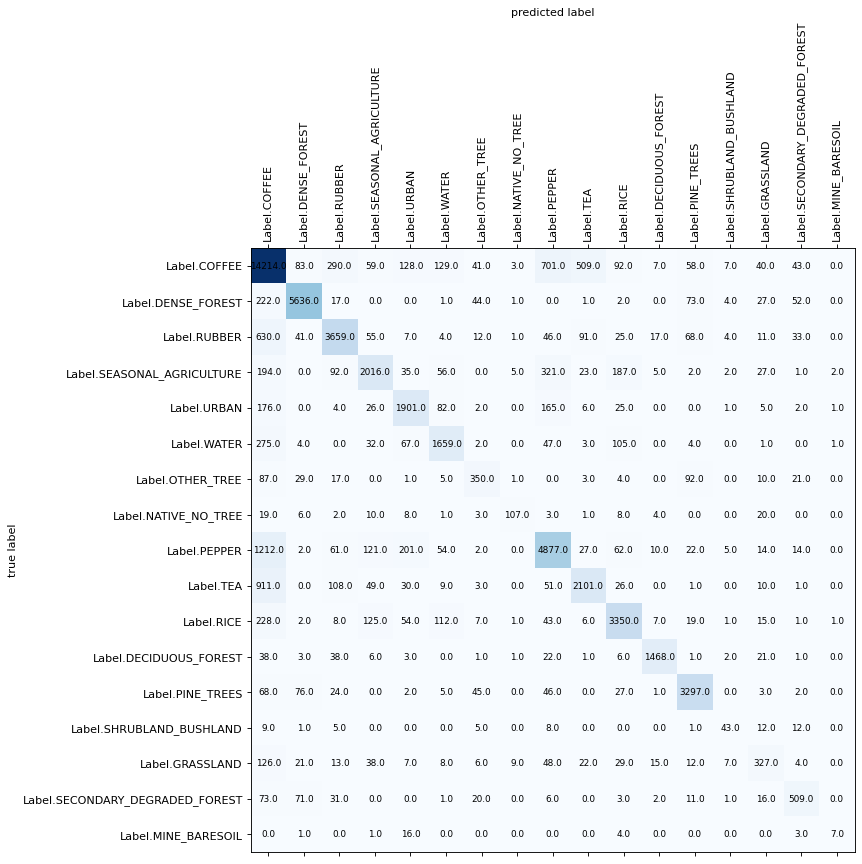

In [7]:
pl.figure(figsize=(12, 10), dpi=80)

plot_confusion_matrix(conf_matrices[0], labels)

In [8]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.76907261 0.94310576 0.83749142 0.79432624 0.77276423 0.78033866
 0.64456722 0.82945736 0.7639411  0.7519685  0.84702908 0.95572917
 0.90057361 0.55844156 0.58497317 0.72818312 0.58333333]
Mean precision:  0.7673703612886213

Recalls:  [0.86649598 0.92697368 0.77784864 0.67924528 0.79340568 0.75409091
 0.56451613 0.55729167 0.7296529  0.63666667 0.84170854 0.91066998
 0.91685206 0.44791667 0.47254335 0.68413978 0.21875   ]
Mean recall:  0.6928687007805311

F-Score:  [0.81488276 0.93497014 0.80656894 0.73229205 0.78294893 0.76699029
 0.60189166 0.66666667 0.74640343 0.68953069 0.84436043 0.93265565
 0.90863993 0.49710983 0.52278177 0.70547471 0.31818182]
Mean f-score:  0.7219029228516751


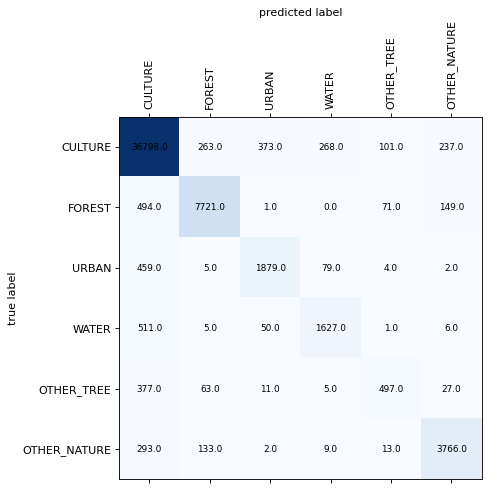

In [9]:
pl.figure(figsize=(8, 6), dpi=80)

plot_confusion_matrix(conf_matrices[1], [category.name for category in categories])

In [10]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.94518648 0.94273504 0.81131261 0.81841046 0.72343523 0.89945068]
Mean precision:  0.8567550831237272

Recalls:  [0.96735016 0.91524419 0.77388797 0.73954545 0.50714286 0.89326376]
Mean recall:  0.799405731955601

F-Score:  [0.9561399  0.92878624 0.79215852 0.77698185 0.59628074 0.89634654]
Mean f-score:  0.8244489648557346


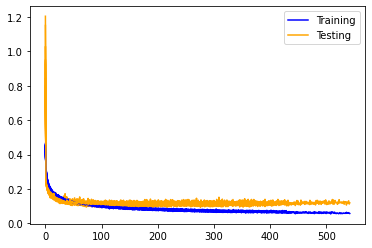

In [11]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

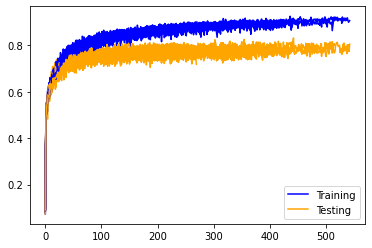

In [12]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()